<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$

#Factor de regularización para asegurar una energía negativa en el aprendizaje no supervisado
$$ \textit{R}\left ( r_{ij} \right ) =  \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right]  $$

# Para asegurar que la energía sea negativa, basta con asegurar que la sección que involucra la distancia sea negativa

# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.700e-6 #Fondo del pozo del aluminio (kj/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10.031 #Fondo del pozo mercurio (kj/mol)
Sigma = np.sqrt(SigmaAl*SigmaHg)
Epsilon = np.sqrt(EpsilonAl*EpsilonHg)

In [56]:
909*Epsilon

7.988796547334274

# Creación de la muestra

909


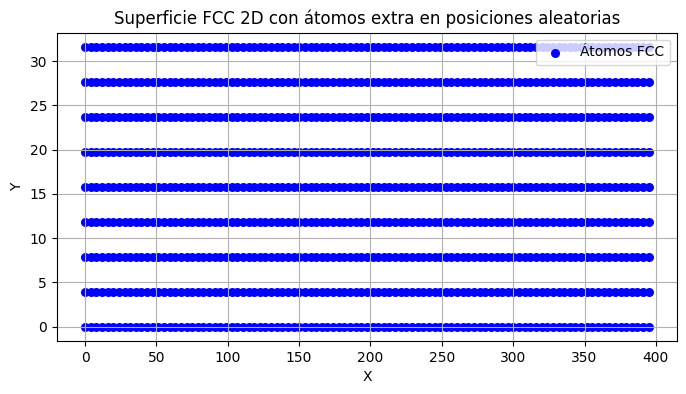

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 50
celdas_alto = 4
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0, 0], [0.5, 0], [0, 0.5], [0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
x, y = [], []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        # Posiciones de átomos en cada celda FCC
        atoms = base_fcc + np.array([i * a, j * a])
        x.extend(atoms[:, 0])
        y.extend(atoms[:, 1])

# Agregar átomos adicionales en la última fila y columna
# Última columna
for j in range(celdas_alto):
    x.append(celdas_largo * a)
    y.append(j * a + 0)  # Átomo en el vértice
    x.append(celdas_largo * a)
    y.append(j * a + 0.5 * a)  # Átomo en el centro de la cara

# Última fila
for i in range(celdas_largo):
    x.append(i * a + 0)
    y.append(celdas_alto * a)
    x.append(i * a + 0.5 * a)
    y.append(celdas_alto * a)

# Añadir el átomo del vértice superior derecho
x.append(celdas_largo * a)
y.append(celdas_alto * a)

fcc_positions = np.column_stack((x, y))  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
print(num_atoms)
# Graficar la estructura FCC con átomos adicionales
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Creación de los iones que se van a adsorber

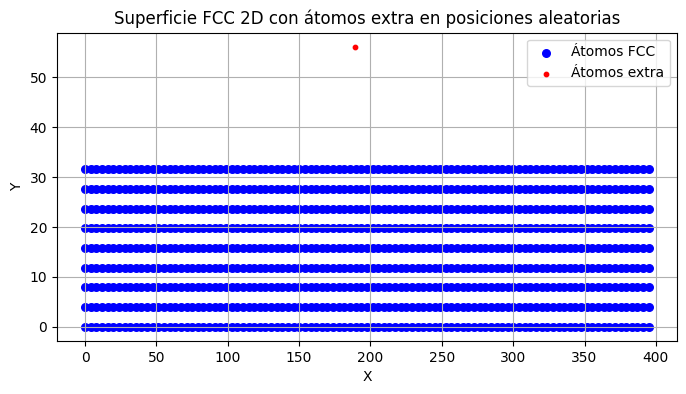

In [4]:
num_atomos_extra = 1  # Número de átomos extra que se colocarán al azar

# Generar átomos adicionales en posiciones aleatorias por encima de la superficie
x_extra = np.random.uniform(0, celdas_largo * a, num_atomos_extra)
y_extra = np.random.uniform(celdas_alto * a + 0.5*a, celdas_alto * a + 5*a, num_atomos_extra)  # Y mayor que la parte más alta
extra_positions = np.column_stack((x_extra, y_extra))  # Matriz con posiciones de átomos extra

# Graficar las posiciones
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.scatter(extra_positions[:, 0], extra_positions[:, 1], color='red', s=10, label="Átomos extra")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon=Epsilon, sigma=Sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term + epsilon #Suma epsilon para desplazar el fondo del potencial a 0

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon=Epsilon, sigma=Sigma,lam_=1.0):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    # Expandir dimensiones para obtener todas las combinaciones de distancias
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción
    lj_energy = lennard_jones_potential(r, epsilon, sigma)  # (num_iones, num_superficie)
    #reg_term = tf.reduce_sum(lj_energy/4*epsilon,axis=1)
    # Energía total para cada ion
    E_total = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)
    #print(E_total.shape)
    # Devolver la energía promedio del sistema
    energy_total = tf.reduce_mean(lam_*E_total)#+(1-lam_)*reg_term)  # Promedio sobre los iones (escalar)
    #print(energy_total.shape)
    return energy_total

In [6]:
#tensorflow data
ion = tf.Variable(extra_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
#lam_LJ = 0.4
#lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [7]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

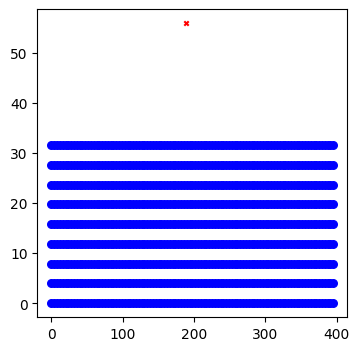

Epoch 1/500
Loss: 1.2391858100891113 MeanGrad: [-4.7899187e-09  8.7798149e-08]


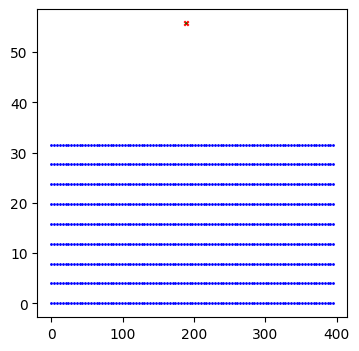

Epoch 2/500
Loss: 1.2391858100891113 MeanGrad: [3.8360013e-09 6.6760698e-08]


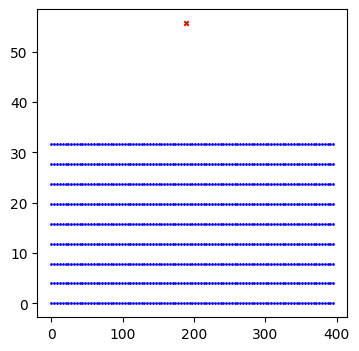

Epoch 3/500
Loss: 1.2391858100891113 MeanGrad: [-1.6206236e-10  6.7405161e-08]


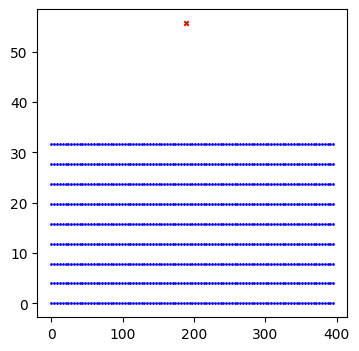

Epoch 4/500
Loss: 1.23918616771698 MeanGrad: [-1.2413569e-09  1.9691452e-08]


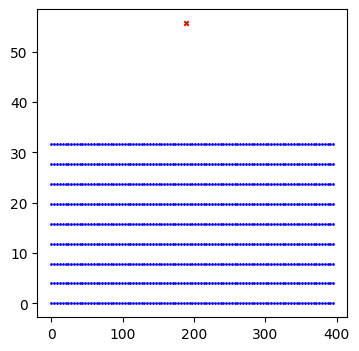

Epoch 5/500
Loss: 1.2391858100891113 MeanGrad: [6.341558e-09 6.466747e-08]


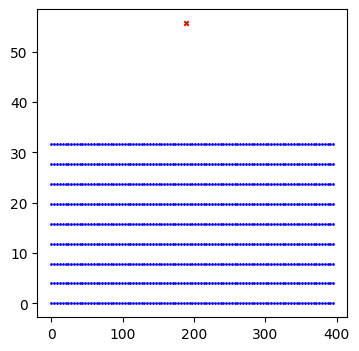

Epoch 6/500
Loss: 1.2391858100891113 MeanGrad: [-9.600815e-09  6.339329e-08]


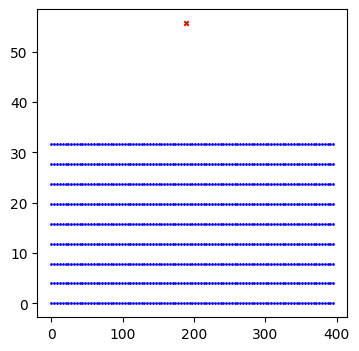

Epoch 7/500
Loss: 1.23918616771698 MeanGrad: [-8.2360172e-09  2.6547662e-08]


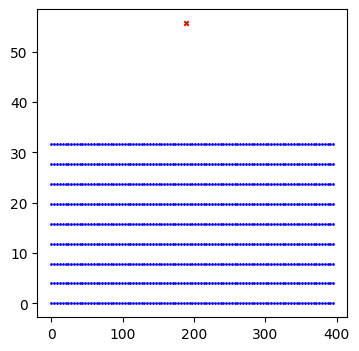

Epoch 8/500
Loss: 1.2391855716705322 MeanGrad: [1.67164327e-08 1.02413125e-07]


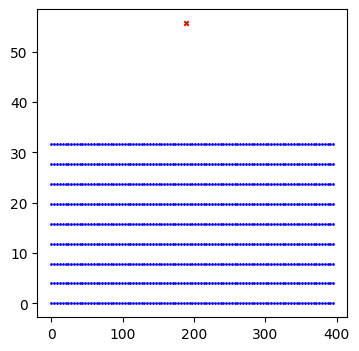

Epoch 9/500
Loss: 1.2391858100891113 MeanGrad: [-6.1141563e-09  6.4233539e-08]


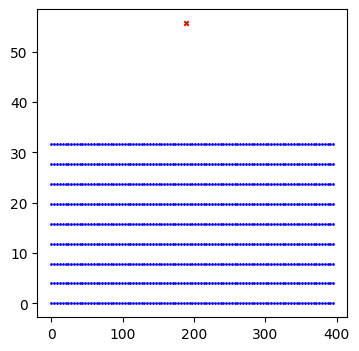

Epoch 10/500
Loss: 1.2391859292984009 MeanGrad: [-3.6358292e-09  7.0550300e-08]


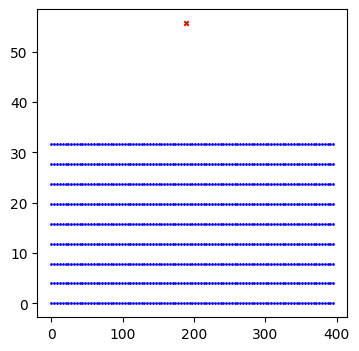

Epoch 11/500
Loss: 1.2391859292984009 MeanGrad: [7.7465181e-09 5.6704483e-08]


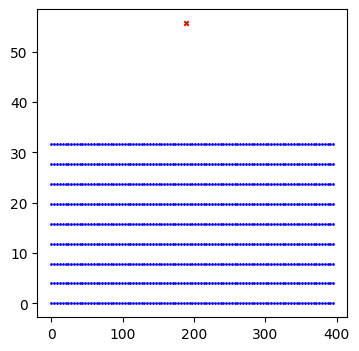

Epoch 12/500
Loss: 1.2391859292984009 MeanGrad: [-7.7622895e-09  3.4921111e-08]


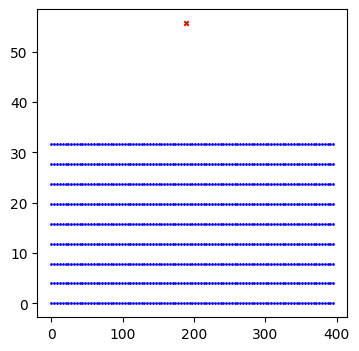

Epoch 13/500
Loss: 1.2391859292984009 MeanGrad: [-5.1879967e-09  5.4772816e-08]


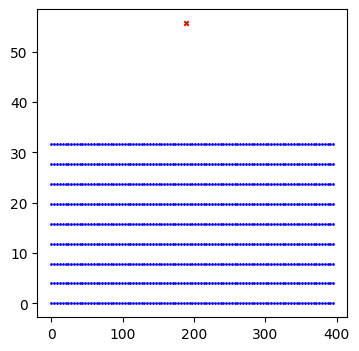

Epoch 14/500
Loss: 1.2391858100891113 MeanGrad: [1.3188991e-09 7.8859230e-08]


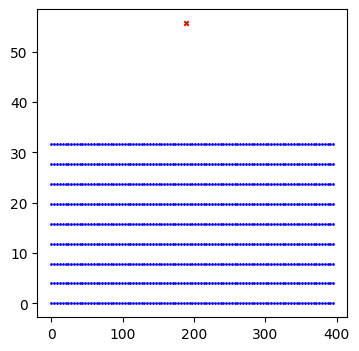

Epoch 15/500
Loss: 1.2391860485076904 MeanGrad: [3.1989495e-09 4.8039290e-08]


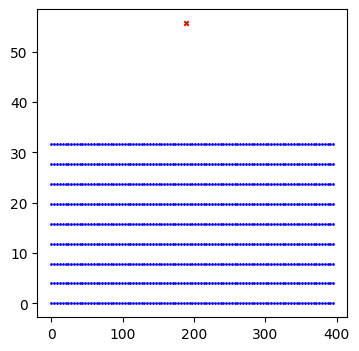

Epoch 16/500
Loss: 1.2391859292984009 MeanGrad: [6.0940701e-09 5.5852425e-08]


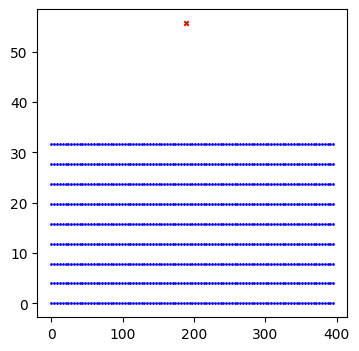

Epoch 17/500
Loss: 1.2391859292984009 MeanGrad: [-1.5932981e-08  3.9817799e-08]


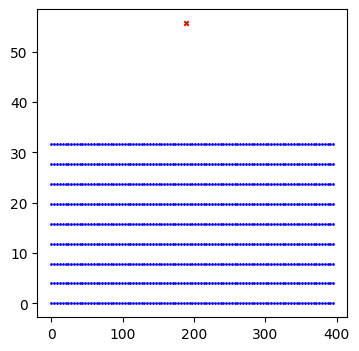

Epoch 18/500
Loss: 1.2391859292984009 MeanGrad: [4.4488764e-09 3.0270318e-08]


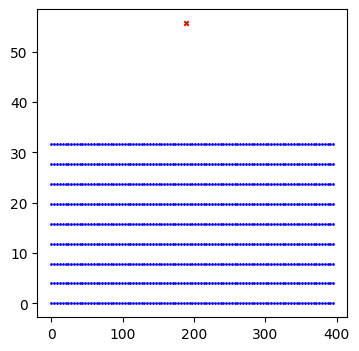

Epoch 19/500
Loss: 1.2391859292984009 MeanGrad: [-6.4476637e-09  4.7380915e-08]


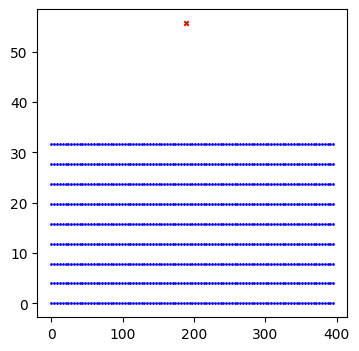

Epoch 20/500
Loss: 1.2391858100891113 MeanGrad: [-8.4092076e-09  8.4380922e-08]


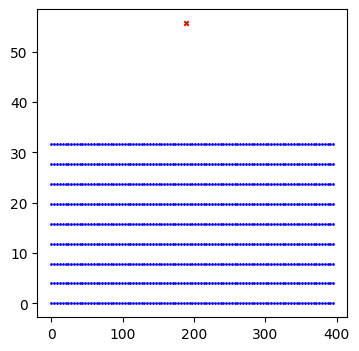

Epoch 21/500
Loss: 1.23918616771698 MeanGrad: [-1.0772200e-09  2.1999112e-08]


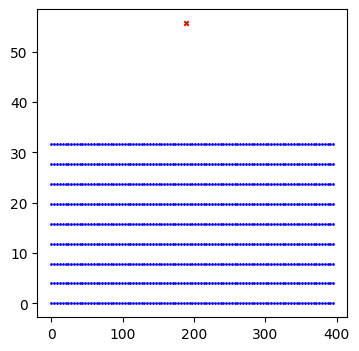

Epoch 22/500
Loss: 1.2391859292984009 MeanGrad: [-7.527758e-09  4.499158e-08]


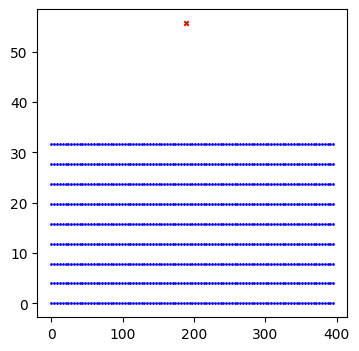

Epoch 23/500
Loss: 1.2391859292984009 MeanGrad: [2.6440719e-09 6.2053921e-08]


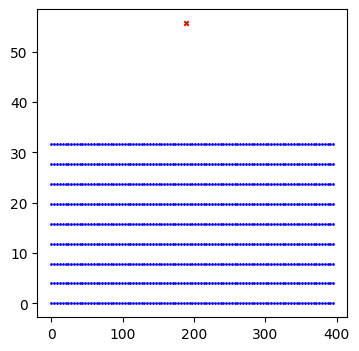

Epoch 24/500
Loss: 1.2391860485076904 MeanGrad: [-5.1954903e-09  3.8344297e-08]


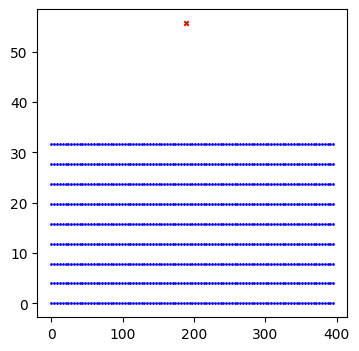

Epoch 25/500
Loss: 1.2391858100891113 MeanGrad: [-1.6612619e-08  5.5865968e-08]


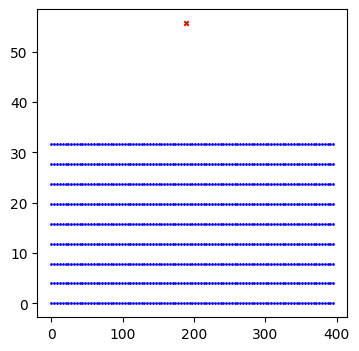

Epoch 26/500
Loss: 1.2391860485076904 MeanGrad: [9.7241926e-10 2.9873142e-08]


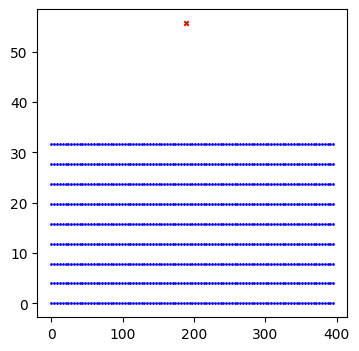

Epoch 27/500
Loss: 1.2391859292984009 MeanGrad: [3.7165757e-09 4.8144400e-08]


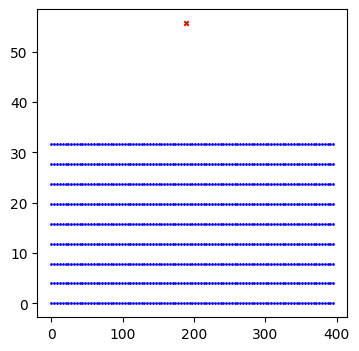

Epoch 28/500
Loss: 1.2391858100891113 MeanGrad: [8.6275769e-09 5.1132496e-08]


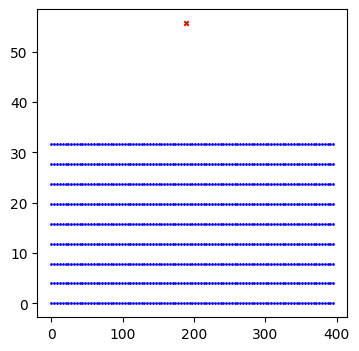

Epoch 29/500
Loss: 1.2391860485076904 MeanGrad: [-6.1956698e-09  3.3948378e-08]


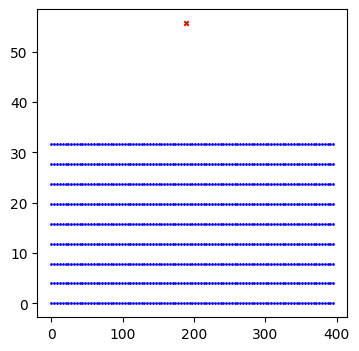

Epoch 30/500
Loss: 1.2391858100891113 MeanGrad: [1.0589923e-08 5.5499541e-08]


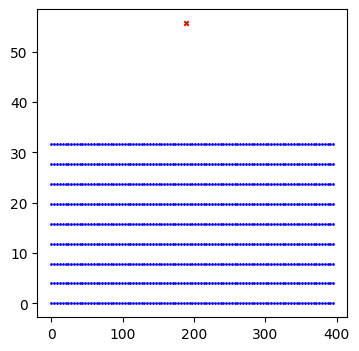

Epoch 31/500
Loss: 1.2391858100891113 MeanGrad: [-1.5315825e-08  5.7056347e-08]


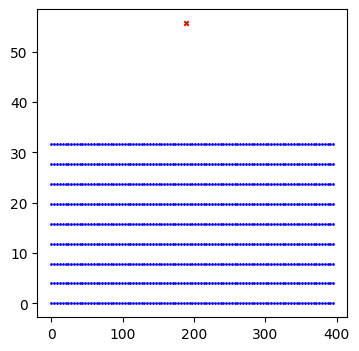

Epoch 32/500
Loss: 1.2391859292984009 MeanGrad: [-4.3783546e-09  4.5198430e-08]


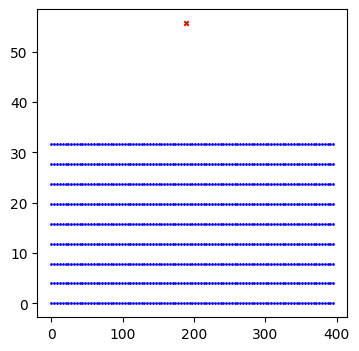

Epoch 33/500
Loss: 1.2391858100891113 MeanGrad: [6.9749184e-10 5.5622962e-08]


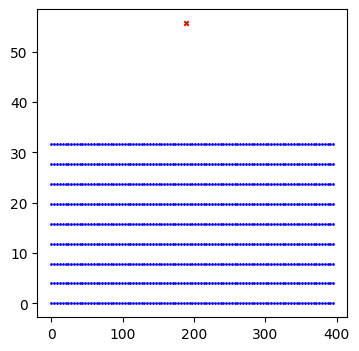

Epoch 34/500
Loss: 1.2391858100891113 MeanGrad: [-1.5933663e-08  4.8269989e-08]


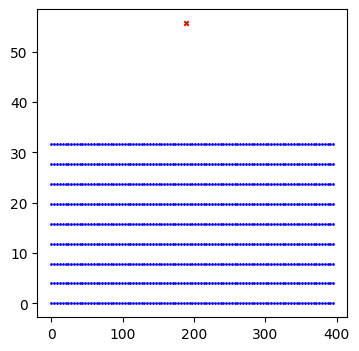

Epoch 35/500
Loss: 1.2391858100891113 MeanGrad: [-5.529169e-09  8.433258e-08]


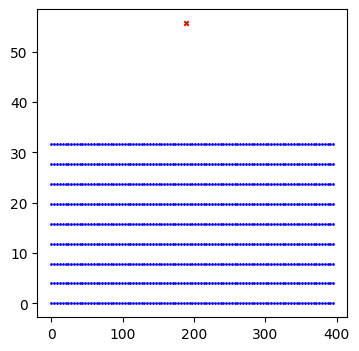

Epoch 36/500
Loss: 1.2391860485076904 MeanGrad: [8.123063e-10 2.786656e-08]


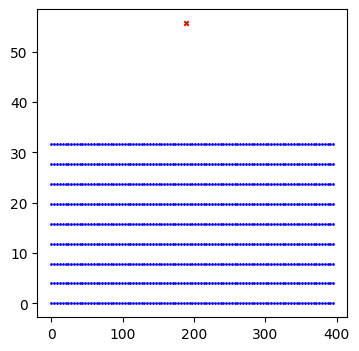

Epoch 37/500
Loss: 1.2391859292984009 MeanGrad: [2.5588247e-09 5.5531125e-08]


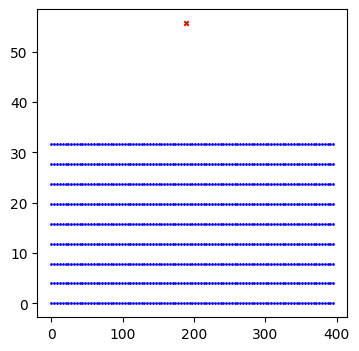

Epoch 38/500
Loss: 1.2391859292984009 MeanGrad: [-5.3753775e-09  5.0509730e-08]


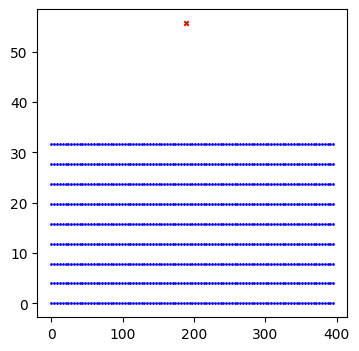

Epoch 39/500
Loss: 1.23918616771698 MeanGrad: [5.9510077e-09 1.5210773e-08]


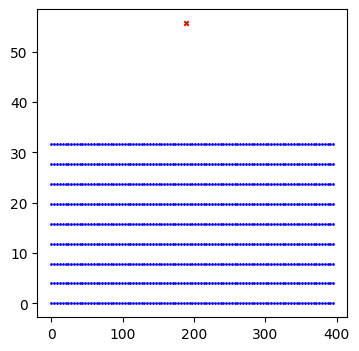

Epoch 40/500
Loss: 1.2391860485076904 MeanGrad: [3.9823123e-09 5.6970691e-08]


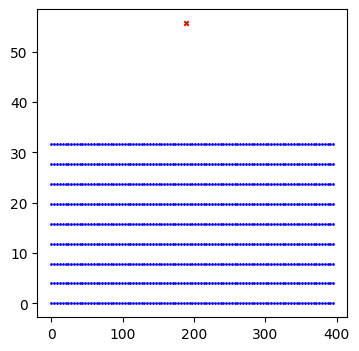

Epoch 41/500
Loss: 1.2391858100891113 MeanGrad: [4.1458357e-09 8.6535799e-08]


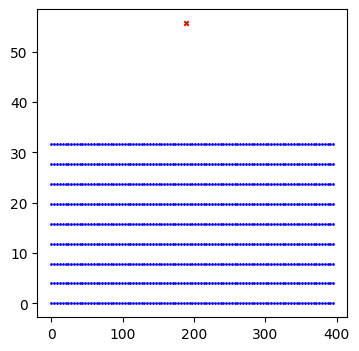

Epoch 42/500
Loss: 1.2391858100891113 MeanGrad: [-6.9572548e-09  7.3953522e-08]


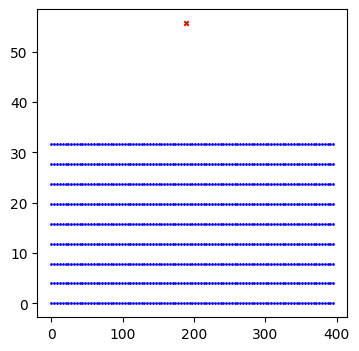

Epoch 43/500
Loss: 1.2391859292984009 MeanGrad: [-1.5267270e-09  3.1971837e-08]


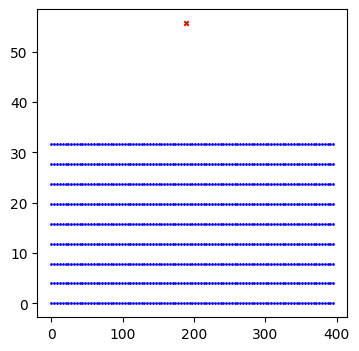

Epoch 44/500
Loss: 1.2391859292984009 MeanGrad: [7.111733e-09 6.121050e-08]


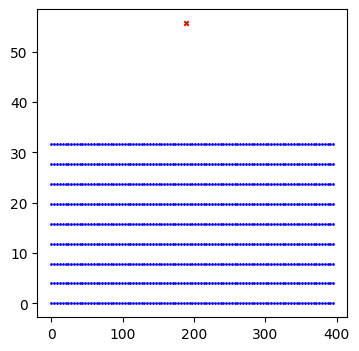

Epoch 45/500
Loss: 1.2391859292984009 MeanGrad: [1.6350624e-08 3.8497287e-08]


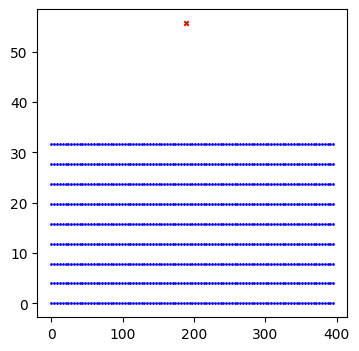

Epoch 46/500
Loss: 1.2391859292984009 MeanGrad: [3.8610084e-09 6.5821709e-08]


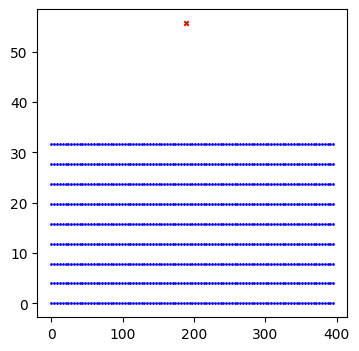

Epoch 47/500
Loss: 1.2391856908798218 MeanGrad: [1.4199135e-09 8.8486225e-08]


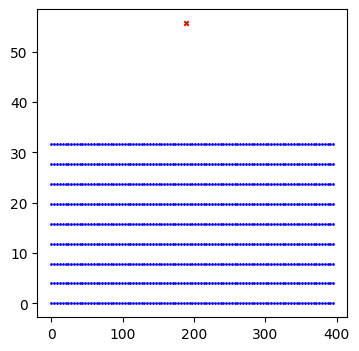

Epoch 48/500
Loss: 1.2391858100891113 MeanGrad: [-3.1764746e-09  6.1939261e-08]


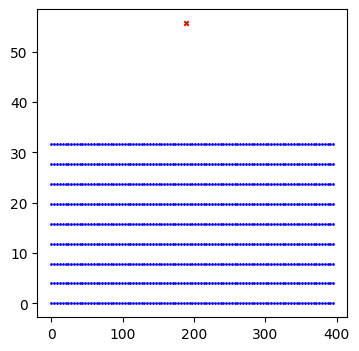

Epoch 49/500
Loss: 1.2391859292984009 MeanGrad: [-5.8070313e-09  4.6984759e-08]


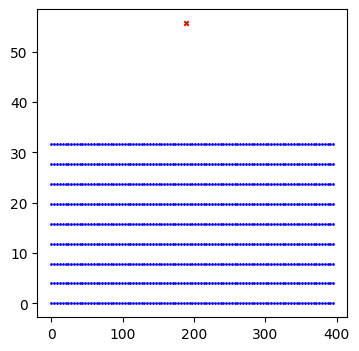

Epoch 50/500
Loss: 1.2391858100891113 MeanGrad: [2.5832980e-09 5.4170187e-08]


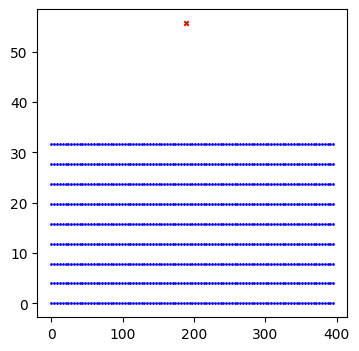

Epoch 51/500
Loss: 1.2391859292984009 MeanGrad: [3.2326946e-09 3.5522877e-08]


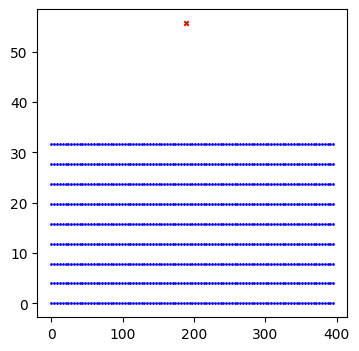

Epoch 52/500
Loss: 1.2391860485076904 MeanGrad: [3.5205214e-09 1.9322608e-08]


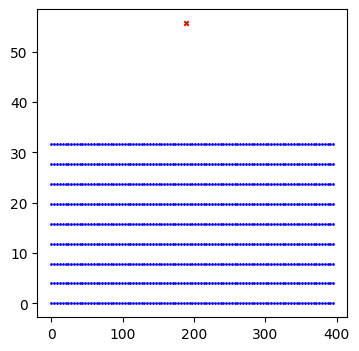

Epoch 53/500
Loss: 1.2391859292984009 MeanGrad: [-4.1576071e-09  3.8749366e-08]


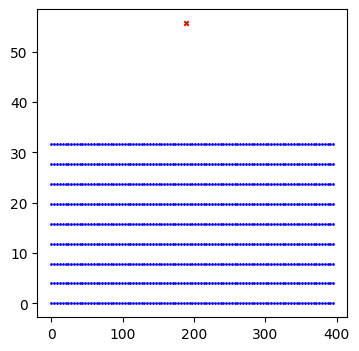

Epoch 54/500
Loss: 1.2391860485076904 MeanGrad: [-8.436184e-09  2.734346e-08]


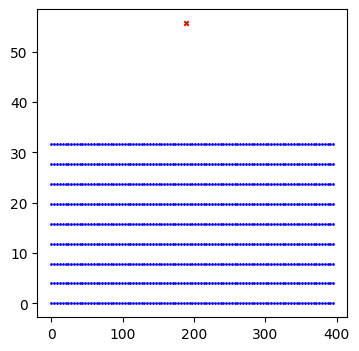

Epoch 55/500
Loss: 1.2391860485076904 MeanGrad: [-7.429885e-09  2.786278e-08]


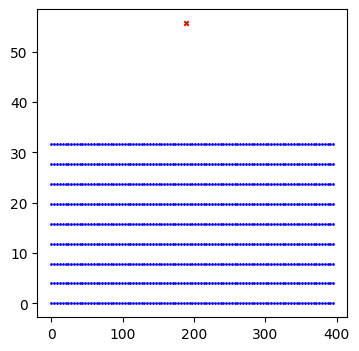

Epoch 56/500
Loss: 1.2391858100891113 MeanGrad: [-4.7611697e-09  4.4065878e-08]


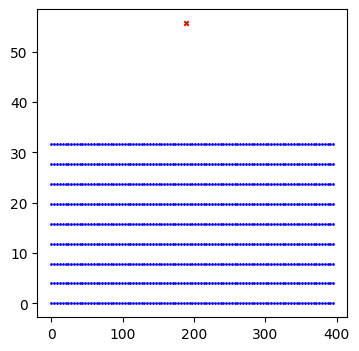

Epoch 57/500
Loss: 1.2391860485076904 MeanGrad: [-8.3729628e-09  1.8218268e-08]


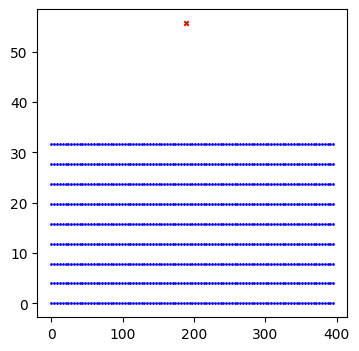

Epoch 58/500
Loss: 1.2391860485076904 MeanGrad: [1.1875601e-08 3.4899458e-08]


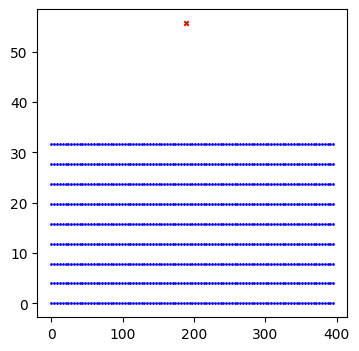

Epoch 59/500
Loss: 1.2391859292984009 MeanGrad: [-6.5054757e-09  5.3367295e-08]


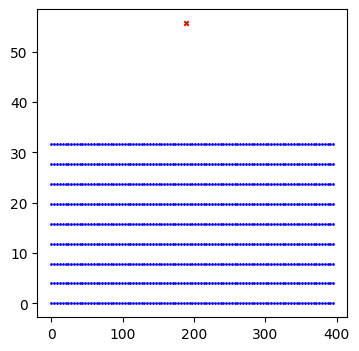

Epoch 60/500
Loss: 1.2391859292984009 MeanGrad: [4.8081854e-09 5.3085564e-08]


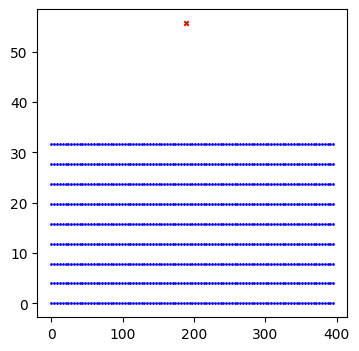

Epoch 61/500
Loss: 1.2391860485076904 MeanGrad: [4.5563753e-09 3.2066470e-08]


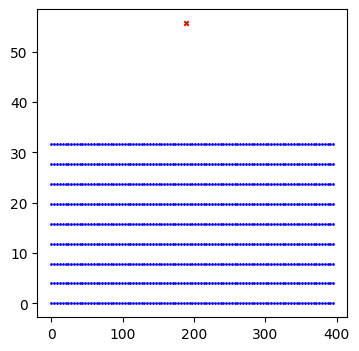

Epoch 62/500
Loss: 1.2391858100891113 MeanGrad: [-1.5025334e-08  4.2539945e-08]


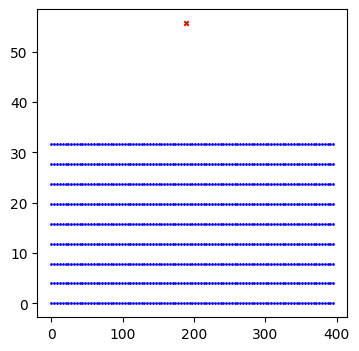

Epoch 63/500
Loss: 1.2391859292984009 MeanGrad: [1.3721772e-08 2.8646127e-08]


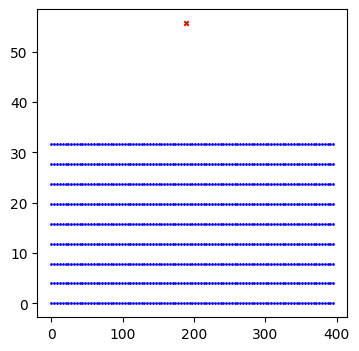

Epoch 64/500
Loss: 1.2391855716705322 MeanGrad: [1.1640227e-09 1.3866068e-07]


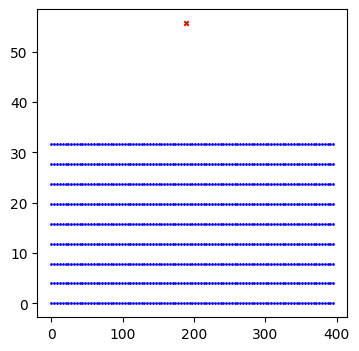

Epoch 65/500
Loss: 1.23918616771698 MeanGrad: [-8.6471390e-09  2.3245063e-08]


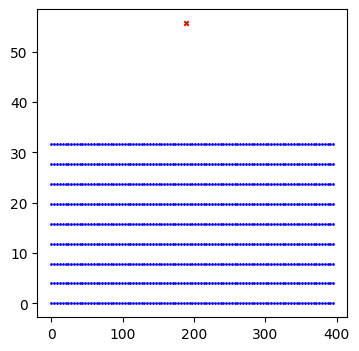

Epoch 66/500
Loss: 1.2391860485076904 MeanGrad: [-4.4353592e-09  4.0090853e-08]


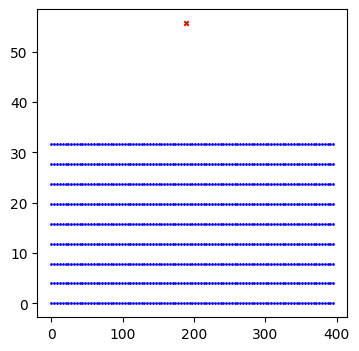

Epoch 67/500
Loss: 1.2391859292984009 MeanGrad: [5.0140114e-09 4.7722136e-08]


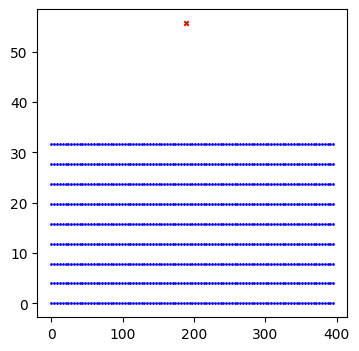

Epoch 68/500
Loss: 1.2391855716705322 MeanGrad: [1.1054091e-08 9.8041532e-08]


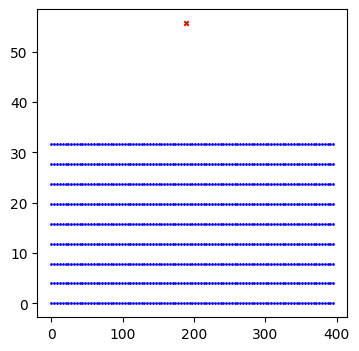

Epoch 69/500
Loss: 1.2391860485076904 MeanGrad: [-5.5336451e-09  4.2901238e-08]


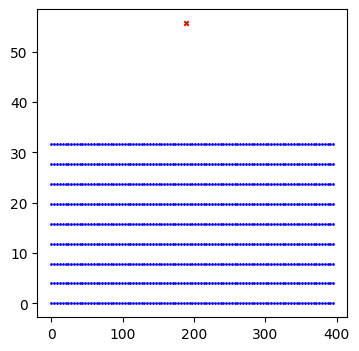

Epoch 70/500
Loss: 1.2391859292984009 MeanGrad: [-8.5009226e-09  4.9530133e-08]


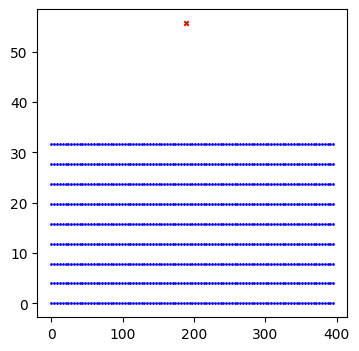

Epoch 71/500
Loss: 1.2391859292984009 MeanGrad: [-5.7601715e-09  5.9185947e-08]


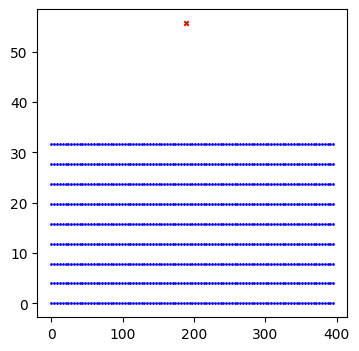

Epoch 72/500
Loss: 1.2391855716705322 MeanGrad: [-6.748362e-10  1.069435e-07]


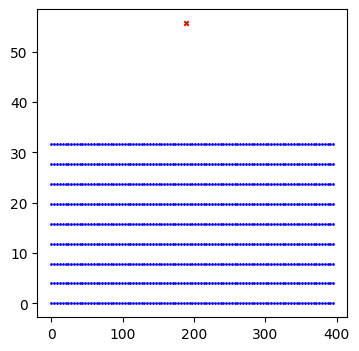

Epoch 73/500
Loss: 1.2391858100891113 MeanGrad: [-4.8621325e-09  5.6033116e-08]


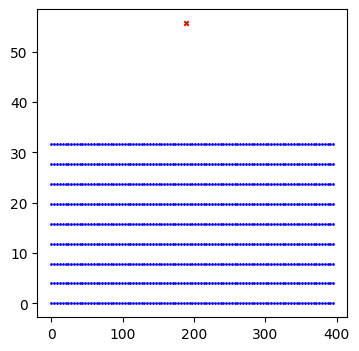

Epoch 74/500
Loss: 1.23918616771698 MeanGrad: [1.0384740e-08 2.6257409e-08]


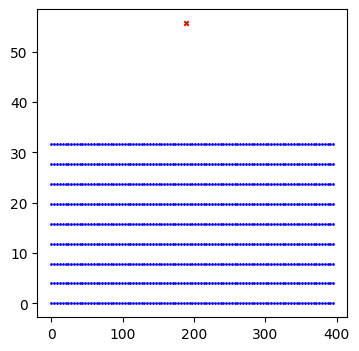

Epoch 75/500
Loss: 1.23918616771698 MeanGrad: [-9.6854276e-09  2.4127056e-08]


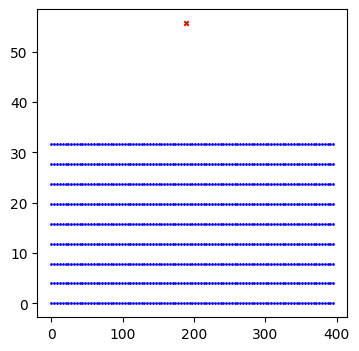

Epoch 76/500
Loss: 1.2391858100891113 MeanGrad: [-3.1526906e-09  8.8090346e-08]


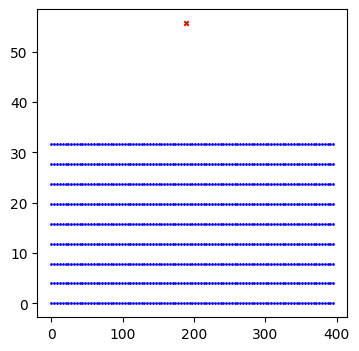

Epoch 77/500
Loss: 1.2391858100891113 MeanGrad: [1.6228041e-09 7.0273870e-08]


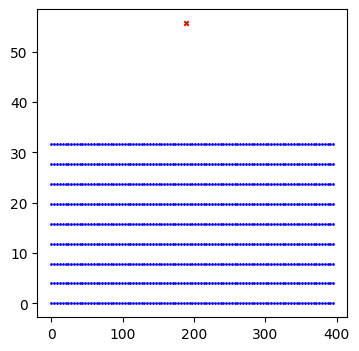

Epoch 78/500
Loss: 1.23918616771698 MeanGrad: [-1.7325699e-09  1.5062364e-08]


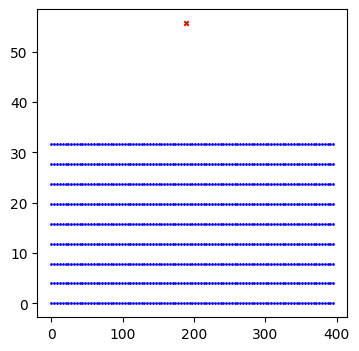

Epoch 79/500
Loss: 1.2391858100891113 MeanGrad: [4.4576418e-09 4.6635527e-08]


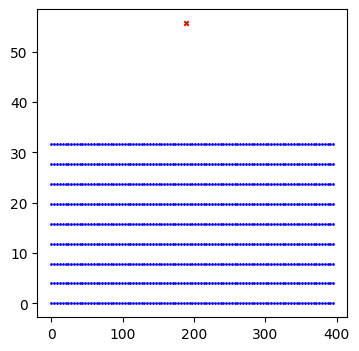

Epoch 80/500
Loss: 1.2391858100891113 MeanGrad: [6.5160783e-09 6.8954073e-08]


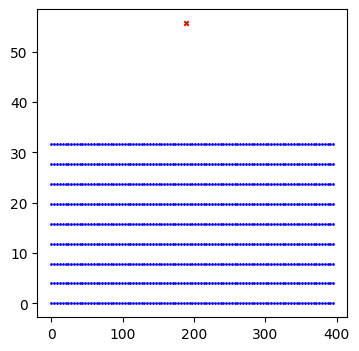

Epoch 81/500
Loss: 1.2391860485076904 MeanGrad: [-1.8476702e-09  3.1611627e-08]


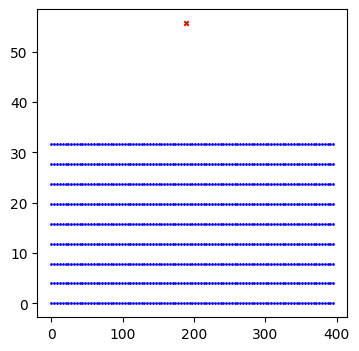

Epoch 82/500
Loss: 1.2391859292984009 MeanGrad: [1.1452902e-08 5.5047604e-08]


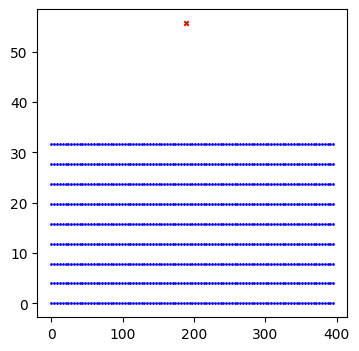

Epoch 83/500
Loss: 1.2391860485076904 MeanGrad: [1.6598647e-09 3.0390993e-08]


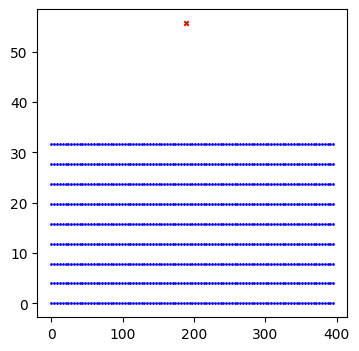

Epoch 84/500
Loss: 1.2391858100891113 MeanGrad: [3.4495609e-09 7.9827323e-08]


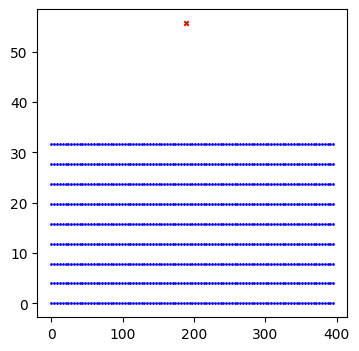

Epoch 85/500
Loss: 1.2391860485076904 MeanGrad: [4.3562278e-09 2.8773242e-08]


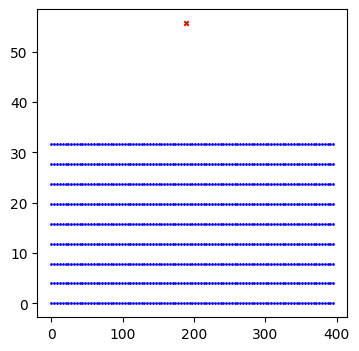

Epoch 86/500
Loss: 1.2391859292984009 MeanGrad: [-5.9925740e-09  5.4783527e-08]


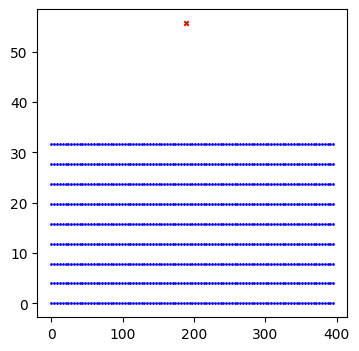

Epoch 87/500
Loss: 1.2391859292984009 MeanGrad: [-1.4297242e-09  5.6163838e-08]


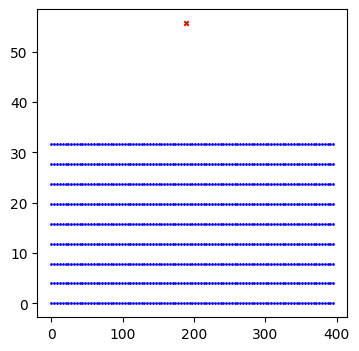

Epoch 88/500
Loss: 1.2391859292984009 MeanGrad: [9.197950e-09 3.444617e-08]


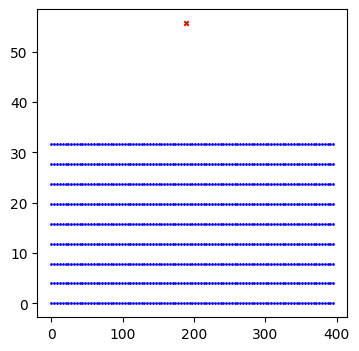

Epoch 89/500
Loss: 1.2391855716705322 MeanGrad: [-3.6307817e-09  1.3482935e-07]


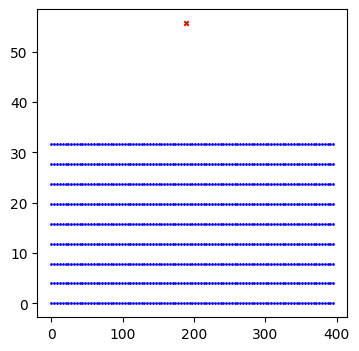

Epoch 90/500
Loss: 1.2391859292984009 MeanGrad: [2.0666242e-09 5.5390423e-08]


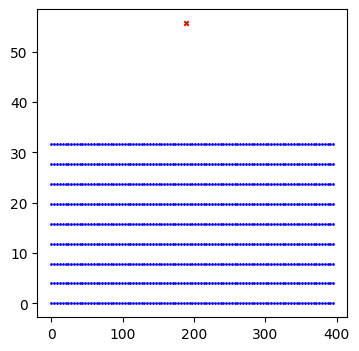

Epoch 91/500
Loss: 1.2391855716705322 MeanGrad: [7.5212752e-09 1.0827251e-07]


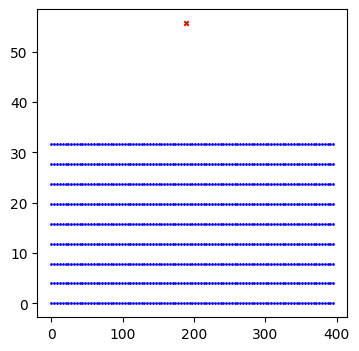

Epoch 92/500
Loss: 1.2391859292984009 MeanGrad: [-5.912189e-09  5.429647e-08]


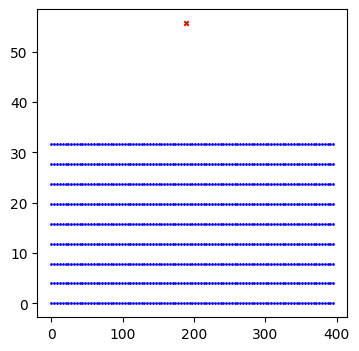

Epoch 93/500
Loss: 1.2391858100891113 MeanGrad: [2.0852973e-09 6.5137833e-08]


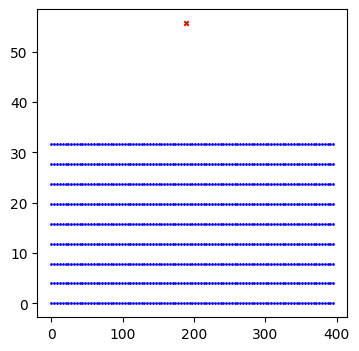

Epoch 94/500
Loss: 1.2391858100891113 MeanGrad: [8.162166e-09 5.756485e-08]


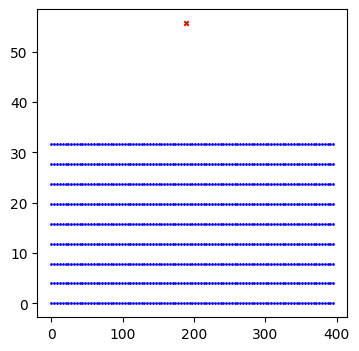

Epoch 95/500
Loss: 1.2391858100891113 MeanGrad: [1.207244e-08 5.714329e-08]


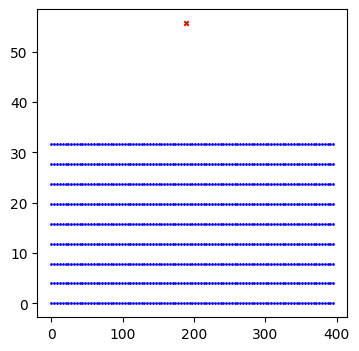

Epoch 96/500
Loss: 1.2391858100891113 MeanGrad: [-4.9771653e-09  8.5822229e-08]


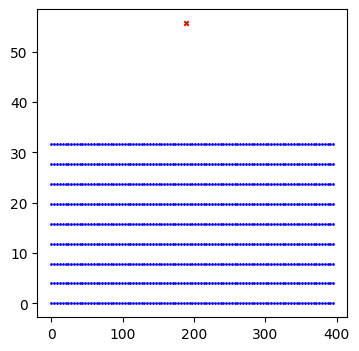

Epoch 97/500
Loss: 1.2391858100891113 MeanGrad: [8.331923e-10 6.310851e-08]


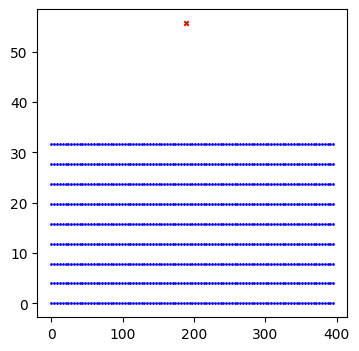

Epoch 98/500
Loss: 1.2391856908798218 MeanGrad: [1.5206279e-08 9.7902728e-08]


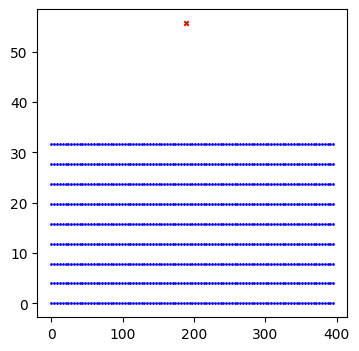

Epoch 99/500
Loss: 1.2391859292984009 MeanGrad: [1.28492905e-08 4.76360817e-08]


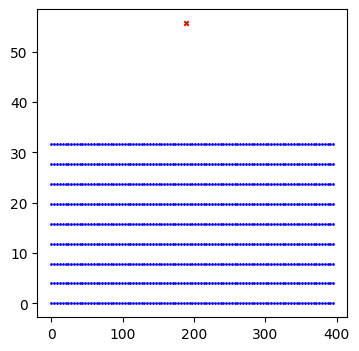

Epoch 100/500
Loss: 1.2391858100891113 MeanGrad: [5.362269e-09 8.467880e-08]


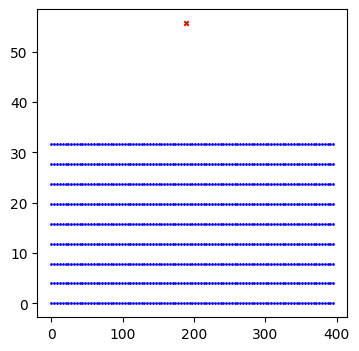

Epoch 101/500
Loss: 1.2391858100891113 MeanGrad: [-1.7498182e-08  8.0666346e-08]


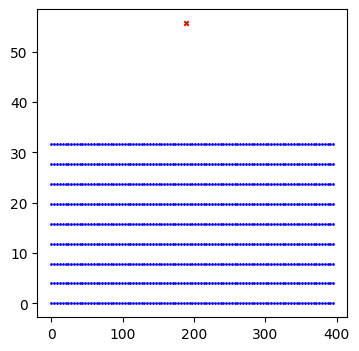

Epoch 102/500
Loss: 1.2391860485076904 MeanGrad: [-5.6164806e-10  1.7040470e-08]


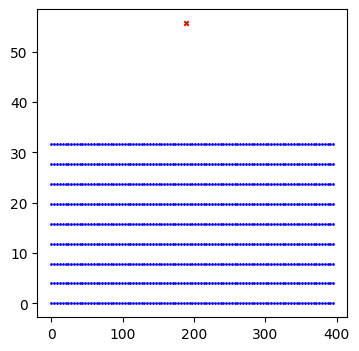

Epoch 103/500
Loss: 1.2391860485076904 MeanGrad: [1.17948264e-08 4.19339621e-08]


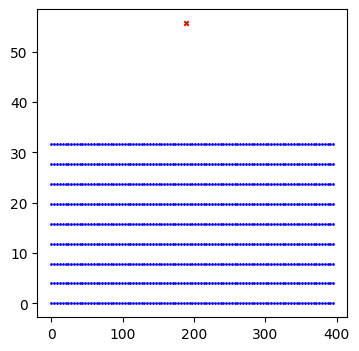

Epoch 104/500
Loss: 1.2391859292984009 MeanGrad: [9.9082884e-09 5.0272497e-08]


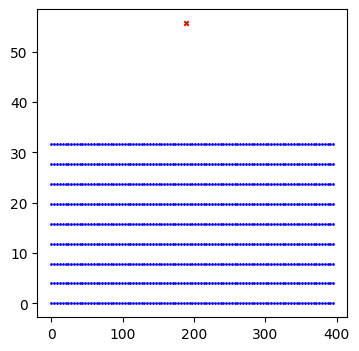

Epoch 105/500
Loss: 1.2391859292984009 MeanGrad: [-1.1375944e-08  7.1956293e-08]


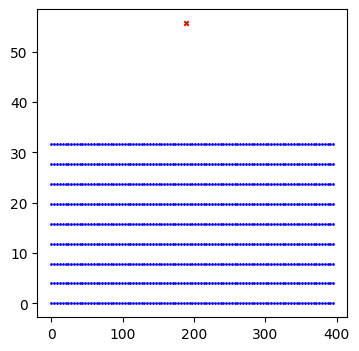

Epoch 106/500
Loss: 1.2391858100891113 MeanGrad: [-9.139982e-10  5.051988e-08]


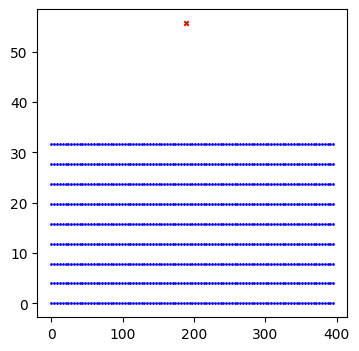

Epoch 107/500
Loss: 1.2391859292984009 MeanGrad: [5.863156e-09 5.674785e-08]


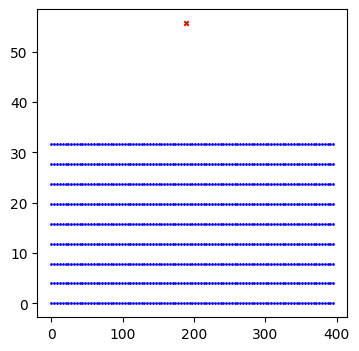

Epoch 108/500
Loss: 1.2391859292984009 MeanGrad: [-1.327606e-08  6.657291e-08]


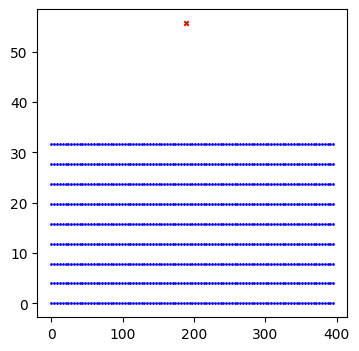

Epoch 109/500
Loss: 1.2391859292984009 MeanGrad: [6.8471198e-09 5.4167781e-08]


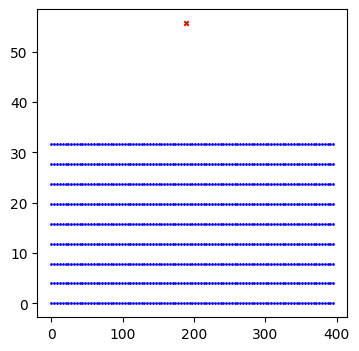

Epoch 110/500
Loss: 1.2391855716705322 MeanGrad: [-7.2477531e-09  1.2139776e-07]


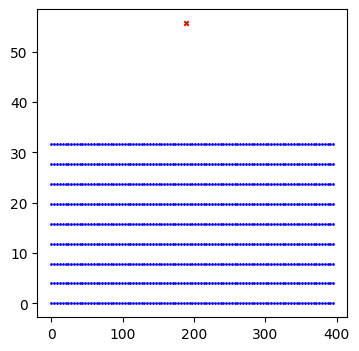

Epoch 111/500
Loss: 1.2391858100891113 MeanGrad: [1.5526105e-08 6.4889520e-08]


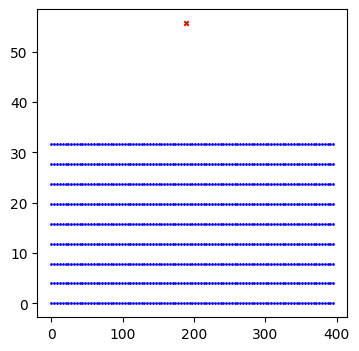

Epoch 112/500
Loss: 1.2391859292984009 MeanGrad: [7.1656934e-09 3.7740257e-08]


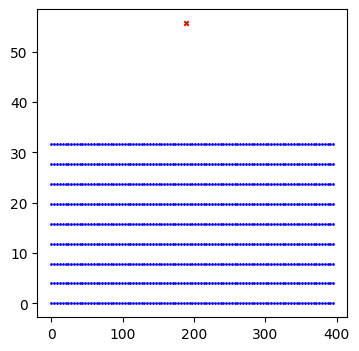

Epoch 113/500
Loss: 1.2391858100891113 MeanGrad: [2.1463946e-09 8.4874976e-08]


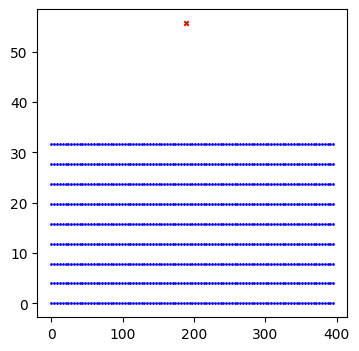

Epoch 114/500
Loss: 1.2391859292984009 MeanGrad: [1.0342941e-08 6.2727366e-08]


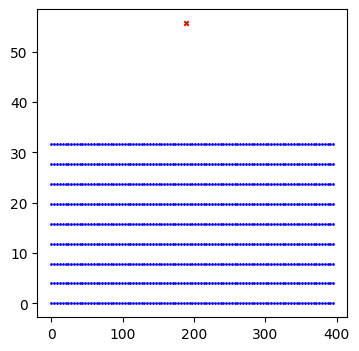

Epoch 115/500
Loss: 1.2391859292984009 MeanGrad: [4.356078e-09 3.528601e-08]


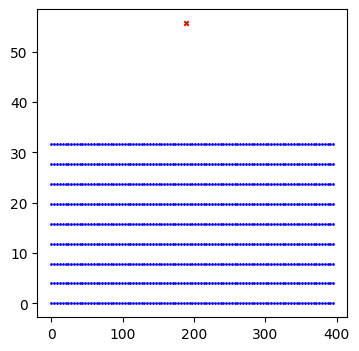

Epoch 116/500
Loss: 1.2391856908798218 MeanGrad: [-5.1789479e-09  1.0138626e-07]


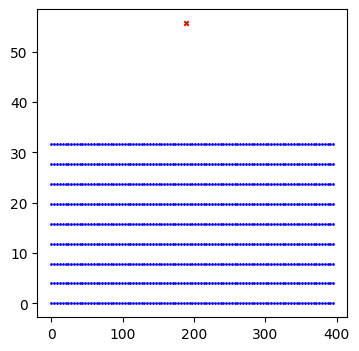

Epoch 117/500
Loss: 1.2391859292984009 MeanGrad: [4.3642965e-09 8.0771137e-08]


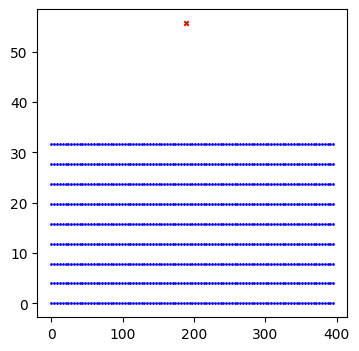

Epoch 118/500
Loss: 1.2391859292984009 MeanGrad: [1.5983142e-08 8.7227569e-08]


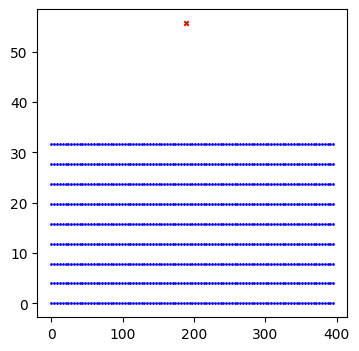

Epoch 119/500
Loss: 1.2391860485076904 MeanGrad: [-8.549701e-09  4.073855e-08]


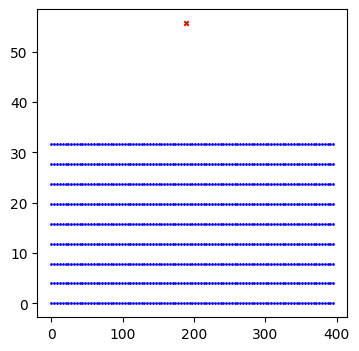

Epoch 120/500
Loss: 1.2391859292984009 MeanGrad: [2.7318017e-09 4.5287099e-08]


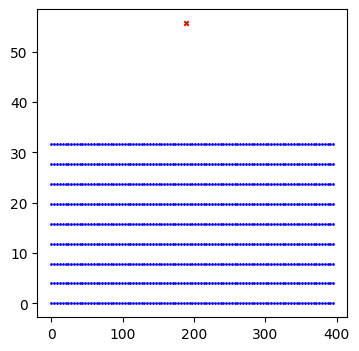

Epoch 121/500
Loss: 1.2391860485076904 MeanGrad: [-5.3377409e-09  2.5594508e-08]


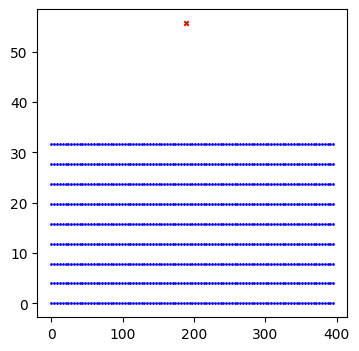

Epoch 122/500
Loss: 1.2391858100891113 MeanGrad: [-1.3916516e-08  9.5772478e-08]


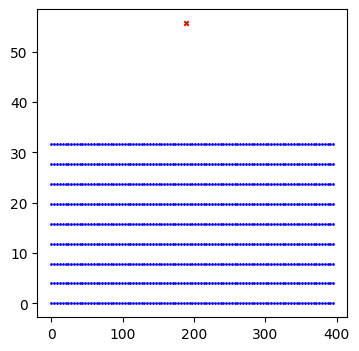

Epoch 123/500
Loss: 1.2391858100891113 MeanGrad: [-3.1890808e-09  5.2770314e-08]


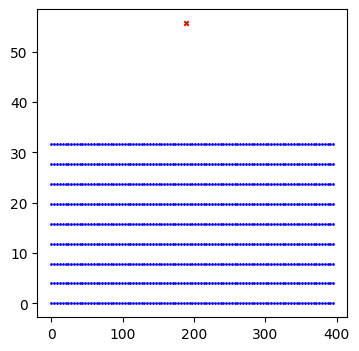

Epoch 124/500
Loss: 1.2391860485076904 MeanGrad: [-2.4788920e-09  3.7101515e-08]


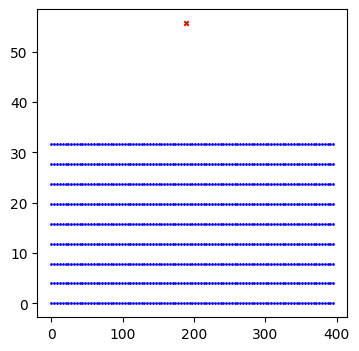

Epoch 125/500
Loss: 1.2391859292984009 MeanGrad: [7.785494e-09 3.511776e-08]


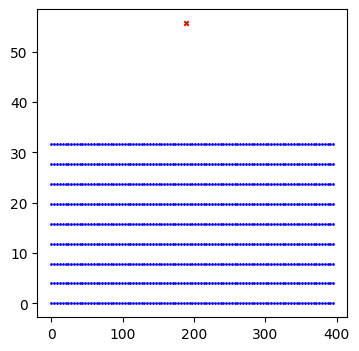

Epoch 126/500
Loss: 1.2391858100891113 MeanGrad: [9.099441e-09 8.217309e-08]


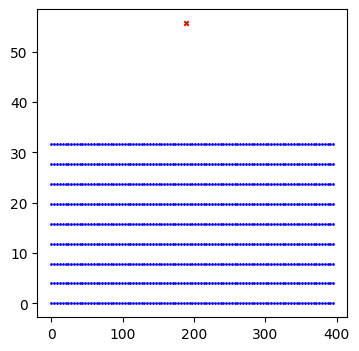

Epoch 127/500
Loss: 1.2391860485076904 MeanGrad: [-1.3660859e-08  3.7526227e-08]


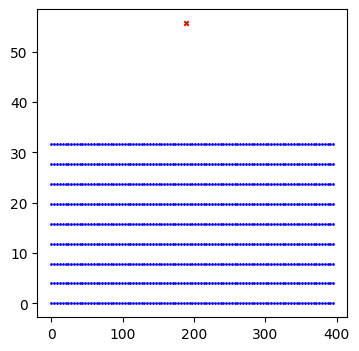

Epoch 128/500
Loss: 1.2391860485076904 MeanGrad: [-3.9297121e-09  2.7918627e-08]


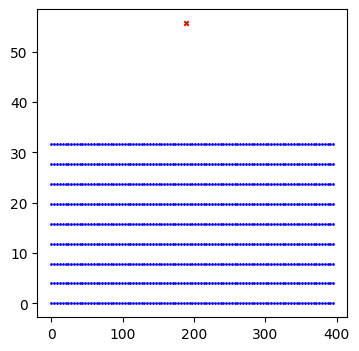

Epoch 129/500
Loss: 1.2391858100891113 MeanGrad: [1.7956550e-09 9.6186994e-08]


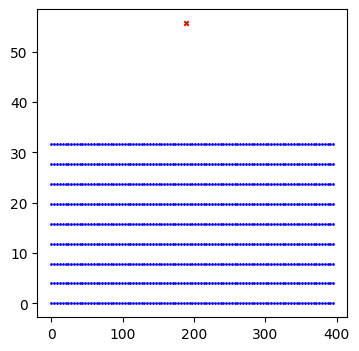

Epoch 130/500
Loss: 1.2391859292984009 MeanGrad: [-1.3814323e-08  5.4992096e-08]


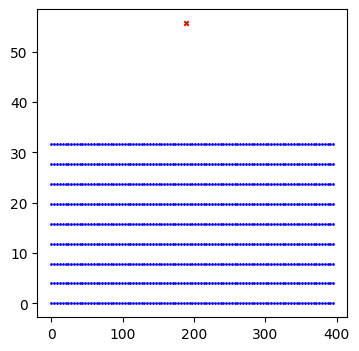

Epoch 131/500
Loss: 1.2391859292984009 MeanGrad: [2.2058755e-09 3.9224830e-08]


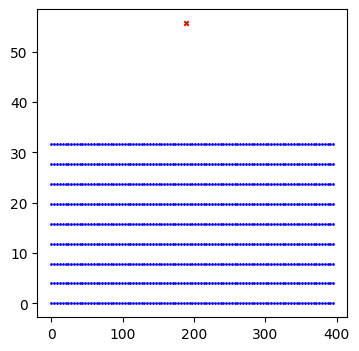

Epoch 132/500
Loss: 1.2391859292984009 MeanGrad: [-1.1620325e-08  4.3053351e-08]


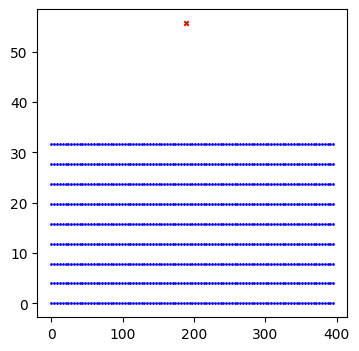

Epoch 133/500
Loss: 1.23918616771698 MeanGrad: [5.1473985e-09 2.8812895e-08]


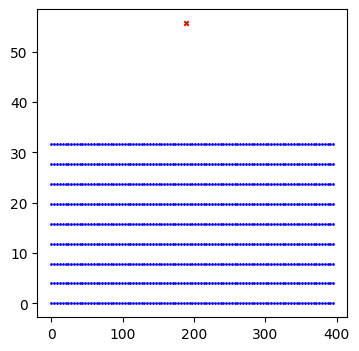

Epoch 134/500
Loss: 1.2391856908798218 MeanGrad: [-1.1636003e-09  1.0799430e-07]


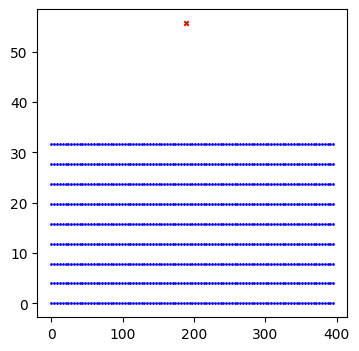

Epoch 135/500
Loss: 1.2391859292984009 MeanGrad: [-1.2683543e-08  5.5498166e-08]


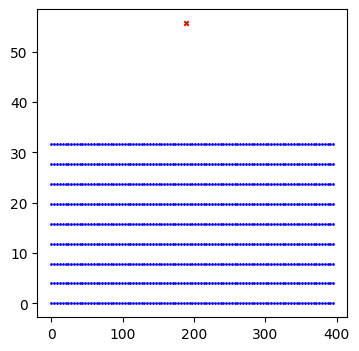

Epoch 136/500
Loss: 1.2391859292984009 MeanGrad: [-2.1283904e-10  6.7460867e-08]


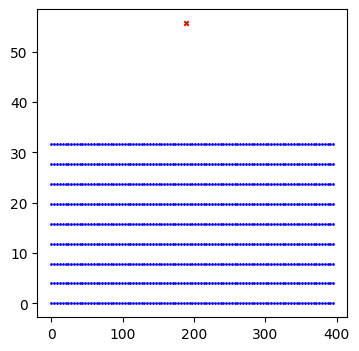

Epoch 137/500
Loss: 1.2391858100891113 MeanGrad: [-9.2857348e-09  6.6484446e-08]


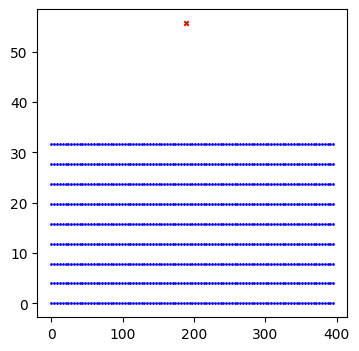

Epoch 138/500
Loss: 1.2391858100891113 MeanGrad: [-5.9654810e-09  7.6442234e-08]


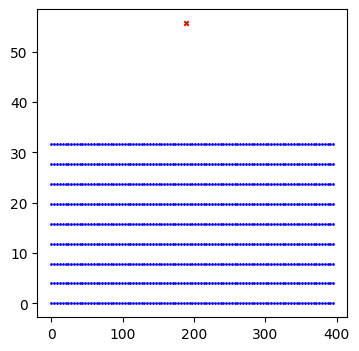

Epoch 139/500
Loss: 1.2391860485076904 MeanGrad: [1.3788575e-09 2.5686504e-08]


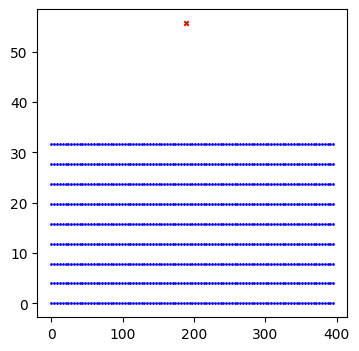

Epoch 140/500
Loss: 1.2391856908798218 MeanGrad: [-3.33930616e-09  1.18598884e-07]


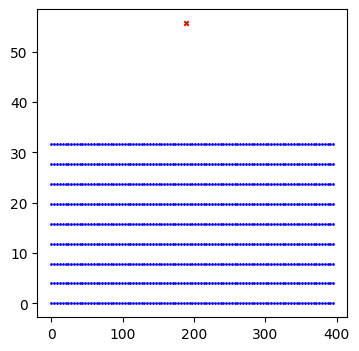

Epoch 141/500
Loss: 1.2391860485076904 MeanGrad: [6.6918773e-09 4.7280434e-08]


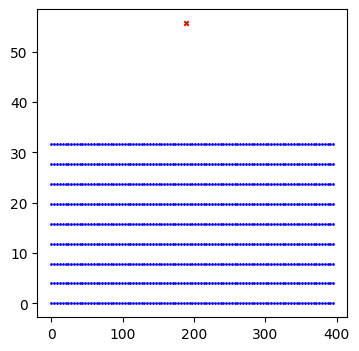

Epoch 142/500
Loss: 1.2391858100891113 MeanGrad: [-2.6924134e-09  6.3217698e-08]


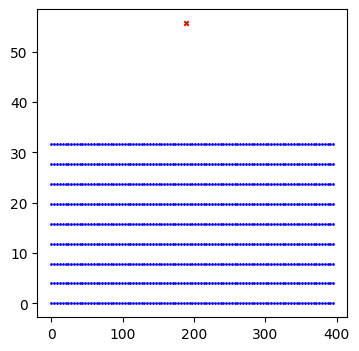

Epoch 143/500
Loss: 1.2391859292984009 MeanGrad: [-8.676253e-09  6.703746e-08]


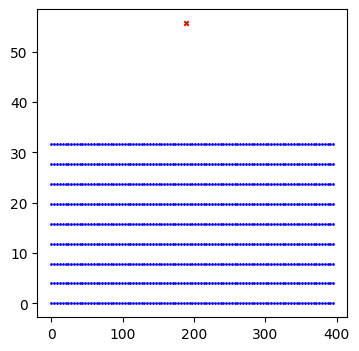

Epoch 144/500
Loss: 1.2391860485076904 MeanGrad: [3.4088004e-09 5.9700390e-08]


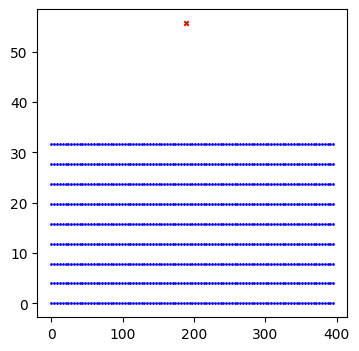

Epoch 145/500
Loss: 1.2391860485076904 MeanGrad: [-5.4967786e-10  3.0322177e-08]


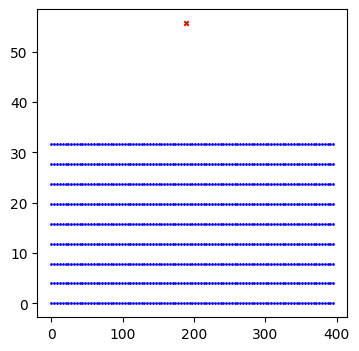

Epoch 146/500
Loss: 1.2391859292984009 MeanGrad: [-3.309703e-09  4.413964e-08]


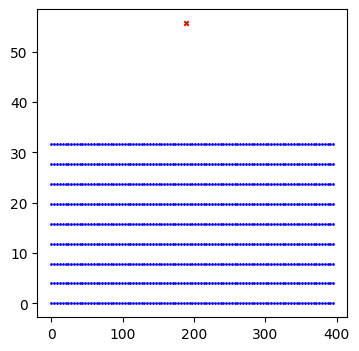

Epoch 147/500
Loss: 1.2391860485076904 MeanGrad: [3.6967474e-09 2.4297240e-08]


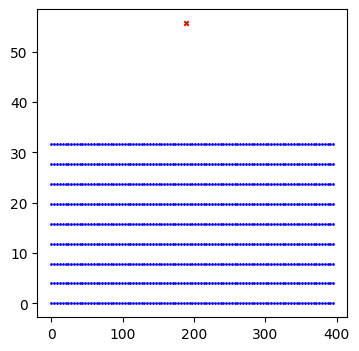

Epoch 148/500
Loss: 1.2391858100891113 MeanGrad: [1.3227613e-08 5.7917724e-08]


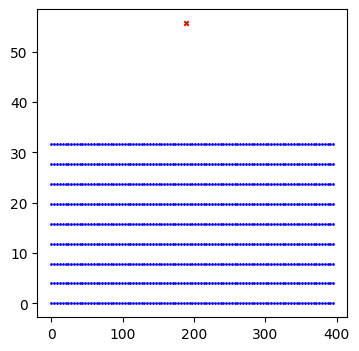

Epoch 149/500
Loss: 1.2391859292984009 MeanGrad: [2.1322075e-09 3.9916429e-08]


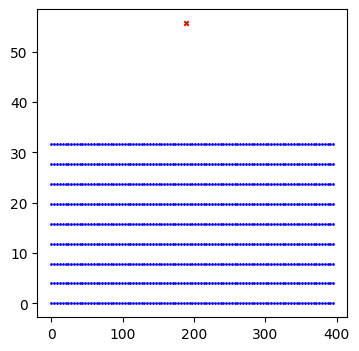

Epoch 150/500
Loss: 1.2391858100891113 MeanGrad: [6.8098327e-09 6.7184075e-08]


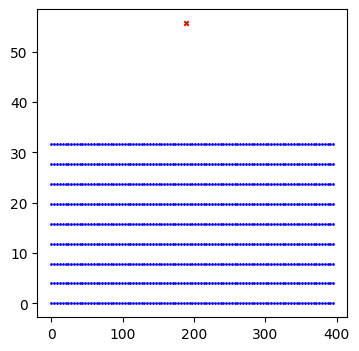

Epoch 151/500
Loss: 1.2391860485076904 MeanGrad: [-3.8798507e-09  2.2423876e-08]


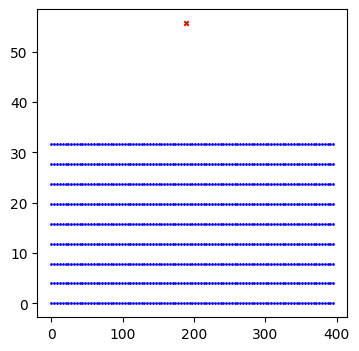

Epoch 152/500
Loss: 1.2391860485076904 MeanGrad: [-4.4740363e-09  1.8043233e-08]


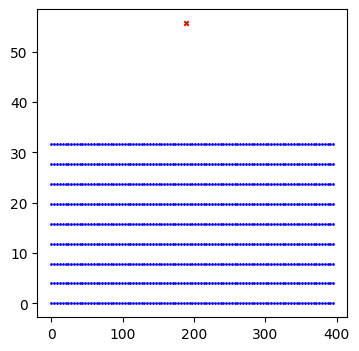

Epoch 153/500
Loss: 1.2391859292984009 MeanGrad: [-5.5591032e-10  4.1369955e-08]


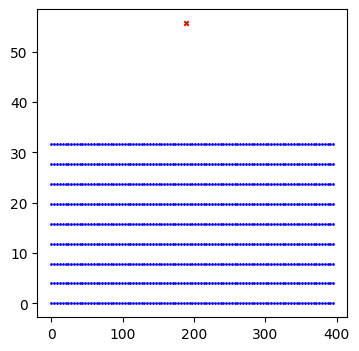

Epoch 154/500
Loss: 1.2391855716705322 MeanGrad: [1.9814328e-08 9.5964779e-08]


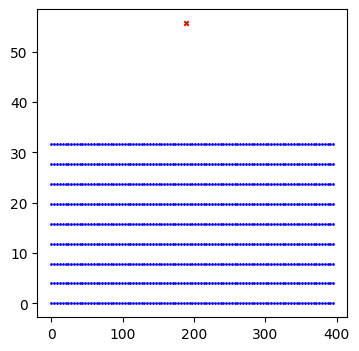

Epoch 155/500
Loss: 1.2391855716705322 MeanGrad: [-3.7867225e-09  1.1761291e-07]


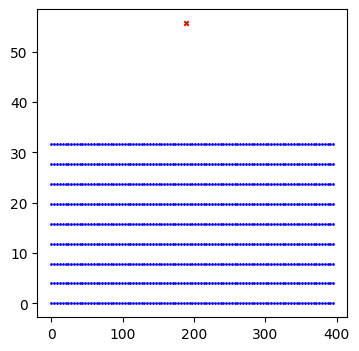

Epoch 156/500
Loss: 1.2391858100891113 MeanGrad: [2.449497e-09 8.790333e-08]


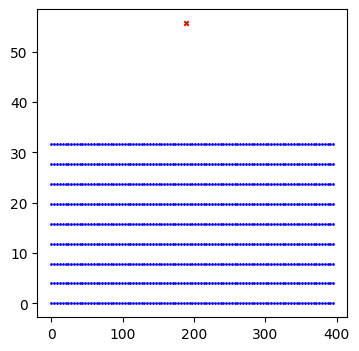

Epoch 157/500
Loss: 1.2391859292984009 MeanGrad: [8.9612096e-09 4.3194383e-08]


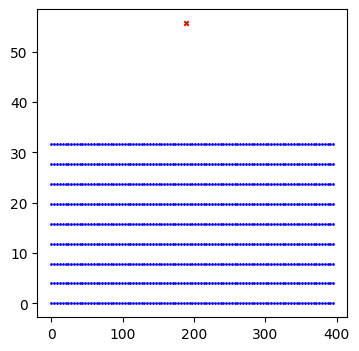

Epoch 158/500
Loss: 1.2391858100891113 MeanGrad: [-1.8880062e-09  8.0537390e-08]


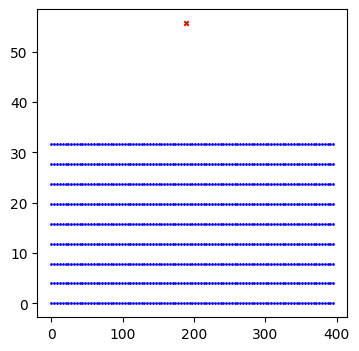

Epoch 159/500
Loss: 1.2391860485076904 MeanGrad: [1.1473986e-09 2.0160869e-08]


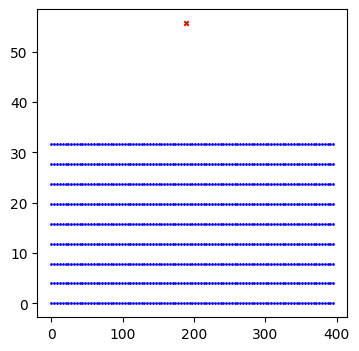

Epoch 160/500
Loss: 1.2391858100891113 MeanGrad: [1.5128728e-09 6.9003434e-08]


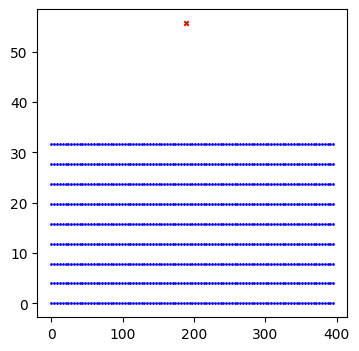

Epoch 161/500
Loss: 1.2391858100891113 MeanGrad: [3.81753251e-09 1.01861026e-07]


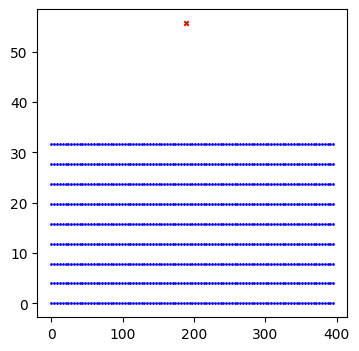

Epoch 162/500
Loss: 1.2391858100891113 MeanGrad: [-3.3389929e-09  7.8960930e-08]


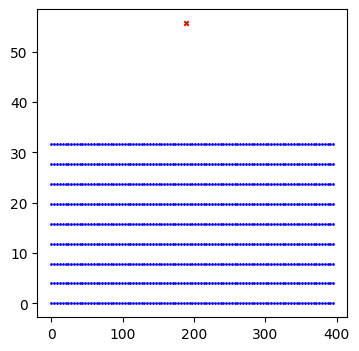

Epoch 163/500
Loss: 1.2391859292984009 MeanGrad: [-8.065115e-09  6.013629e-08]


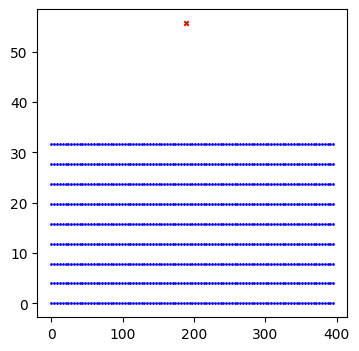

Epoch 164/500
Loss: 1.2391860485076904 MeanGrad: [-1.7787718e-09  3.4579958e-08]


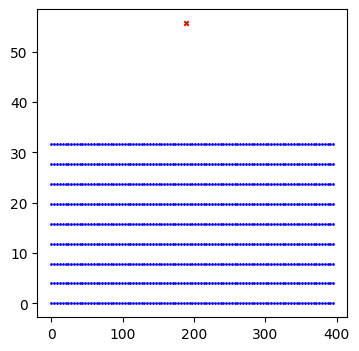

Epoch 165/500
Loss: 1.2391860485076904 MeanGrad: [-5.082610e-09  3.410629e-08]


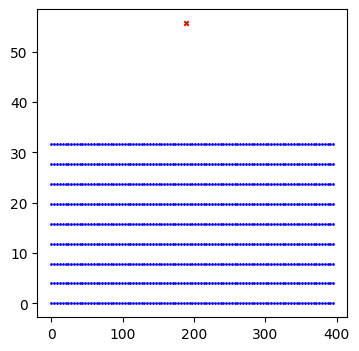

Epoch 166/500
Loss: 1.2391860485076904 MeanGrad: [-7.998000e-09  3.827839e-08]


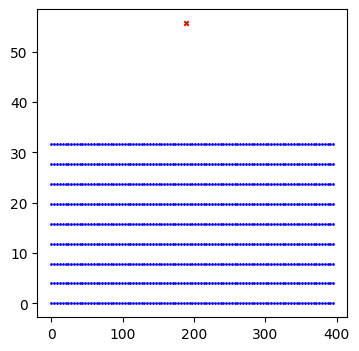

Epoch 167/500
Loss: 1.2391859292984009 MeanGrad: [-1.0062202e-08  6.8267994e-08]


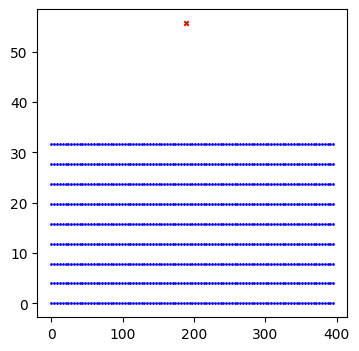

Epoch 168/500
Loss: 1.2391859292984009 MeanGrad: [4.9185789e-09 5.2817217e-08]


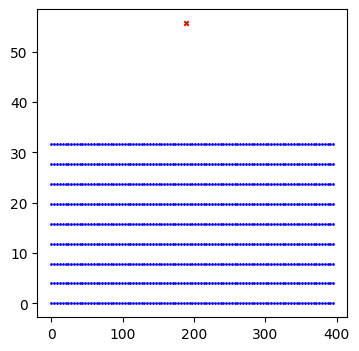

Epoch 169/500
Loss: 1.2391859292984009 MeanGrad: [2.6535307e-09 8.1664794e-08]


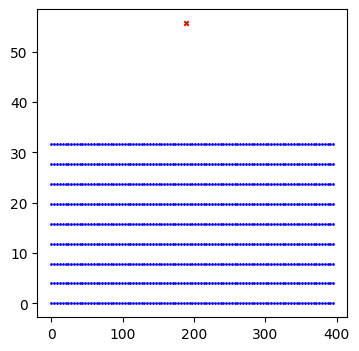

Epoch 170/500
Loss: 1.2391859292984009 MeanGrad: [9.8311812e-09 4.0716696e-08]


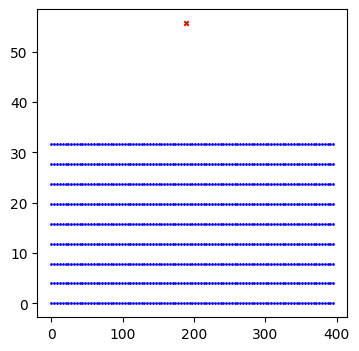

Epoch 171/500
Loss: 1.2391860485076904 MeanGrad: [-1.5281885e-09  2.5658021e-08]


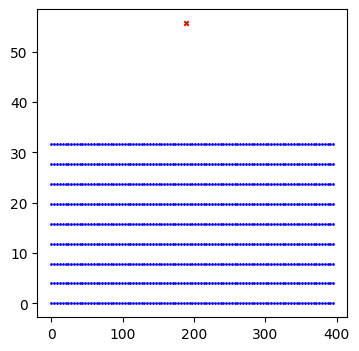

Epoch 172/500
Loss: 1.2391860485076904 MeanGrad: [9.2838688e-09 2.7730788e-08]


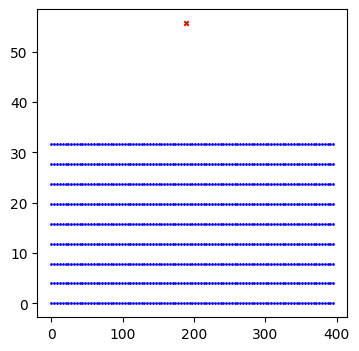

Epoch 173/500
Loss: 1.2391859292984009 MeanGrad: [9.037027e-09 5.699846e-08]


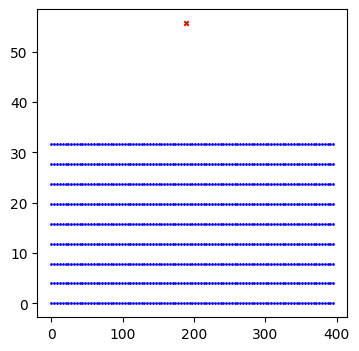

Epoch 174/500
Loss: 1.2391859292984009 MeanGrad: [-6.3380985e-09  6.7562205e-08]


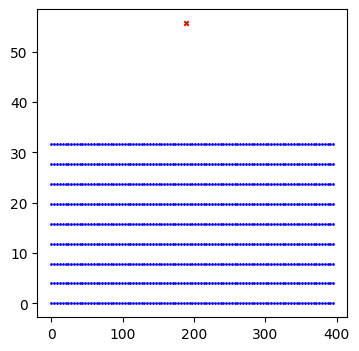

Epoch 175/500
Loss: 1.2391856908798218 MeanGrad: [1.5793027e-08 8.6231829e-08]


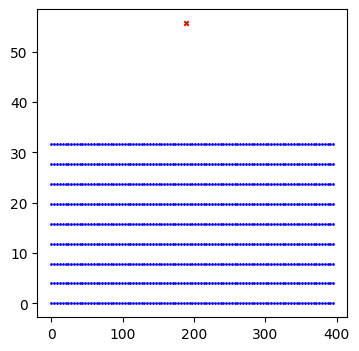

Epoch 176/500
Loss: 1.2391859292984009 MeanGrad: [-6.6710535e-09  7.9198657e-08]


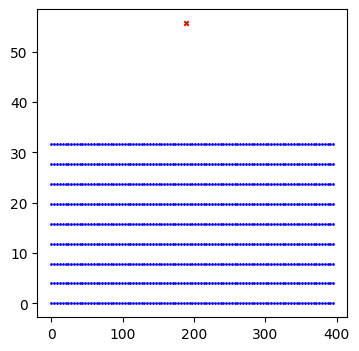

Epoch 177/500
Loss: 1.2391858100891113 MeanGrad: [7.527334e-09 6.787374e-08]


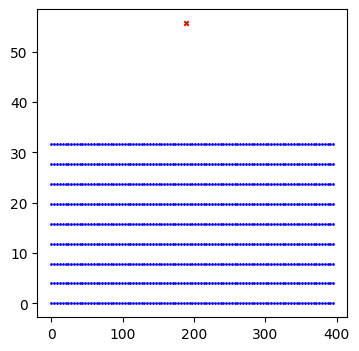

Epoch 178/500
Loss: 1.2391856908798218 MeanGrad: [-2.6095650e-08  8.8972655e-08]


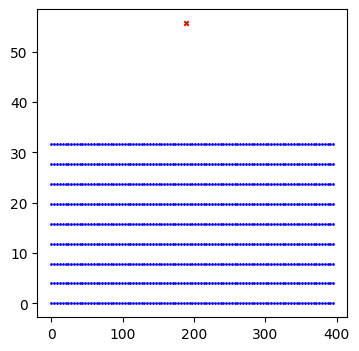

Epoch 179/500
Loss: 1.2391858100891113 MeanGrad: [9.5508037e-09 1.0250686e-07]


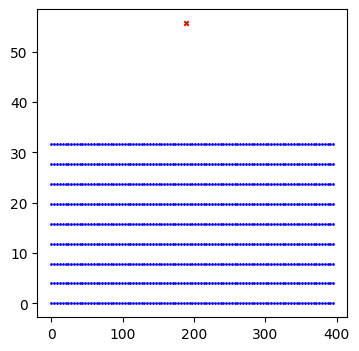

Epoch 180/500
Loss: 1.2391858100891113 MeanGrad: [4.6970294e-09 5.2444079e-08]


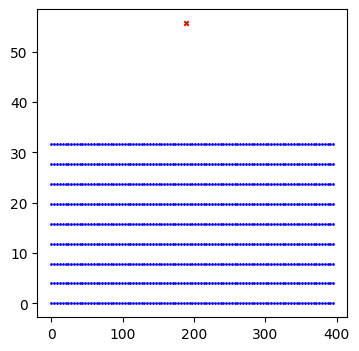

Epoch 181/500
Loss: 1.2391858100891113 MeanGrad: [-1.9667890e-08  8.6521695e-08]


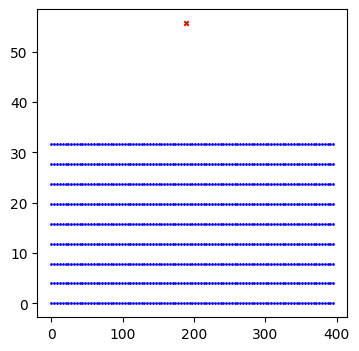

Epoch 182/500
Loss: 1.2391858100891113 MeanGrad: [-7.350629e-09  7.786543e-08]


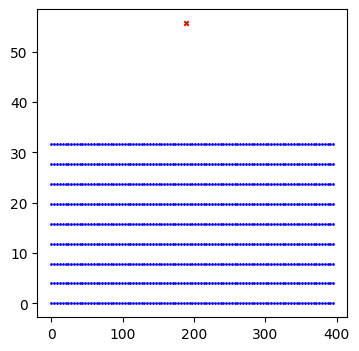

Epoch 183/500
Loss: 1.2391860485076904 MeanGrad: [1.0935675e-08 2.7157247e-08]


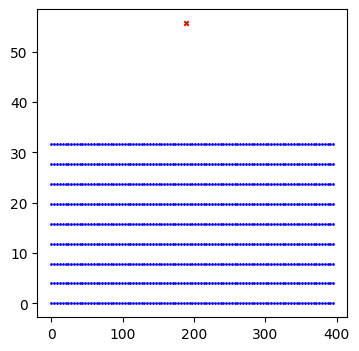

Epoch 184/500
Loss: 1.2391860485076904 MeanGrad: [5.0239424e-10 5.5759195e-08]


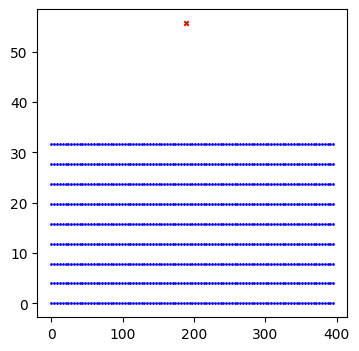

Epoch 185/500
Loss: 1.2391858100891113 MeanGrad: [2.7974503e-09 6.0169050e-08]


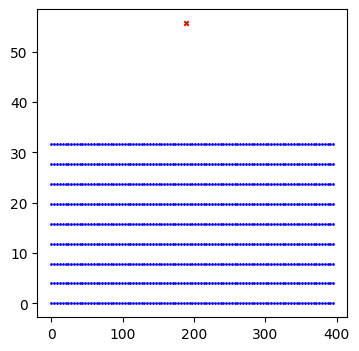

Epoch 186/500
Loss: 1.2391858100891113 MeanGrad: [-1.4488435e-10  5.1503196e-08]


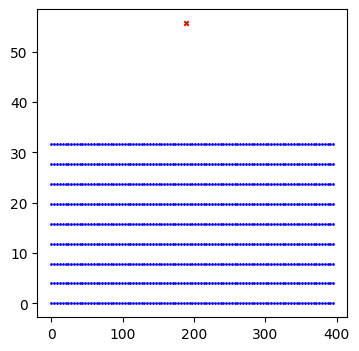

Epoch 187/500
Loss: 1.2391858100891113 MeanGrad: [-8.155646e-09  8.524924e-08]


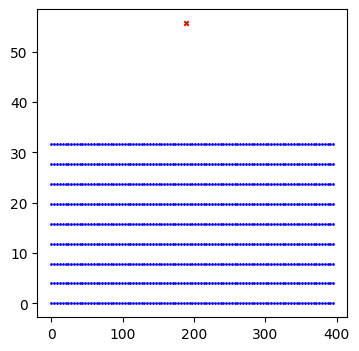

Epoch 188/500
Loss: 1.2391860485076904 MeanGrad: [1.1824213e-09 3.1549185e-08]


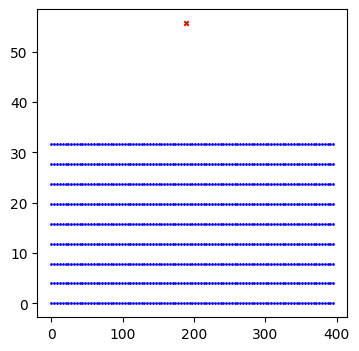

Epoch 189/500
Loss: 1.2391854524612427 MeanGrad: [-1.3623872e-08  1.4039156e-07]


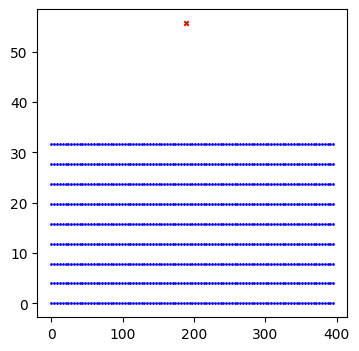

Epoch 190/500
Loss: 1.2391860485076904 MeanGrad: [-3.4544327e-09  3.7210647e-08]


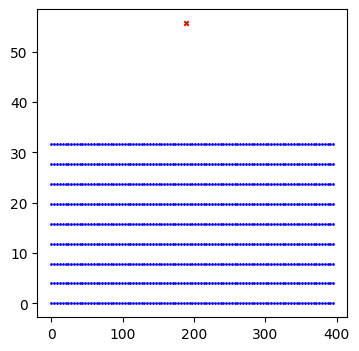

Epoch 191/500
Loss: 1.2391859292984009 MeanGrad: [-8.790096e-09  6.646725e-08]


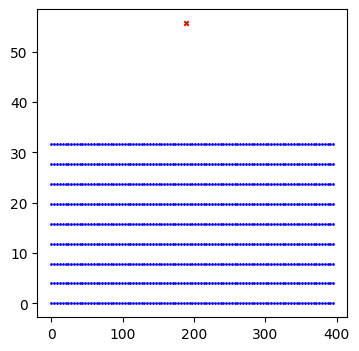

Epoch 192/500
Loss: 1.2391860485076904 MeanGrad: [-5.616267e-10  3.045254e-08]


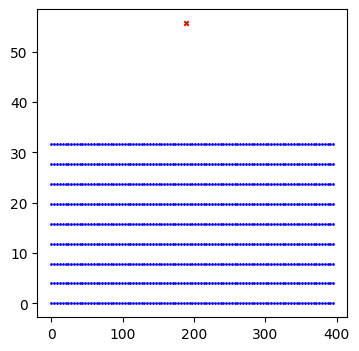

Epoch 193/500
Loss: 1.2391860485076904 MeanGrad: [6.5715424e-09 3.6741621e-08]


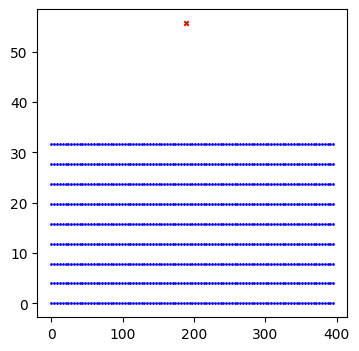

Epoch 194/500
Loss: 1.2391859292984009 MeanGrad: [5.7201763e-09 4.9493519e-08]


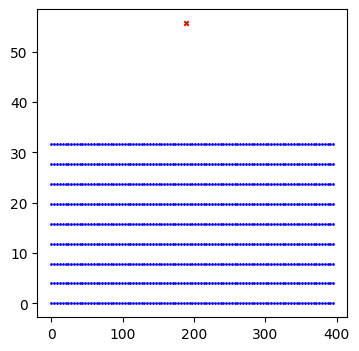

Epoch 195/500
Loss: 1.2391856908798218 MeanGrad: [-5.014356e-09  7.384000e-08]


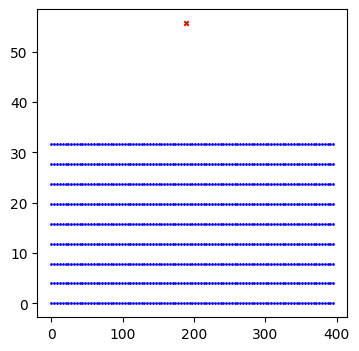

Epoch 196/500
Loss: 1.2391856908798218 MeanGrad: [1.7058783e-08 9.0564534e-08]


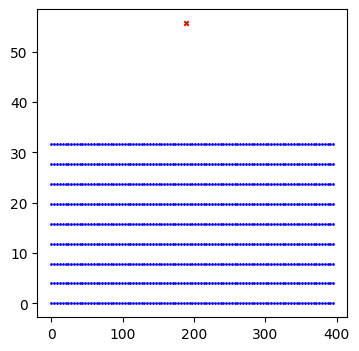

Epoch 197/500
Loss: 1.2391860485076904 MeanGrad: [-8.5926182e-09  4.2653163e-08]


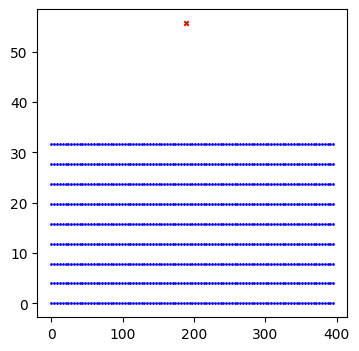

Epoch 198/500
Loss: 1.2391858100891113 MeanGrad: [-3.6237076e-09  5.2088016e-08]


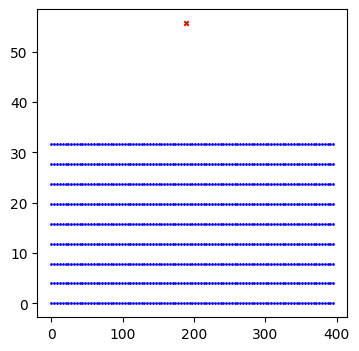

Epoch 199/500
Loss: 1.2391858100891113 MeanGrad: [1.3761340e-08 6.4663865e-08]


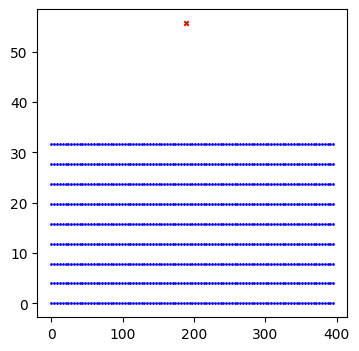

Epoch 200/500
Loss: 1.2391859292984009 MeanGrad: [-2.3778091e-10  4.7502727e-08]


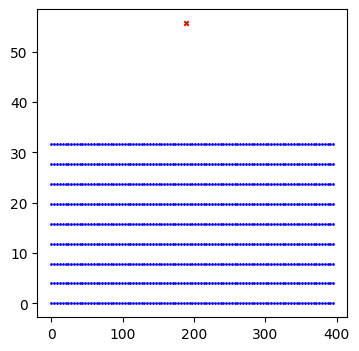

Epoch 201/500
Loss: 1.2391860485076904 MeanGrad: [-5.074299e-09  4.565203e-08]


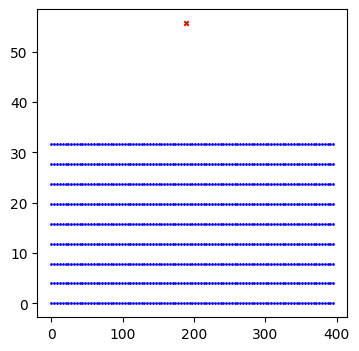

Epoch 202/500
Loss: 1.2391858100891113 MeanGrad: [3.5500891e-09 5.5338845e-08]


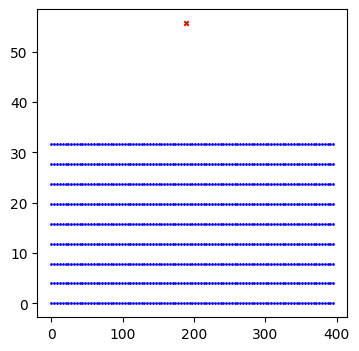

Epoch 203/500
Loss: 1.2391859292984009 MeanGrad: [1.6127284e-08 5.2373732e-08]


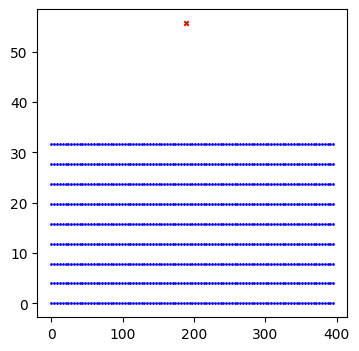

Epoch 204/500
Loss: 1.23918616771698 MeanGrad: [6.7778022e-10 1.6711585e-08]


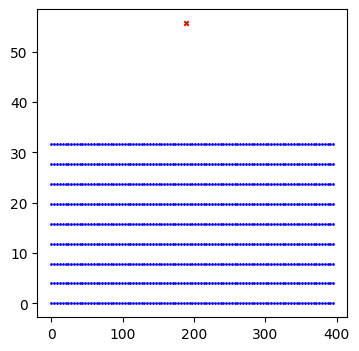

Epoch 205/500
Loss: 1.2391856908798218 MeanGrad: [-2.0062865e-09  1.0077234e-07]


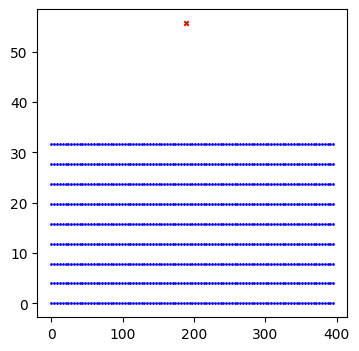

Epoch 206/500
Loss: 1.2391859292984009 MeanGrad: [-9.710939e-10  5.694804e-08]


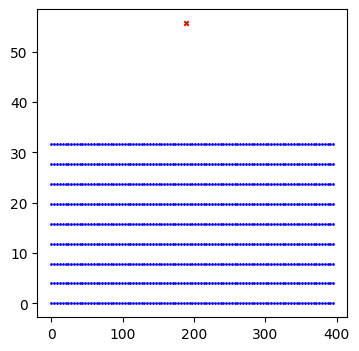

Epoch 207/500
Loss: 1.2391859292984009 MeanGrad: [3.0812147e-10 7.4615976e-08]


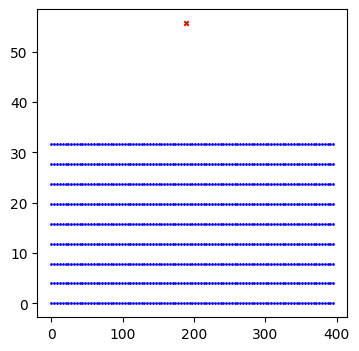

Epoch 208/500
Loss: 1.2391858100891113 MeanGrad: [1.360551e-09 6.409830e-08]


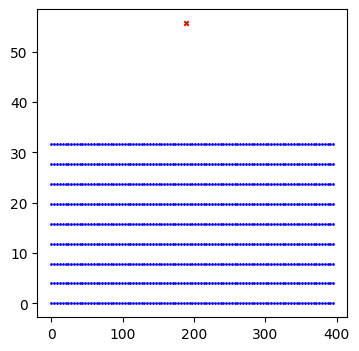

Epoch 209/500
Loss: 1.2391860485076904 MeanGrad: [4.0434589e-09 1.9129295e-08]


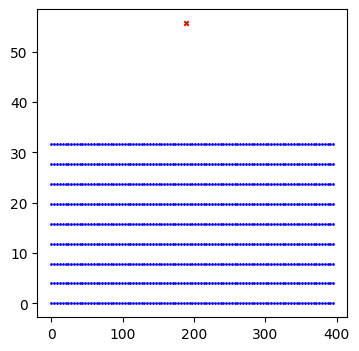

Epoch 210/500
Loss: 1.2391860485076904 MeanGrad: [2.367597e-09 4.129123e-08]


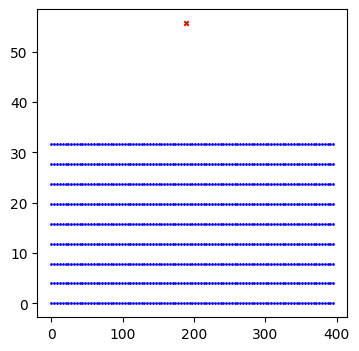

Epoch 211/500
Loss: 1.2391856908798218 MeanGrad: [6.9452741e-09 1.0725513e-07]


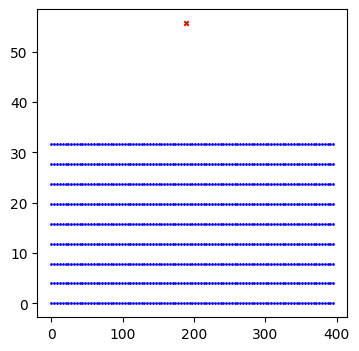

Epoch 212/500
Loss: 1.2391858100891113 MeanGrad: [-2.5305895e-09  7.6680230e-08]


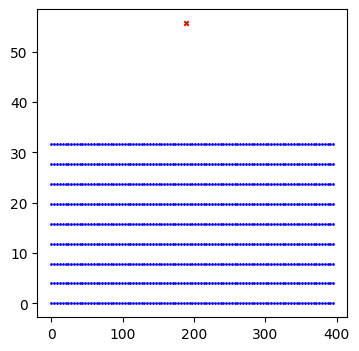

Epoch 213/500
Loss: 1.2391859292984009 MeanGrad: [-1.9973232e-09  3.1794432e-08]


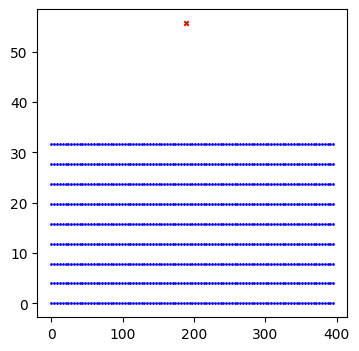

Epoch 214/500
Loss: 1.2391858100891113 MeanGrad: [1.9701978e-09 4.6634533e-08]


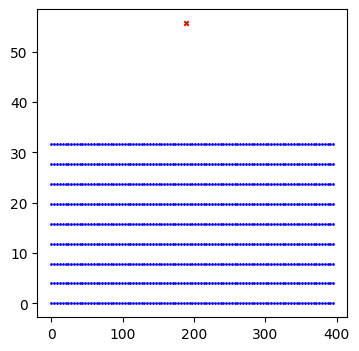

Epoch 215/500
Loss: 1.2391856908798218 MeanGrad: [-5.363078e-09  8.306654e-08]


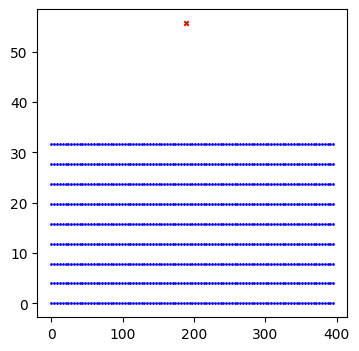

Epoch 216/500
Loss: 1.2391858100891113 MeanGrad: [4.0671626e-09 8.9400160e-08]


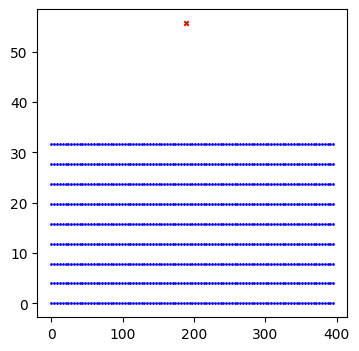

Epoch 217/500
Loss: 1.2391855716705322 MeanGrad: [-2.5298682e-08  1.4585282e-07]


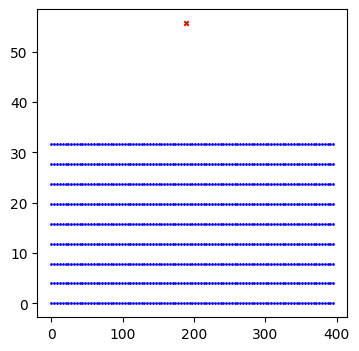

Epoch 218/500
Loss: 1.2391859292984009 MeanGrad: [1.7058062e-08 7.8687393e-08]


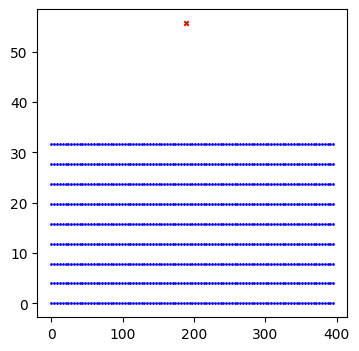

Epoch 219/500
Loss: 1.2391858100891113 MeanGrad: [1.0596771e-09 7.6045310e-08]


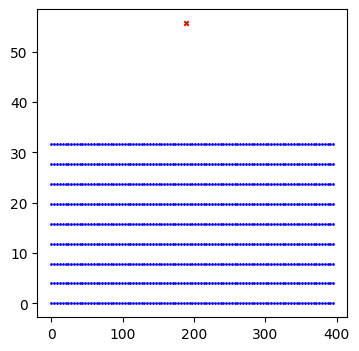

Epoch 220/500
Loss: 1.2391858100891113 MeanGrad: [-1.1612578e-09  6.7375616e-08]


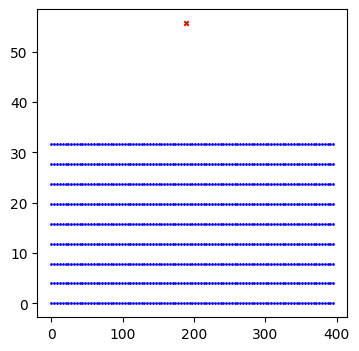

Epoch 221/500
Loss: 1.2391858100891113 MeanGrad: [2.8379872e-09 9.3850652e-08]


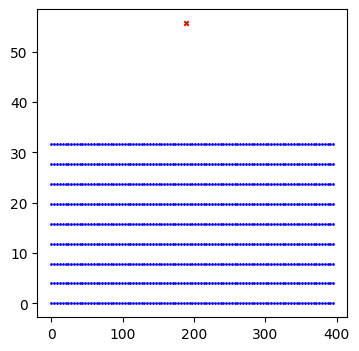

Epoch 222/500
Loss: 1.2391859292984009 MeanGrad: [-9.205761e-09  5.986792e-08]


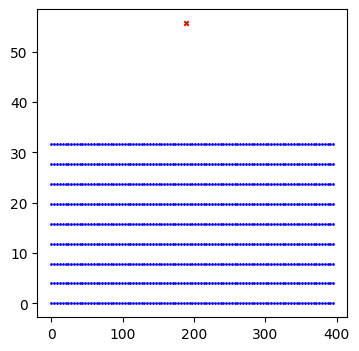

Epoch 223/500
Loss: 1.2391858100891113 MeanGrad: [-1.1125878e-09  9.8336677e-08]


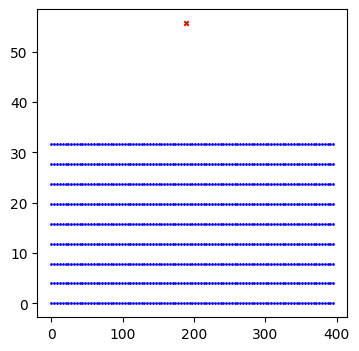

Epoch 224/500
Loss: 1.2391858100891113 MeanGrad: [2.5116540e-09 7.4472226e-08]


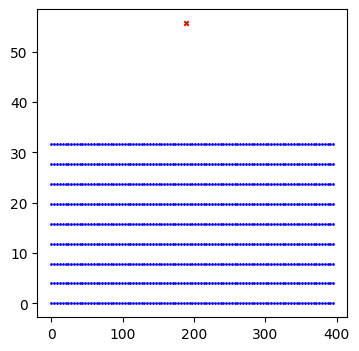

Epoch 225/500
Loss: 1.2391859292984009 MeanGrad: [2.8333458e-09 4.4053348e-08]


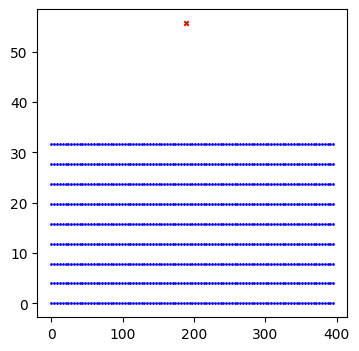

Epoch 226/500
Loss: 1.2391859292984009 MeanGrad: [1.6762989e-09 5.9753162e-08]


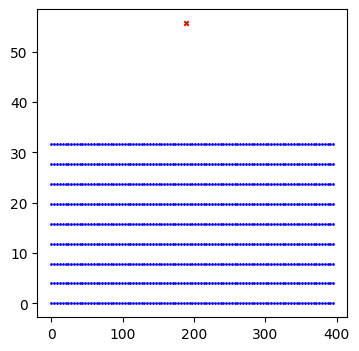

Epoch 227/500
Loss: 1.2391858100891113 MeanGrad: [-1.4199574e-09  7.1730348e-08]


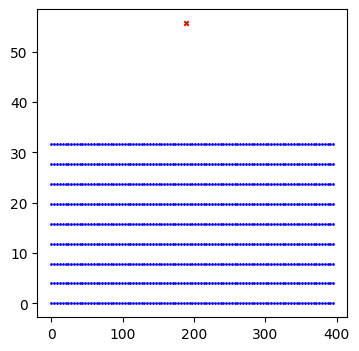

Epoch 228/500
Loss: 1.2391856908798218 MeanGrad: [8.785740e-09 8.521691e-08]


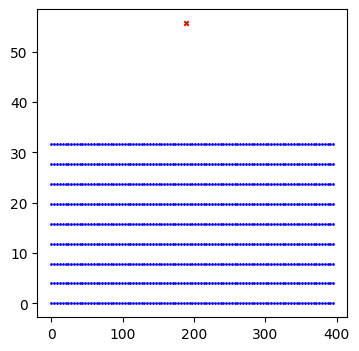

Epoch 229/500
Loss: 1.2391859292984009 MeanGrad: [-1.5228020e-08  4.1798547e-08]


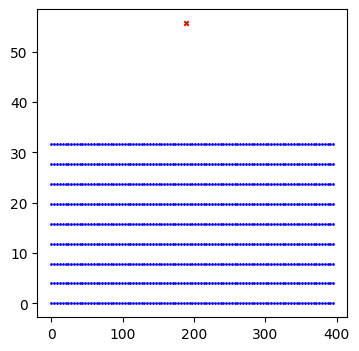

Epoch 230/500
Loss: 1.2391858100891113 MeanGrad: [-6.5917249e-09  7.7325716e-08]


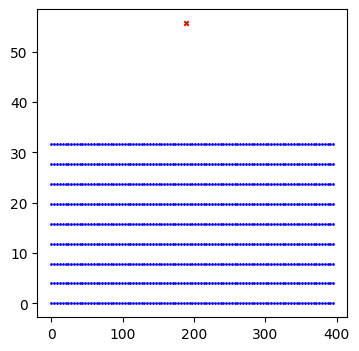

Epoch 231/500
Loss: 1.2391859292984009 MeanGrad: [-2.7856013e-09  5.4578248e-08]


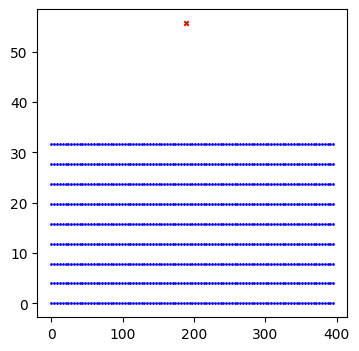

Epoch 232/500
Loss: 1.23918616771698 MeanGrad: [5.3989595e-09 1.9146981e-08]


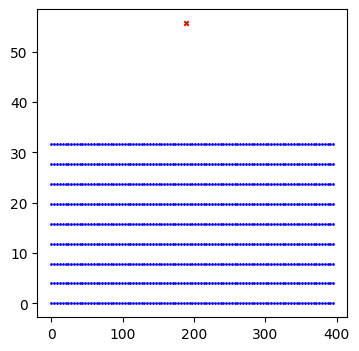

Epoch 233/500
Loss: 1.2391860485076904 MeanGrad: [-7.241077e-09  4.625671e-08]


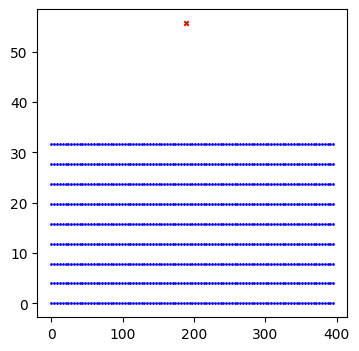

Epoch 234/500
Loss: 1.2391858100891113 MeanGrad: [-1.1080148e-09  5.2812577e-08]


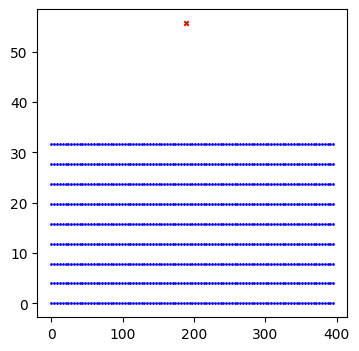

Epoch 235/500
Loss: 1.2391858100891113 MeanGrad: [5.942943e-10 7.418168e-08]


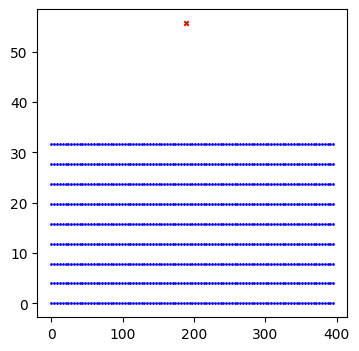

Epoch 236/500
Loss: 1.23918616771698 MeanGrad: [-1.8258483e-09  2.3202659e-08]


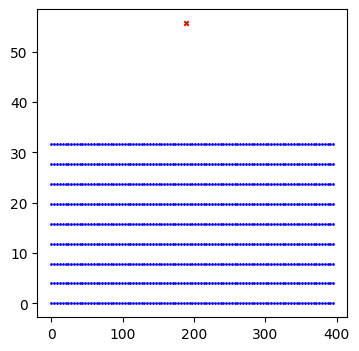

Epoch 237/500
Loss: 1.23918616771698 MeanGrad: [5.9741434e-09 1.9761901e-08]


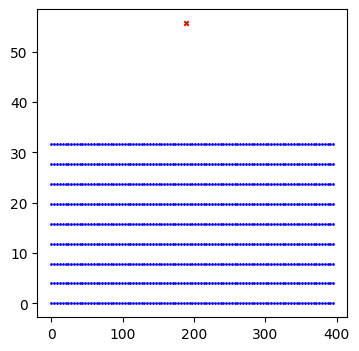

Epoch 238/500
Loss: 1.2391859292984009 MeanGrad: [-9.1500034e-09  4.6906145e-08]


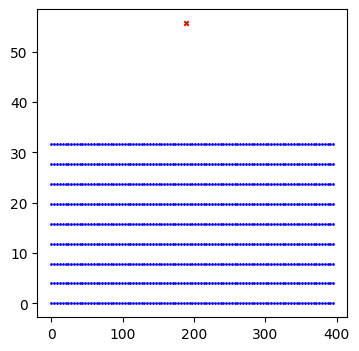

Epoch 239/500
Loss: 1.2391858100891113 MeanGrad: [-5.045969e-10  6.015728e-08]


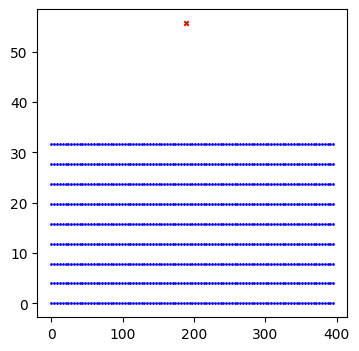

Epoch 240/500
Loss: 1.2391858100891113 MeanGrad: [8.741884e-09 8.656339e-08]


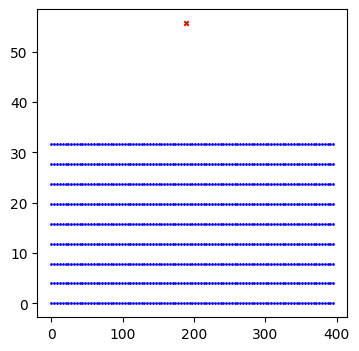

Epoch 241/500
Loss: 1.2391858100891113 MeanGrad: [-6.4639241e-09  7.1820736e-08]


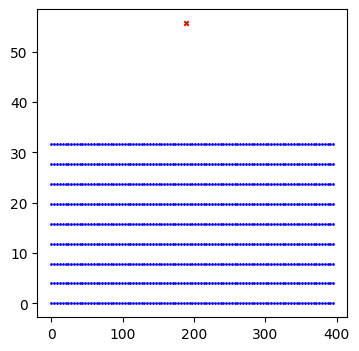

Epoch 242/500
Loss: 1.2391856908798218 MeanGrad: [9.6861075e-11 8.2515726e-08]


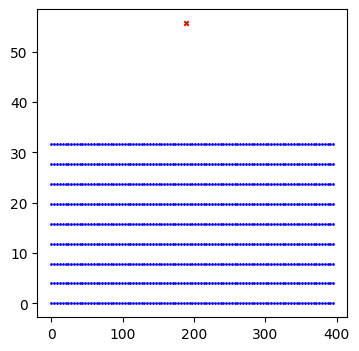

Epoch 243/500
Loss: 1.2391858100891113 MeanGrad: [8.120168e-09 7.430717e-08]


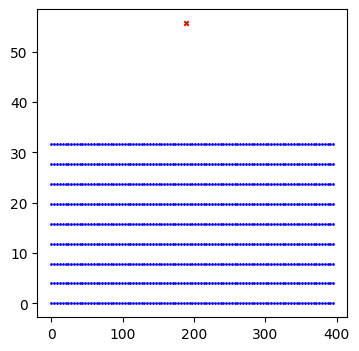

Epoch 244/500
Loss: 1.2391860485076904 MeanGrad: [-2.5017113e-09  3.2063230e-08]


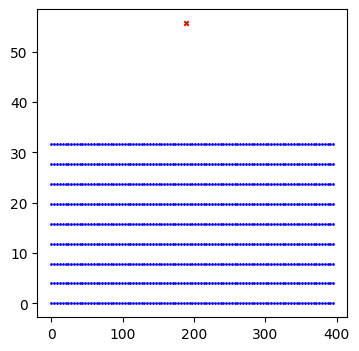

Epoch 245/500
Loss: 1.2391860485076904 MeanGrad: [-2.8016638e-09  3.9725656e-08]


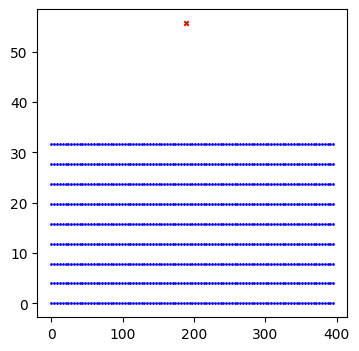

Epoch 246/500
Loss: 1.2391858100891113 MeanGrad: [-8.1122327e-09  6.9015805e-08]


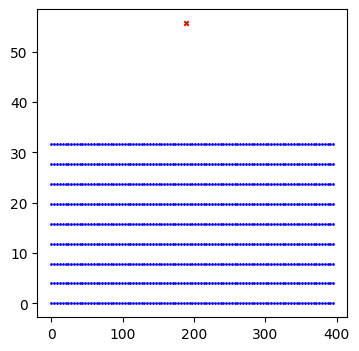

Epoch 247/500
Loss: 1.2391860485076904 MeanGrad: [6.3958843e-09 2.6876203e-08]


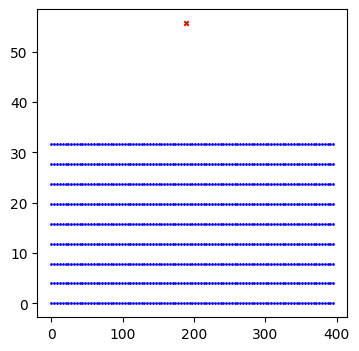

Epoch 248/500
Loss: 1.23918616771698 MeanGrad: [2.9420586e-09 2.9905433e-08]


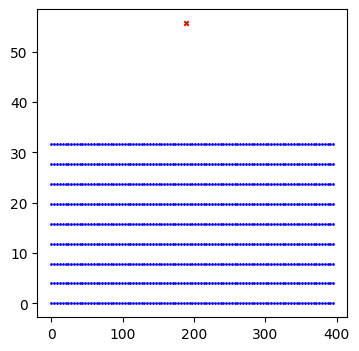

Epoch 249/500
Loss: 1.2391858100891113 MeanGrad: [-5.4653757e-09  6.0595752e-08]


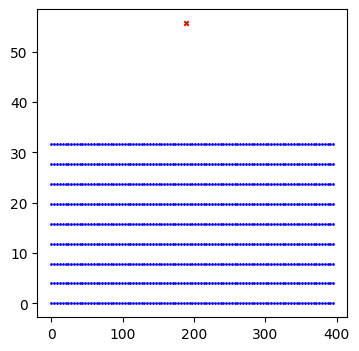

Epoch 250/500
Loss: 1.2391860485076904 MeanGrad: [-2.7683109e-09  1.4735045e-08]


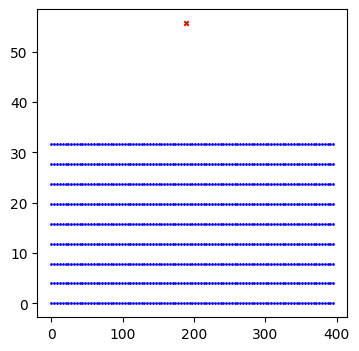

Epoch 251/500
Loss: 1.2391860485076904 MeanGrad: [-1.5431703e-09  2.1163853e-08]


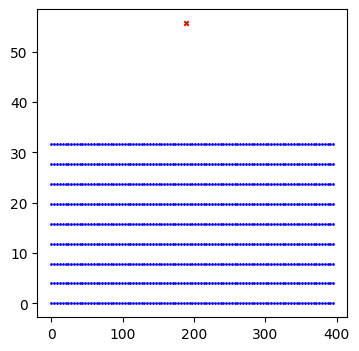

Epoch 252/500
Loss: 1.2391858100891113 MeanGrad: [4.8910515e-10 5.3319212e-08]


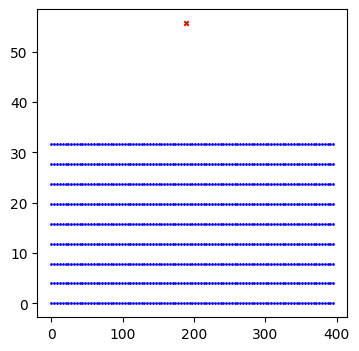

Epoch 253/500
Loss: 1.2391858100891113 MeanGrad: [-9.055945e-09  7.173584e-08]


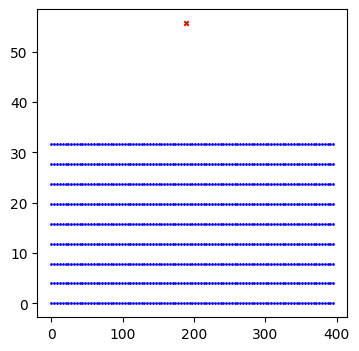

Epoch 254/500
Loss: 1.2391858100891113 MeanGrad: [-4.546910e-09  5.589122e-08]


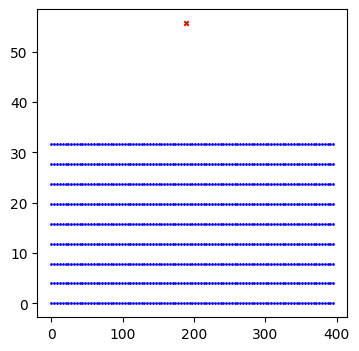

Epoch 255/500
Loss: 1.2391858100891113 MeanGrad: [-4.2946855e-09  7.8616772e-08]


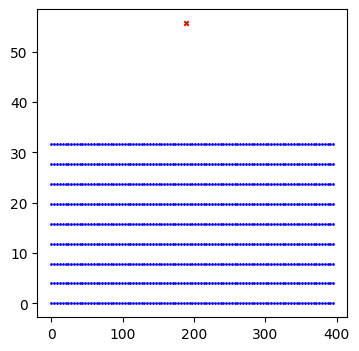

Epoch 256/500
Loss: 1.2391860485076904 MeanGrad: [-2.3115094e-09  3.4442341e-08]


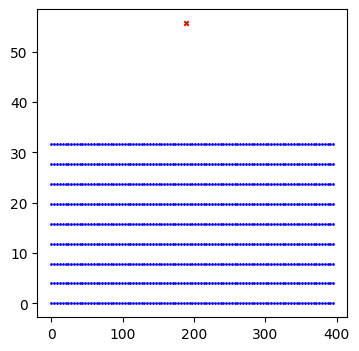

Epoch 257/500
Loss: 1.2391858100891113 MeanGrad: [2.0231652e-09 7.7231419e-08]


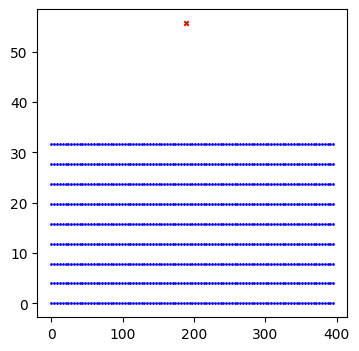

Epoch 258/500
Loss: 1.2391858100891113 MeanGrad: [-7.241418e-09  7.085538e-08]


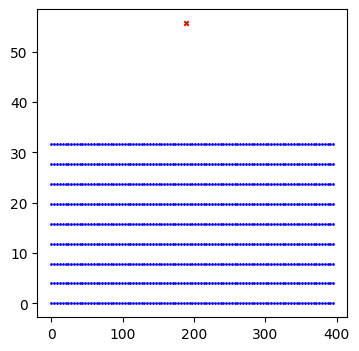

Epoch 259/500
Loss: 1.2391858100891113 MeanGrad: [-3.2956597e-09  5.8094567e-08]


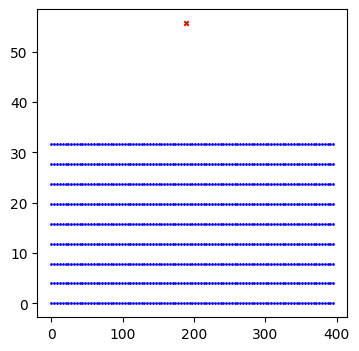

Epoch 260/500
Loss: 1.2391860485076904 MeanGrad: [5.1910818e-09 2.2546855e-08]


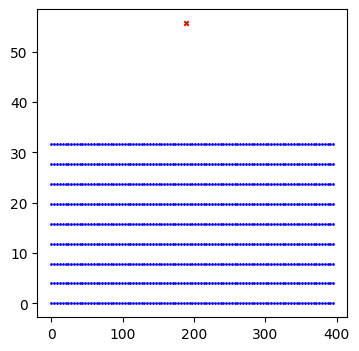

Epoch 261/500
Loss: 1.2391860485076904 MeanGrad: [-1.0142502e-09  2.6389339e-08]


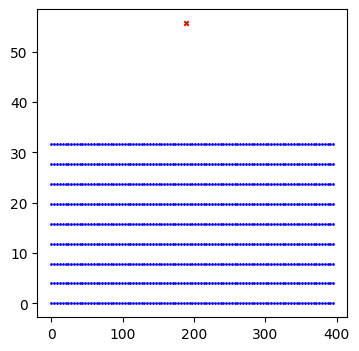

Epoch 262/500
Loss: 1.23918616771698 MeanGrad: [-2.9514541e-10  2.2126617e-08]


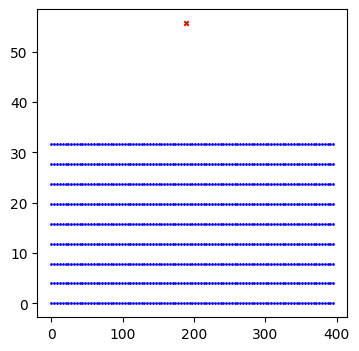

Epoch 263/500
Loss: 1.2391859292984009 MeanGrad: [-1.4930754e-09  4.9665193e-08]


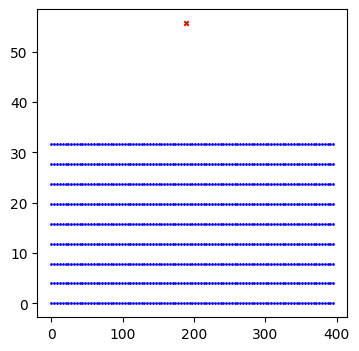

Epoch 264/500
Loss: 1.2391858100891113 MeanGrad: [9.6857296e-09 8.4997424e-08]


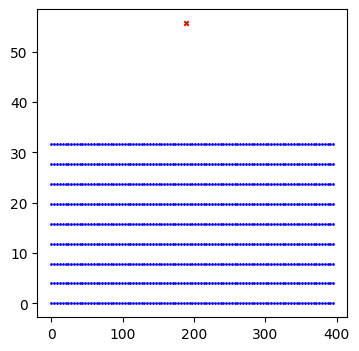

Epoch 265/500
Loss: 1.2391859292984009 MeanGrad: [6.9049380e-09 3.4559108e-08]


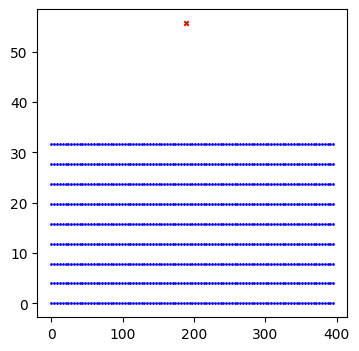

Epoch 266/500
Loss: 1.2391855716705322 MeanGrad: [1.6119804e-08 1.3297498e-07]


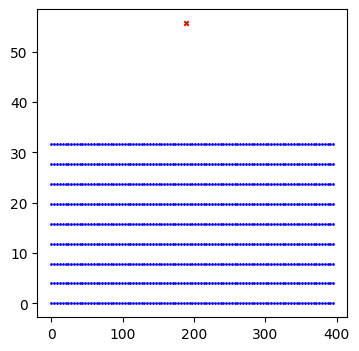

Epoch 267/500
Loss: 1.23918616771698 MeanGrad: [-2.9165170e-09  1.8793035e-08]


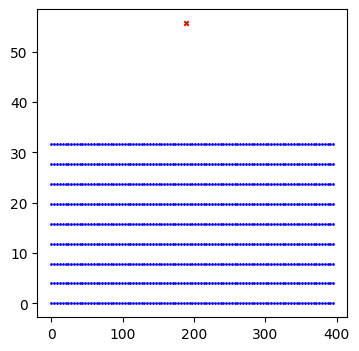

Epoch 268/500
Loss: 1.2391859292984009 MeanGrad: [-1.2771249e-08  5.9040733e-08]


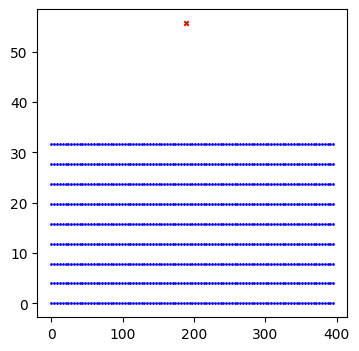

Epoch 269/500
Loss: 1.2391859292984009 MeanGrad: [1.2075128e-08 8.1373742e-08]


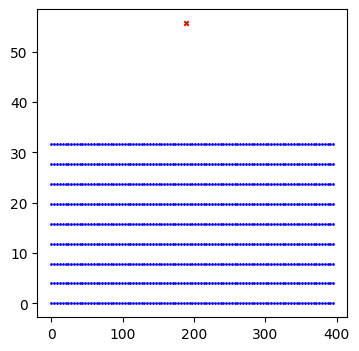

Epoch 270/500
Loss: 1.2391860485076904 MeanGrad: [3.6621510e-09 2.9936345e-08]


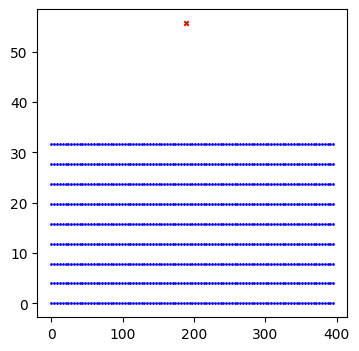

Epoch 271/500
Loss: 1.2391858100891113 MeanGrad: [-1.359449e-08  5.795216e-08]


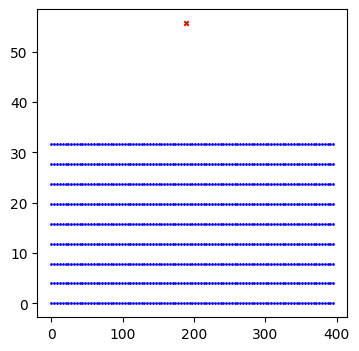

Epoch 272/500
Loss: 1.2391856908798218 MeanGrad: [-1.4147034e-08  7.8818417e-08]


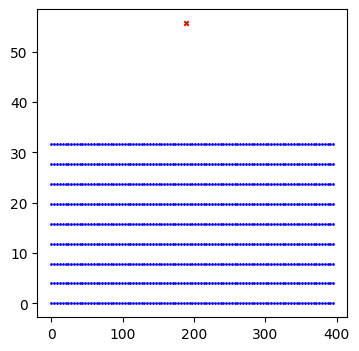

Epoch 273/500
Loss: 1.23918616771698 MeanGrad: [-7.56221641e-10  1.03632605e-08]


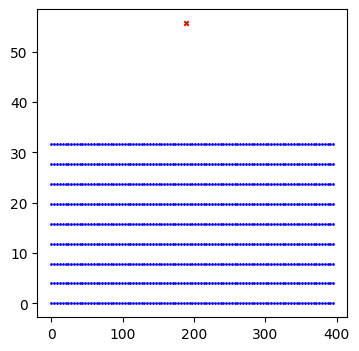

Epoch 274/500
Loss: 1.2391855716705322 MeanGrad: [-1.97777776e-08  1.11063784e-07]


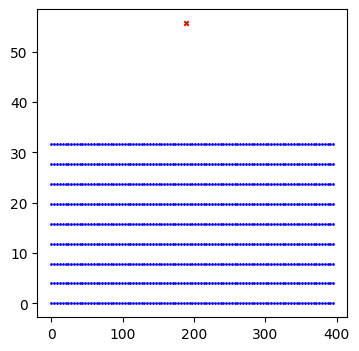

Epoch 275/500
Loss: 1.2391860485076904 MeanGrad: [4.2265098e-09 2.7154824e-08]


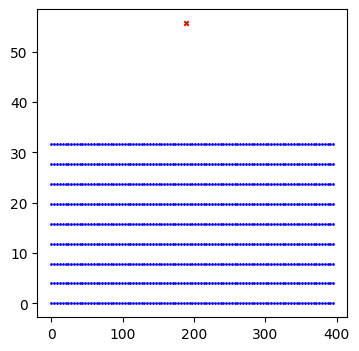

Epoch 276/500
Loss: 1.2391860485076904 MeanGrad: [-1.5211948e-09  2.6285029e-08]


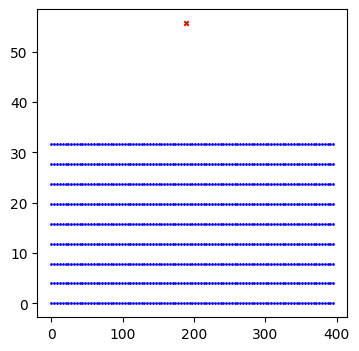

Epoch 277/500
Loss: 1.2391860485076904 MeanGrad: [-3.8216674e-09  4.5819462e-08]


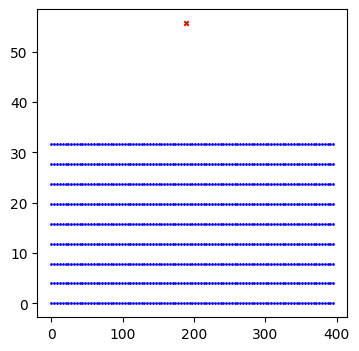

Epoch 278/500
Loss: 1.2391856908798218 MeanGrad: [-1.1204640e-08  1.0859984e-07]


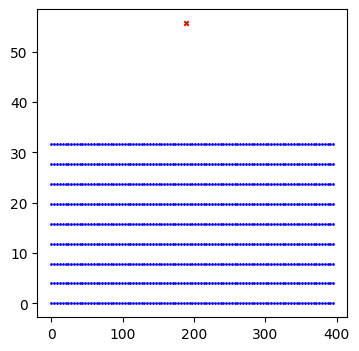

Epoch 279/500
Loss: 1.2391856908798218 MeanGrad: [-6.5160277e-09  7.5630638e-08]


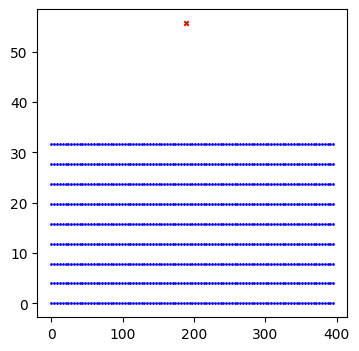

Epoch 280/500
Loss: 1.2391859292984009 MeanGrad: [7.571073e-10 4.816458e-08]


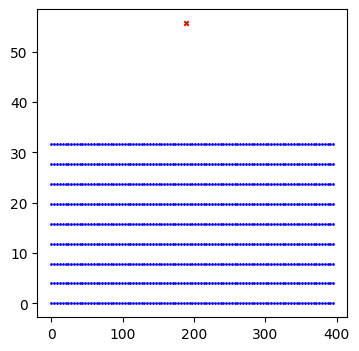

Epoch 281/500
Loss: 1.2391860485076904 MeanGrad: [-3.6389329e-09  3.4469497e-08]


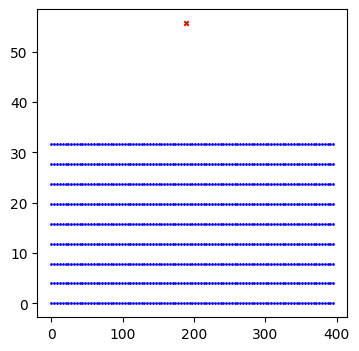

Epoch 282/500
Loss: 1.2391860485076904 MeanGrad: [3.8307455e-09 2.5189507e-08]


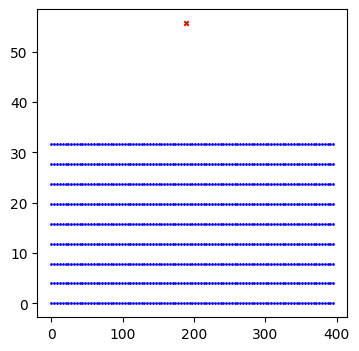

Epoch 283/500
Loss: 1.2391858100891113 MeanGrad: [-7.0216251e-09  4.2778506e-08]


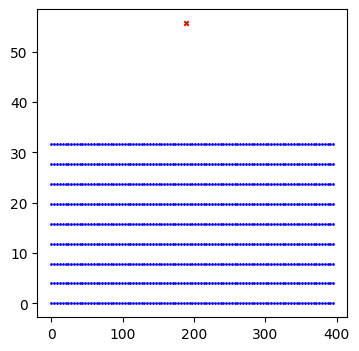

Epoch 284/500
Loss: 1.2391858100891113 MeanGrad: [1.1449883e-09 4.7626926e-08]


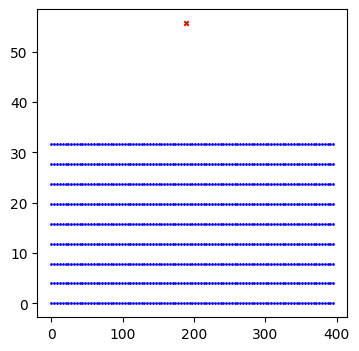

Epoch 285/500
Loss: 1.2391859292984009 MeanGrad: [-6.8569461e-09  5.8833916e-08]


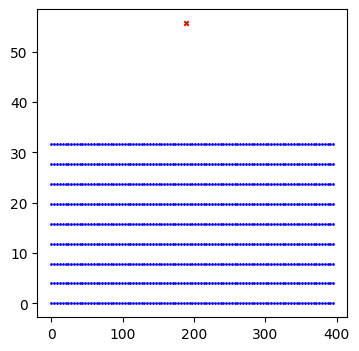

Epoch 286/500
Loss: 1.2391858100891113 MeanGrad: [1.2425801e-08 8.2968228e-08]


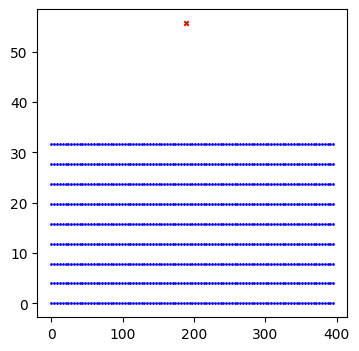

Epoch 287/500
Loss: 1.2391858100891113 MeanGrad: [1.2690506e-09 8.7404658e-08]


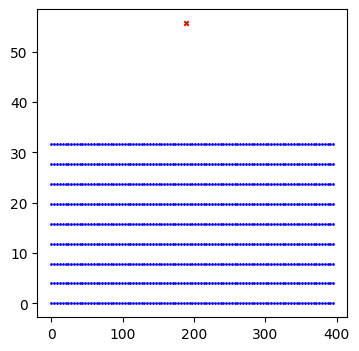

Epoch 288/500
Loss: 1.2391860485076904 MeanGrad: [-7.1172228e-09  5.1794032e-08]


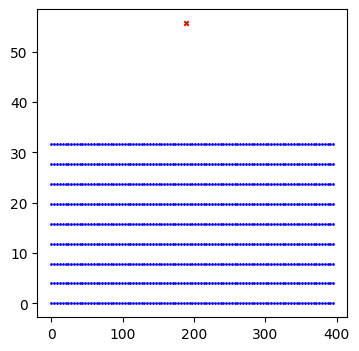

Epoch 289/500
Loss: 1.2391858100891113 MeanGrad: [-1.5288828e-09  6.7600986e-08]


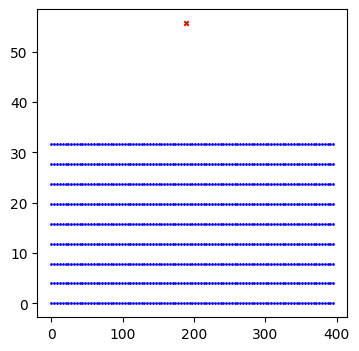

Epoch 290/500
Loss: 1.2391858100891113 MeanGrad: [-2.1816198e-09  7.6217241e-08]


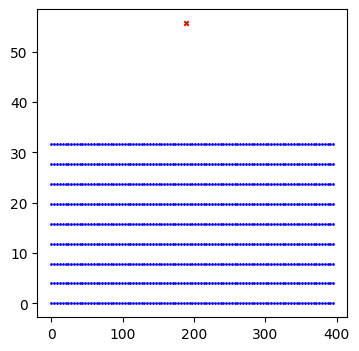

Epoch 291/500
Loss: 1.2391855716705322 MeanGrad: [-4.7399205e-09  1.1773601e-07]


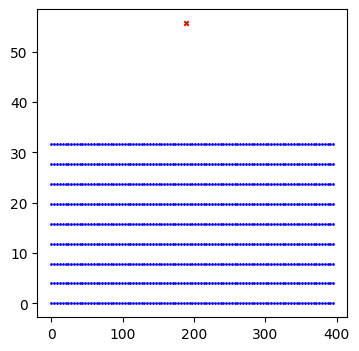

Epoch 292/500
Loss: 1.2391859292984009 MeanGrad: [-1.3163528e-08  4.3102229e-08]


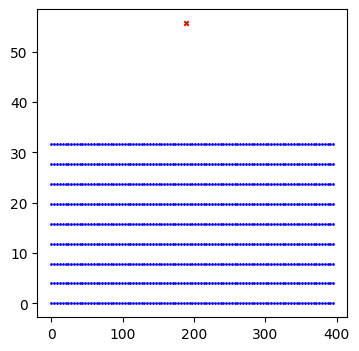

Epoch 293/500
Loss: 1.2391860485076904 MeanGrad: [-6.4495591e-09  3.6984545e-08]


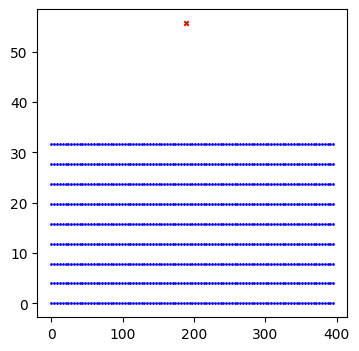

Epoch 294/500
Loss: 1.2391860485076904 MeanGrad: [-1.2096594e-08  4.3226329e-08]


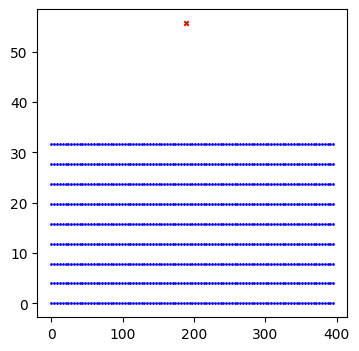

Epoch 295/500
Loss: 1.2391860485076904 MeanGrad: [2.8351419e-09 1.5850283e-08]


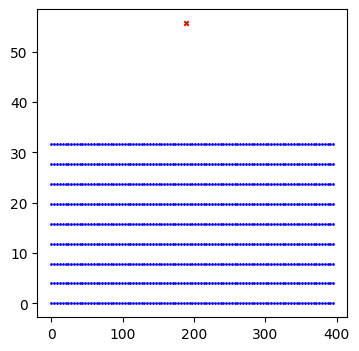

Epoch 296/500
Loss: 1.2391856908798218 MeanGrad: [-9.215141e-09  9.818545e-08]


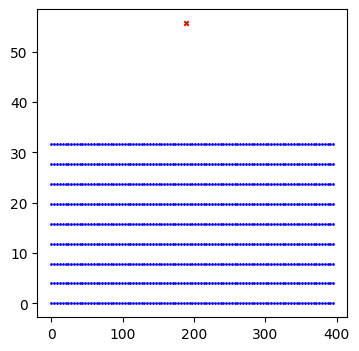

Epoch 297/500
Loss: 1.23918616771698 MeanGrad: [-1.0392160e-08  2.2335769e-08]


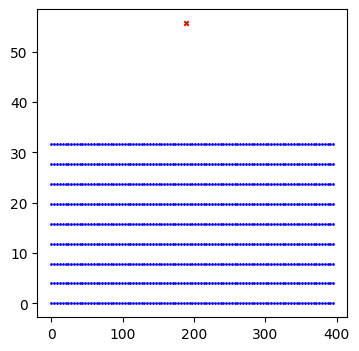

Epoch 298/500
Loss: 1.2391856908798218 MeanGrad: [1.1052312e-09 7.8352421e-08]


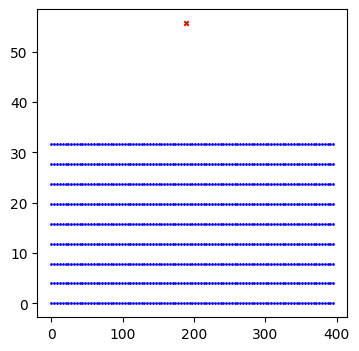

Epoch 299/500
Loss: 1.2391858100891113 MeanGrad: [3.2433241e-09 6.1773925e-08]


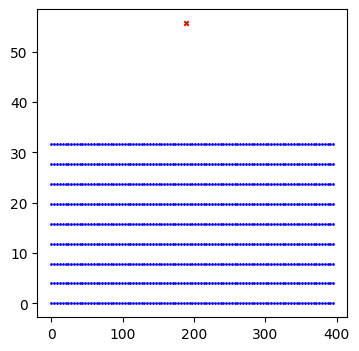

Epoch 300/500
Loss: 1.2391860485076904 MeanGrad: [1.9549344e-09 2.2259831e-08]


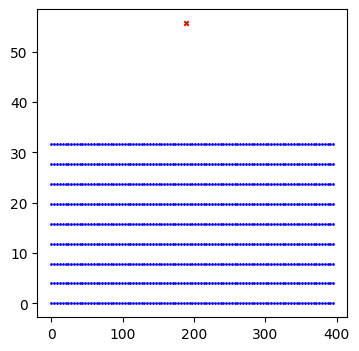

Epoch 301/500
Loss: 1.2391855716705322 MeanGrad: [-5.74250159e-09  1.14344175e-07]


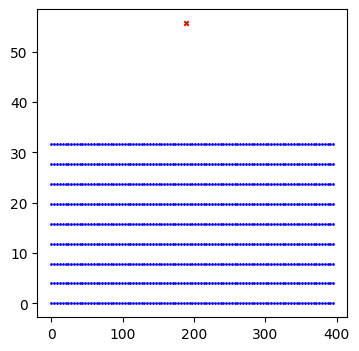

Epoch 302/500
Loss: 1.2391858100891113 MeanGrad: [-8.389080e-09  9.472572e-08]


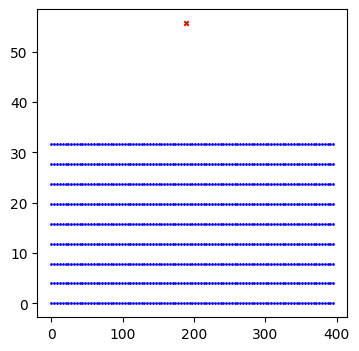

Epoch 303/500
Loss: 1.2391858100891113 MeanGrad: [2.4202895e-09 8.7778012e-08]


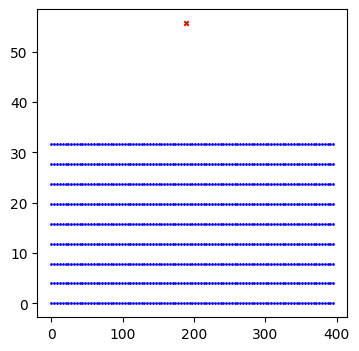

Epoch 304/500
Loss: 1.2391856908798218 MeanGrad: [9.3477768e-09 8.9121194e-08]


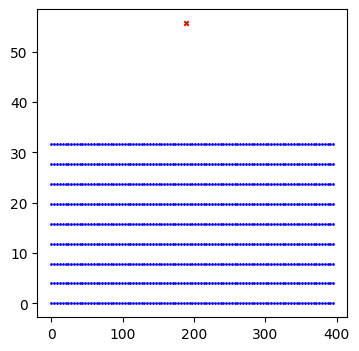

Epoch 305/500
Loss: 1.2391859292984009 MeanGrad: [-1.1616149e-08  5.5781619e-08]


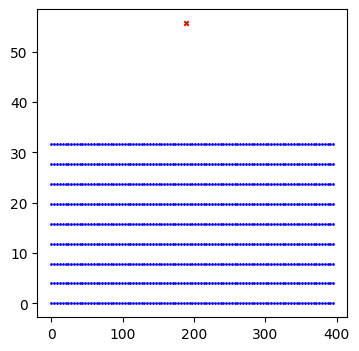

Epoch 306/500
Loss: 1.2391854524612427 MeanGrad: [9.7975095e-09 1.5325502e-07]


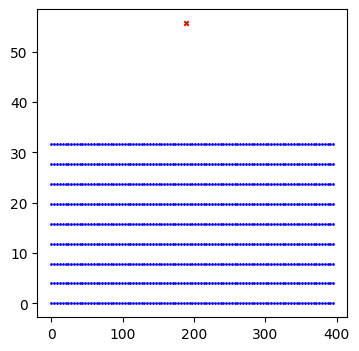

Epoch 307/500
Loss: 1.2391858100891113 MeanGrad: [-1.2683833e-08  8.9286480e-08]


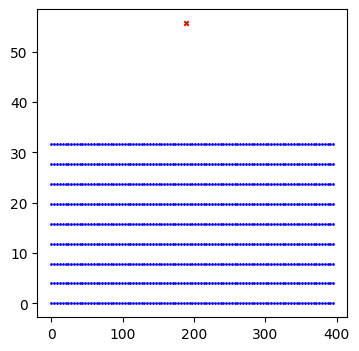

Epoch 308/500
Loss: 1.2391860485076904 MeanGrad: [9.6635446e-09 3.3710986e-08]


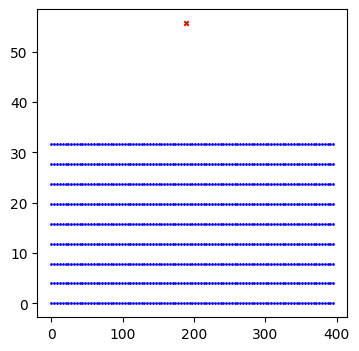

Epoch 309/500
Loss: 1.2391858100891113 MeanGrad: [-2.0370288e-09  5.7889419e-08]


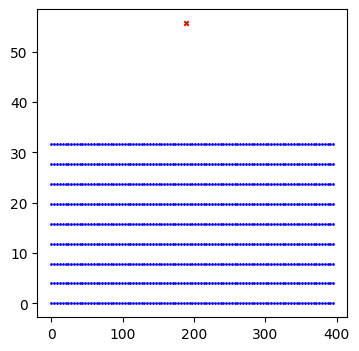

Epoch 310/500
Loss: 1.2391858100891113 MeanGrad: [1.4270478e-08 8.4233122e-08]


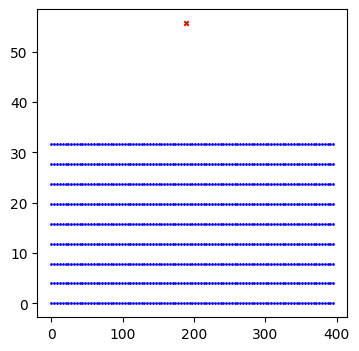

Epoch 311/500
Loss: 1.2391858100891113 MeanGrad: [-5.021110e-09  5.869176e-08]


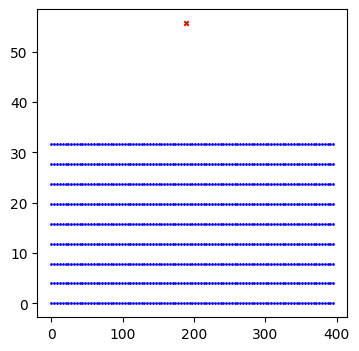

Epoch 312/500
Loss: 1.2391859292984009 MeanGrad: [2.2789859e-10 5.4658571e-08]


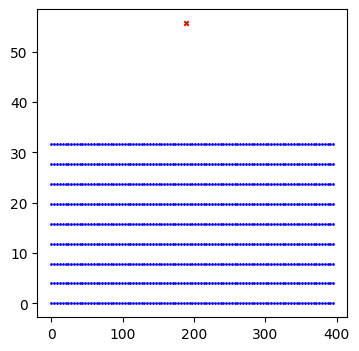

Epoch 313/500
Loss: 1.2391860485076904 MeanGrad: [-2.4138053e-10  3.6162191e-08]


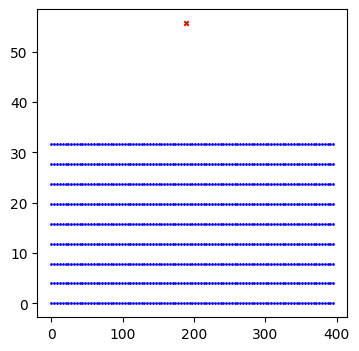

Epoch 314/500
Loss: 1.2391856908798218 MeanGrad: [5.1900257e-09 1.0763626e-07]


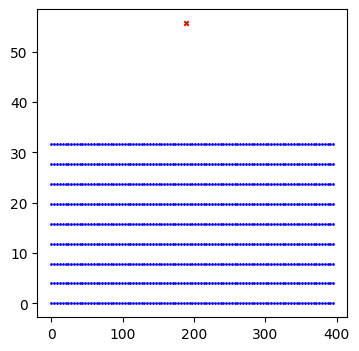

Epoch 315/500
Loss: 1.2391860485076904 MeanGrad: [-9.7993853e-09  4.2455646e-08]


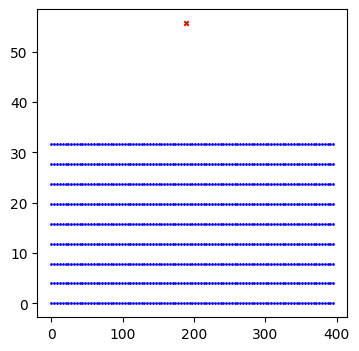

Epoch 316/500
Loss: 1.2391858100891113 MeanGrad: [-3.700359e-09  7.819240e-08]


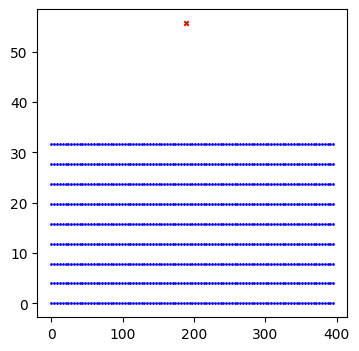

Epoch 317/500
Loss: 1.23918616771698 MeanGrad: [-1.1849675e-08  2.6434062e-08]


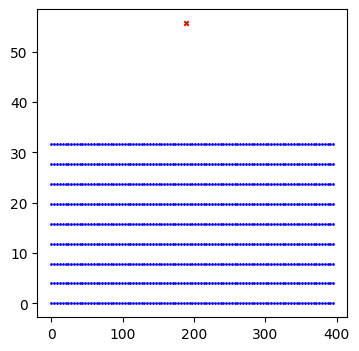

Epoch 318/500
Loss: 1.2391856908798218 MeanGrad: [-6.7161294e-09  1.1478528e-07]


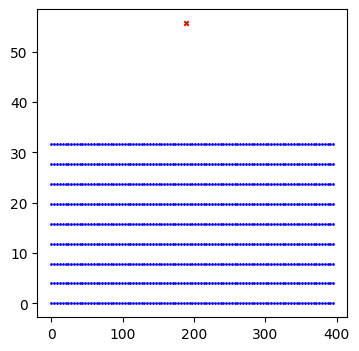

Epoch 319/500
Loss: 1.2391860485076904 MeanGrad: [8.1748510e-09 4.6421675e-08]


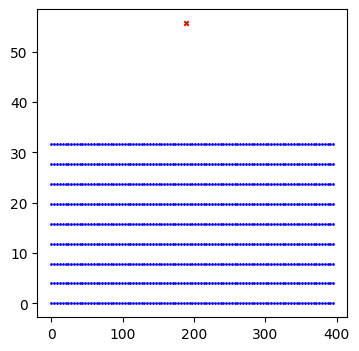

Epoch 320/500
Loss: 1.2391858100891113 MeanGrad: [-1.0098866e-09  5.0203457e-08]


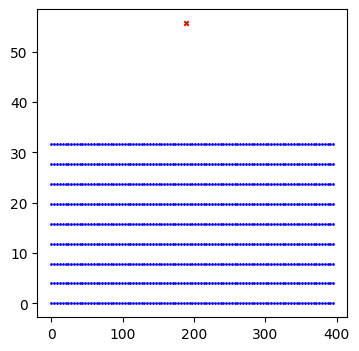

Epoch 321/500
Loss: 1.2391859292984009 MeanGrad: [-3.3875758e-09  5.5063946e-08]


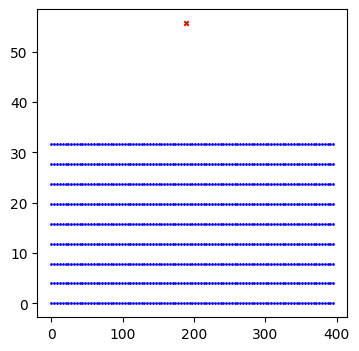

Epoch 322/500
Loss: 1.2391858100891113 MeanGrad: [4.8706710e-09 4.6645024e-08]


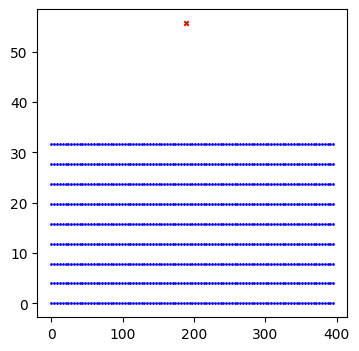

Epoch 323/500
Loss: 1.2391858100891113 MeanGrad: [-6.5579018e-09  7.0399061e-08]


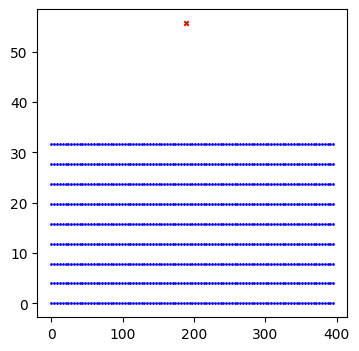

Epoch 324/500
Loss: 1.2391859292984009 MeanGrad: [-1.4276166e-08  8.0398593e-08]


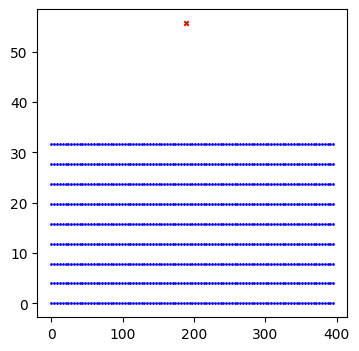

Epoch 325/500
Loss: 1.2391859292984009 MeanGrad: [-1.0883663e-09  7.1811087e-08]


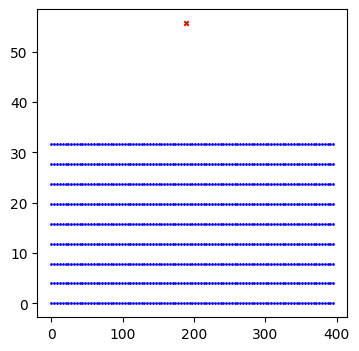

Epoch 326/500
Loss: 1.23918616771698 MeanGrad: [-2.6290881e-09  1.3473118e-08]


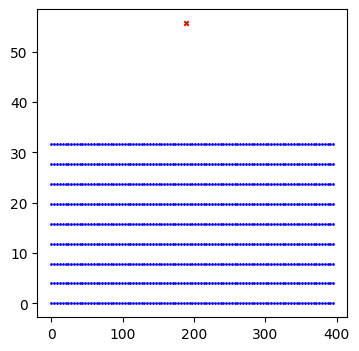

Epoch 327/500
Loss: 1.2391860485076904 MeanGrad: [2.2634019e-09 2.4862443e-08]


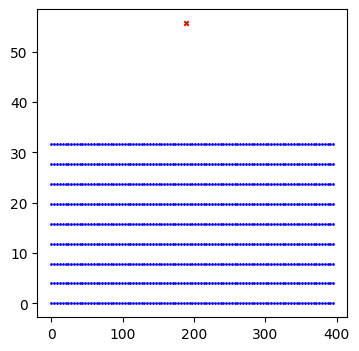

Epoch 328/500
Loss: 1.2391858100891113 MeanGrad: [6.3671060e-09 9.2145456e-08]


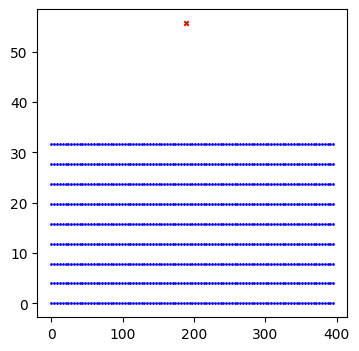

Epoch 329/500
Loss: 1.2391859292984009 MeanGrad: [-2.8956135e-09  3.9681858e-08]


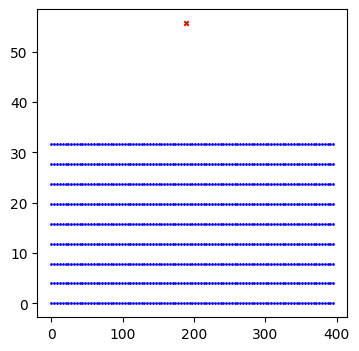

Epoch 330/500
Loss: 1.2391858100891113 MeanGrad: [-1.2766662e-08  6.9341063e-08]


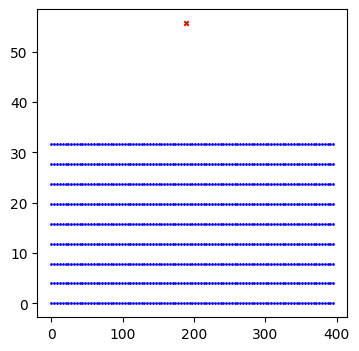

Epoch 331/500
Loss: 1.2391858100891113 MeanGrad: [-1.2061713e-08  5.6100291e-08]


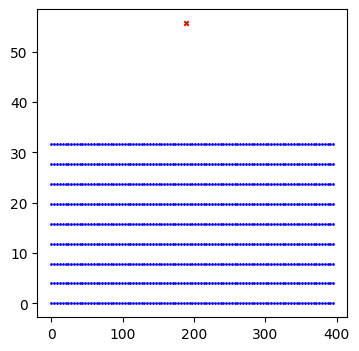

Epoch 332/500
Loss: 1.2391859292984009 MeanGrad: [-5.802472e-09  4.212290e-08]


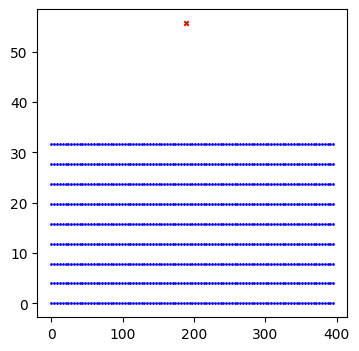

Epoch 333/500
Loss: 1.2391858100891113 MeanGrad: [-1.747848e-08  5.435322e-08]


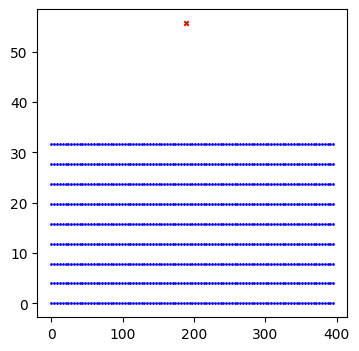

Epoch 334/500
Loss: 1.2391858100891113 MeanGrad: [3.5394487e-09 5.1560978e-08]


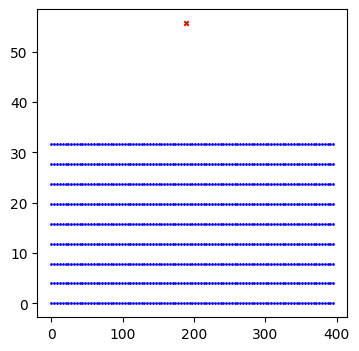

Epoch 335/500
Loss: 1.2391858100891113 MeanGrad: [1.0578898e-09 7.5798418e-08]


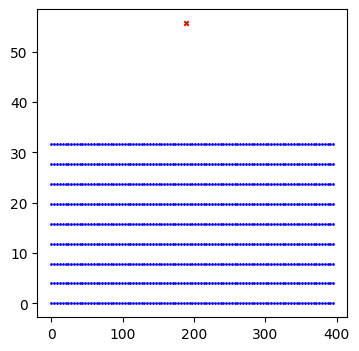

Epoch 336/500
Loss: 1.2391860485076904 MeanGrad: [-7.0023063e-09  3.0081388e-08]


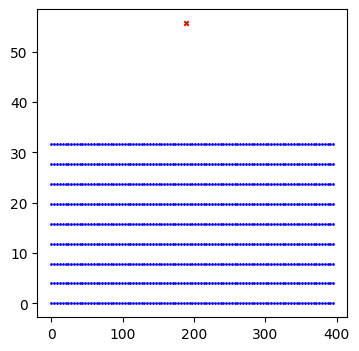

Epoch 337/500
Loss: 1.2391858100891113 MeanGrad: [1.6082975e-08 7.1672510e-08]


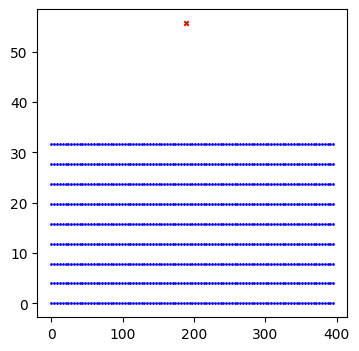

Epoch 338/500
Loss: 1.2391855716705322 MeanGrad: [6.7114803e-10 1.3032889e-07]


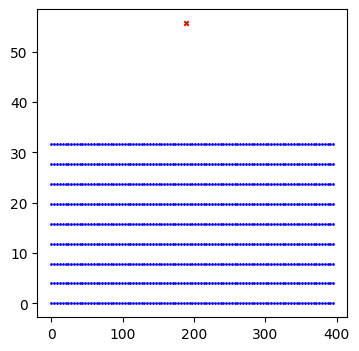

Epoch 339/500
Loss: 1.2391856908798218 MeanGrad: [7.2454025e-09 8.0697930e-08]


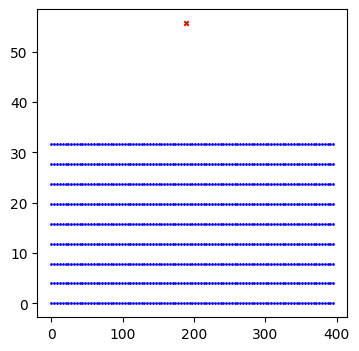

Epoch 340/500
Loss: 1.2391858100891113 MeanGrad: [2.8683829e-09 4.2691809e-08]


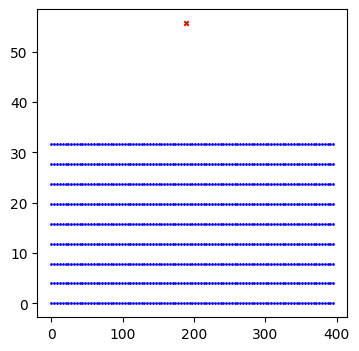

Epoch 341/500
Loss: 1.2391859292984009 MeanGrad: [1.4363518e-08 4.3577273e-08]


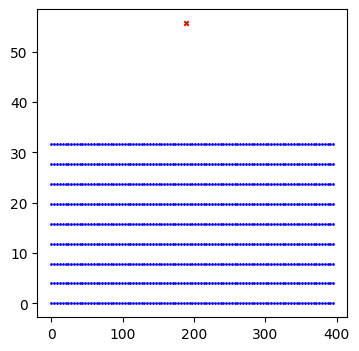

Epoch 342/500
Loss: 1.2391859292984009 MeanGrad: [4.9593858e-09 6.3980956e-08]


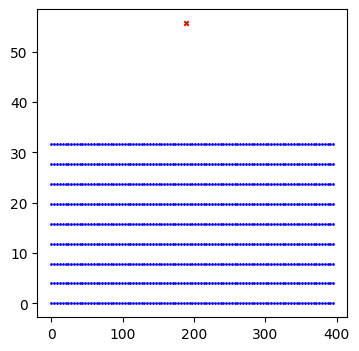

Epoch 343/500
Loss: 1.2391858100891113 MeanGrad: [2.674646e-09 8.902923e-08]


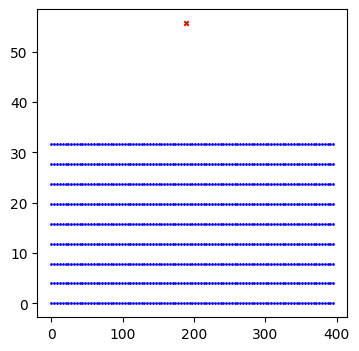

Epoch 344/500
Loss: 1.2391860485076904 MeanGrad: [8.5954461e-09 2.0678323e-08]


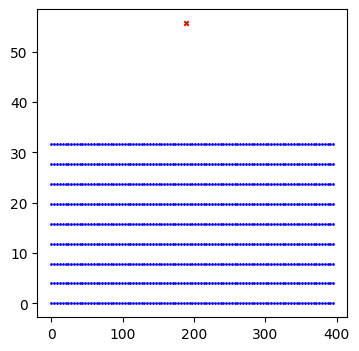

Epoch 345/500
Loss: 1.2391860485076904 MeanGrad: [8.9209440e-09 2.8882141e-08]


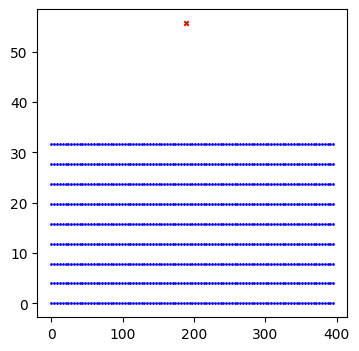

Epoch 346/500
Loss: 1.2391860485076904 MeanGrad: [-6.3223426e-09  1.5419491e-08]


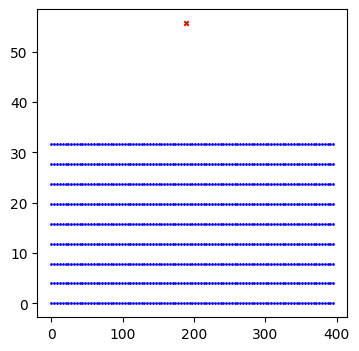

Epoch 347/500
Loss: 1.2391858100891113 MeanGrad: [8.740580e-09 6.085205e-08]


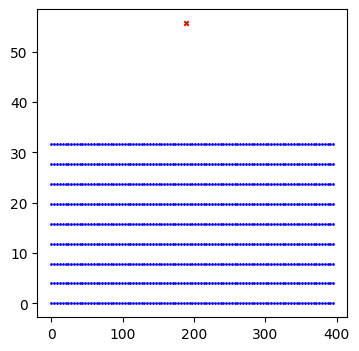

Epoch 348/500
Loss: 1.23918616771698 MeanGrad: [-6.584522e-10  1.712442e-08]


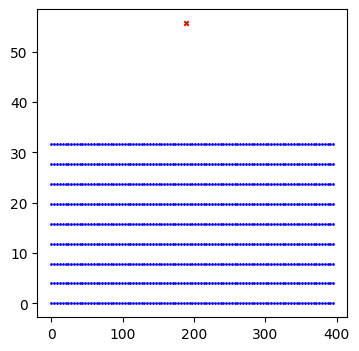

Epoch 349/500
Loss: 1.2391858100891113 MeanGrad: [8.6564160e-09 8.2646785e-08]


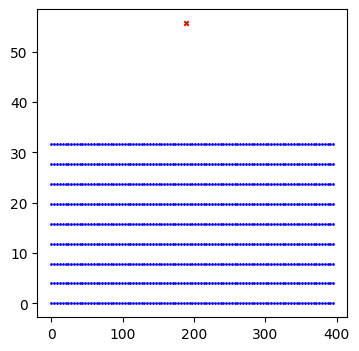

Epoch 350/500
Loss: 1.2391856908798218 MeanGrad: [4.7815614e-09 7.6291961e-08]


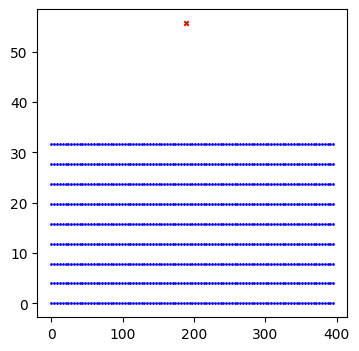

Epoch 351/500
Loss: 1.2391860485076904 MeanGrad: [-9.4012105e-09  2.6880986e-08]


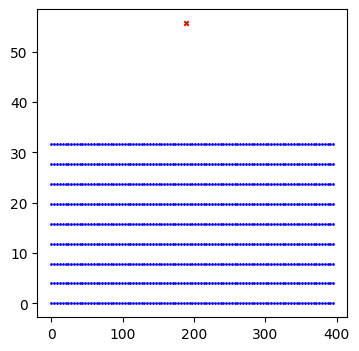

Epoch 352/500
Loss: 1.2391859292984009 MeanGrad: [2.4023632e-09 4.6537011e-08]


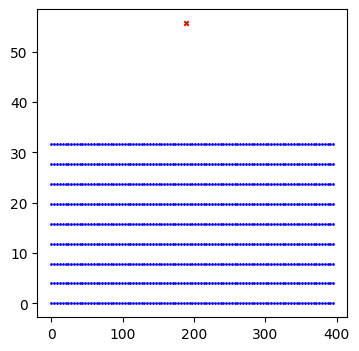

Epoch 353/500
Loss: 1.2391859292984009 MeanGrad: [-5.0814477e-09  3.7322454e-08]


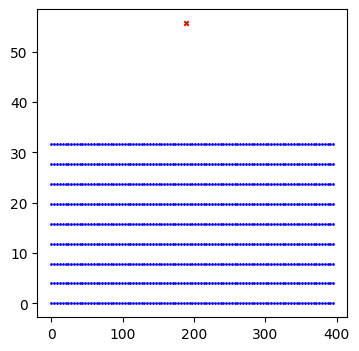

Epoch 354/500
Loss: 1.2391858100891113 MeanGrad: [-1.0956017e-08  1.1021385e-07]


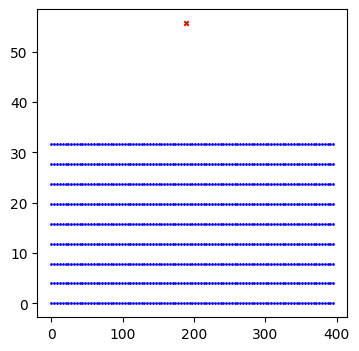

Epoch 355/500
Loss: 1.2391859292984009 MeanGrad: [-3.9596282e-09  3.4814462e-08]


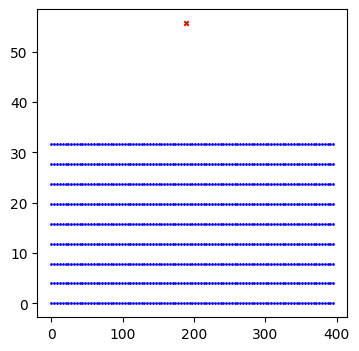

Epoch 356/500
Loss: 1.23918616771698 MeanGrad: [1.0822909e-09 1.8363130e-08]


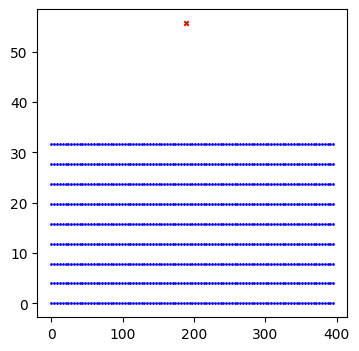

Epoch 357/500
Loss: 1.2391859292984009 MeanGrad: [7.0819817e-09 5.1681646e-08]


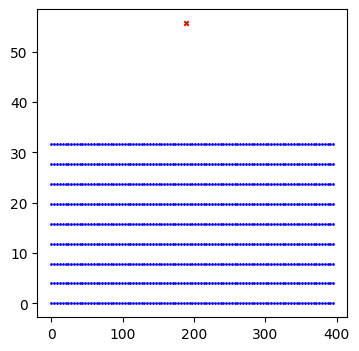

Epoch 358/500
Loss: 1.2391859292984009 MeanGrad: [-1.06283125e-08  6.77514578e-08]


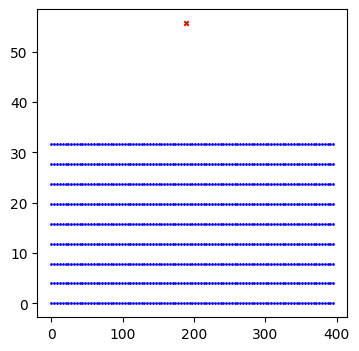

Epoch 359/500
Loss: 1.2391858100891113 MeanGrad: [-1.0240313e-08  7.7514535e-08]


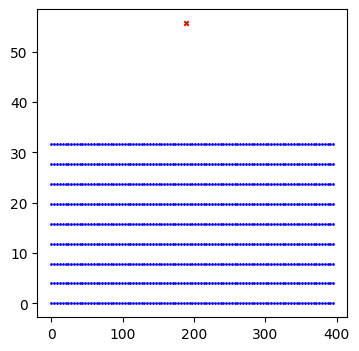

Epoch 360/500
Loss: 1.2391859292984009 MeanGrad: [6.5900494e-09 4.9467477e-08]


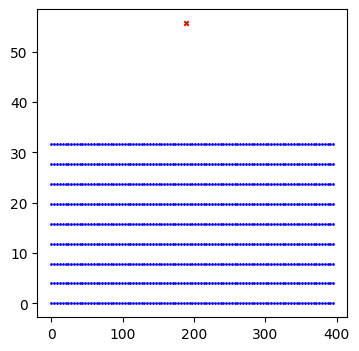

Epoch 361/500
Loss: 1.2391859292984009 MeanGrad: [-9.165096e-09  3.912454e-08]


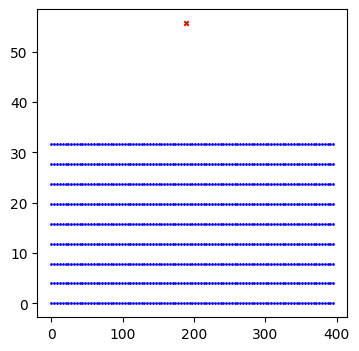

Epoch 362/500
Loss: 1.2391859292984009 MeanGrad: [2.9808962e-09 5.0393229e-08]


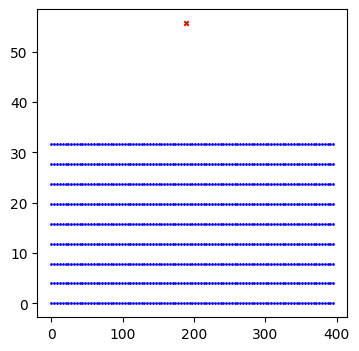

Epoch 363/500
Loss: 1.2391856908798218 MeanGrad: [5.0035576e-09 8.1341661e-08]


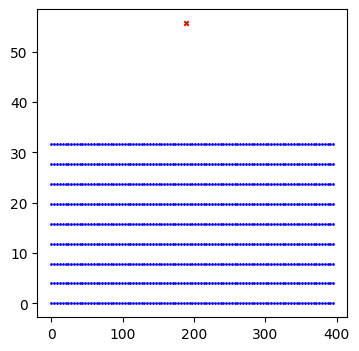

Epoch 364/500
Loss: 1.23918616771698 MeanGrad: [-3.5566163e-09  2.8013671e-08]


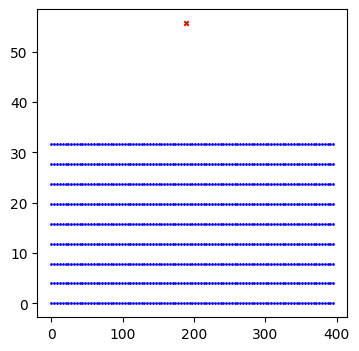

Epoch 365/500
Loss: 1.2391859292984009 MeanGrad: [-6.814836e-09  5.142346e-08]


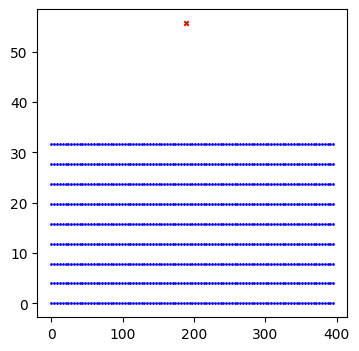

Epoch 366/500
Loss: 1.2391859292984009 MeanGrad: [-4.319724e-09  5.452992e-08]


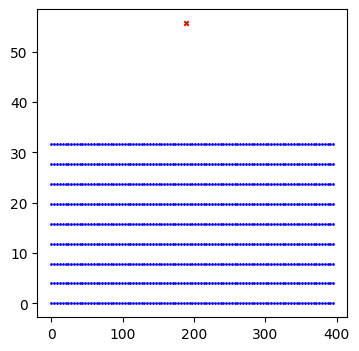

Epoch 367/500
Loss: 1.2391860485076904 MeanGrad: [-6.2657066e-09  3.4889322e-08]


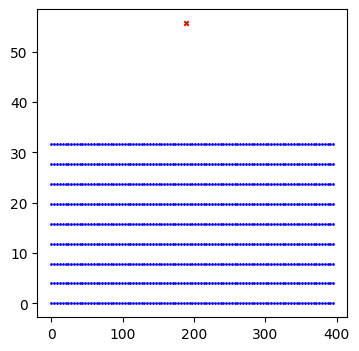

Epoch 368/500
Loss: 1.2391858100891113 MeanGrad: [-8.137659e-09  8.946002e-08]


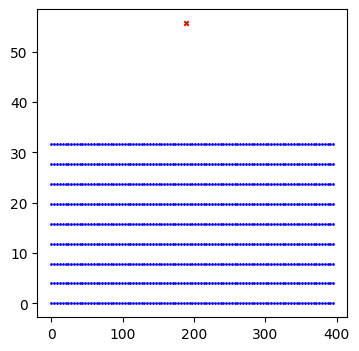

Epoch 369/500
Loss: 1.2391859292984009 MeanGrad: [6.4388814e-09 5.7188942e-08]


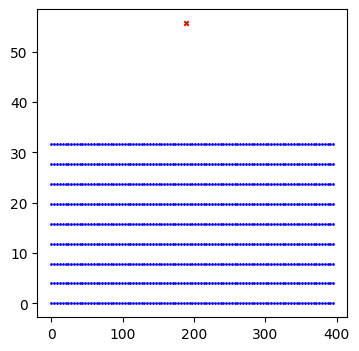

Epoch 370/500
Loss: 1.2391858100891113 MeanGrad: [1.5425254e-08 9.4534037e-08]


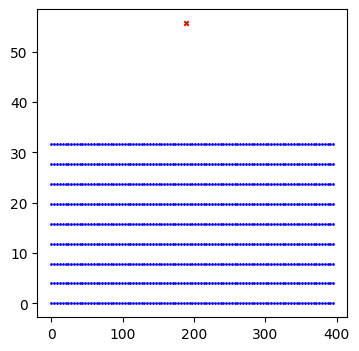

Epoch 371/500
Loss: 1.2391858100891113 MeanGrad: [1.2371947e-08 8.9981832e-08]


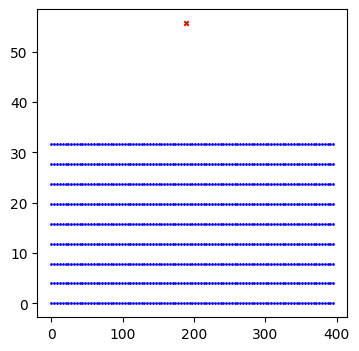

Epoch 372/500
Loss: 1.2391859292984009 MeanGrad: [-4.0151162e-09  7.5539440e-08]


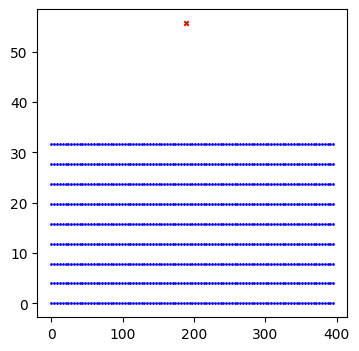

Epoch 373/500
Loss: 1.2391859292984009 MeanGrad: [2.0289863e-09 3.2254913e-08]


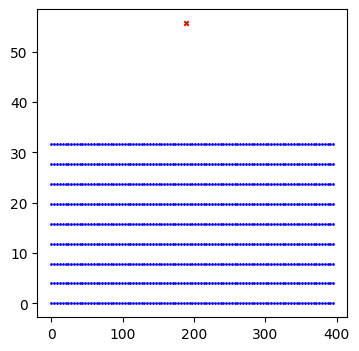

Epoch 374/500
Loss: 1.2391858100891113 MeanGrad: [2.0210372e-08 6.9898462e-08]


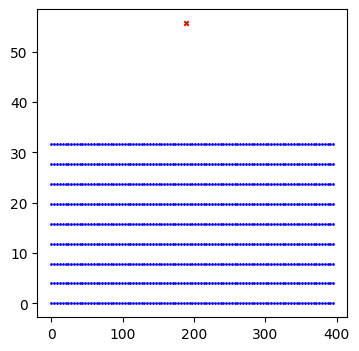

Epoch 375/500
Loss: 1.2391858100891113 MeanGrad: [-1.8777535e-09  7.0632026e-08]


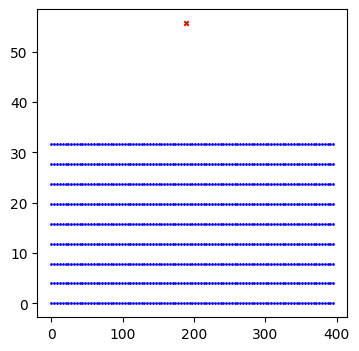

Epoch 376/500
Loss: 1.2391859292984009 MeanGrad: [-4.5824282e-09  4.9256514e-08]


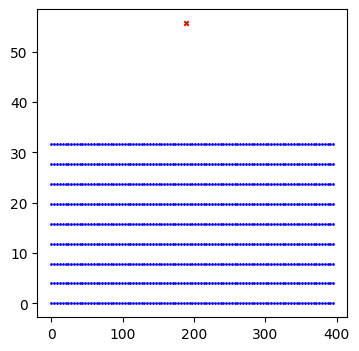

Epoch 377/500
Loss: 1.2391860485076904 MeanGrad: [2.8871256e-09 2.2624651e-08]


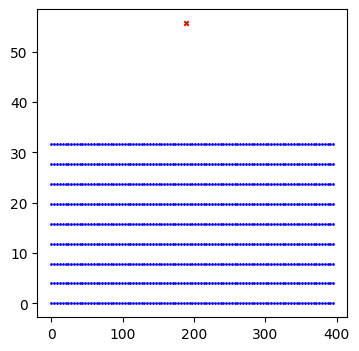

Epoch 378/500
Loss: 1.2391860485076904 MeanGrad: [3.4637095e-09 2.3277790e-08]


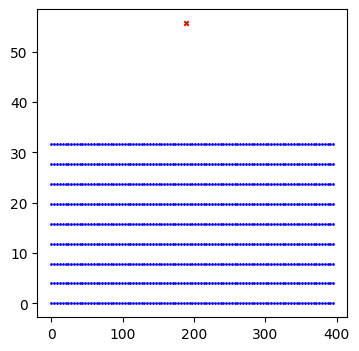

Epoch 379/500
Loss: 1.2391860485076904 MeanGrad: [-1.262985e-09  3.483603e-08]


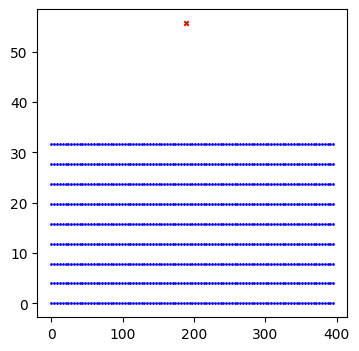

Epoch 380/500
Loss: 1.2391860485076904 MeanGrad: [5.8358482e-09 2.9357475e-08]


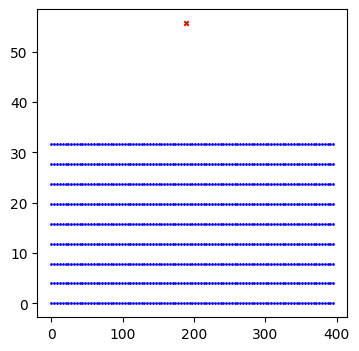

Epoch 381/500
Loss: 1.2391860485076904 MeanGrad: [2.9261131e-09 2.9393251e-08]


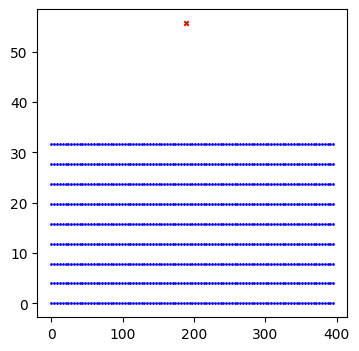

Epoch 382/500
Loss: 1.2391860485076904 MeanGrad: [-5.1461182e-09  1.9663952e-08]


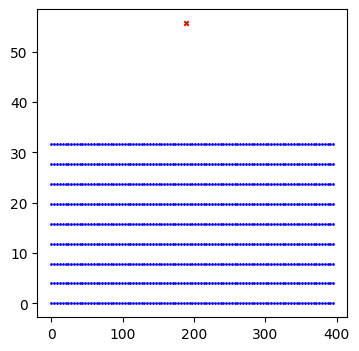

Epoch 383/500
Loss: 1.2391859292984009 MeanGrad: [9.795498e-10 5.963336e-08]


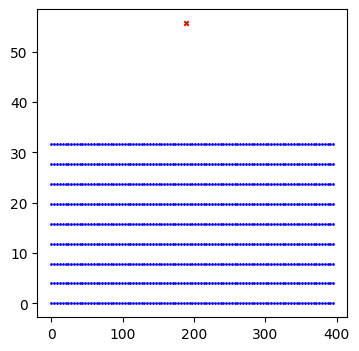

Epoch 384/500
Loss: 1.2391859292984009 MeanGrad: [1.9358861e-08 6.6667248e-08]


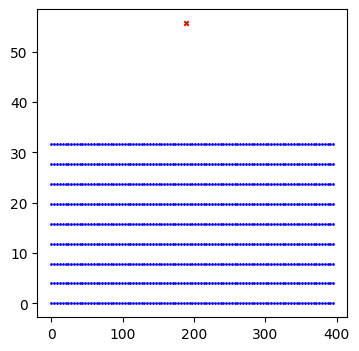

Epoch 385/500
Loss: 1.2391858100891113 MeanGrad: [1.1719895e-09 8.7826287e-08]


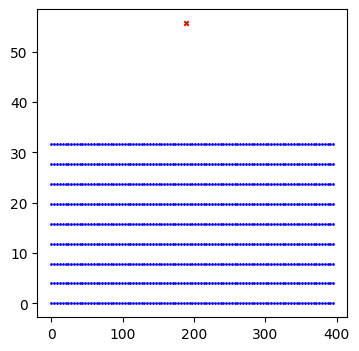

Epoch 386/500
Loss: 1.2391860485076904 MeanGrad: [-5.5480305e-09  4.0476078e-08]


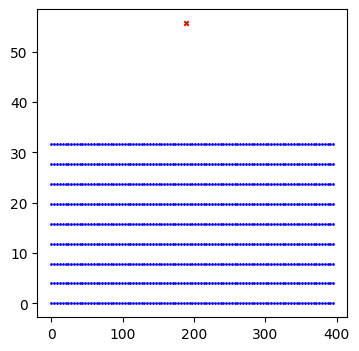

Epoch 387/500
Loss: 1.2391858100891113 MeanGrad: [-6.5624377e-09  2.9556476e-08]


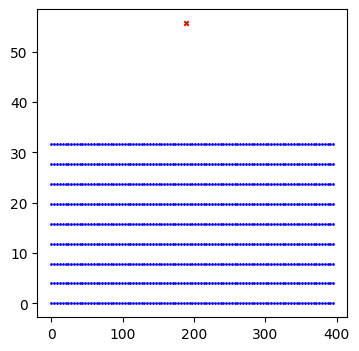

Epoch 388/500
Loss: 1.2391858100891113 MeanGrad: [1.0408736e-08 5.4955947e-08]


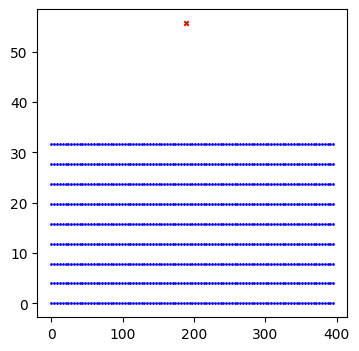

Epoch 389/500
Loss: 1.2391860485076904 MeanGrad: [-5.9900325e-09  3.1825877e-08]


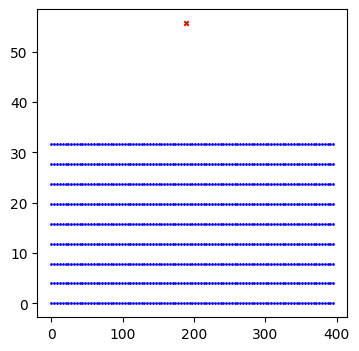

Epoch 390/500
Loss: 1.2391859292984009 MeanGrad: [-5.3560782e-09  5.0728094e-08]


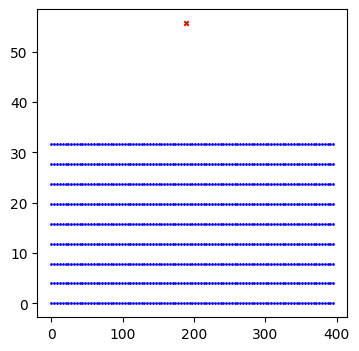

Epoch 391/500
Loss: 1.2391859292984009 MeanGrad: [1.2100873e-08 7.4180775e-08]


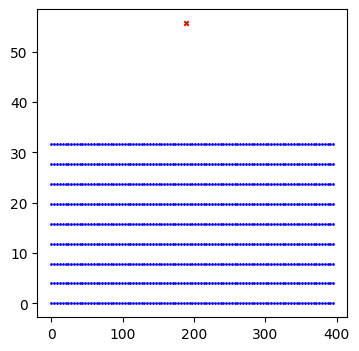

Epoch 392/500
Loss: 1.2391859292984009 MeanGrad: [4.9056430e-09 4.9365433e-08]


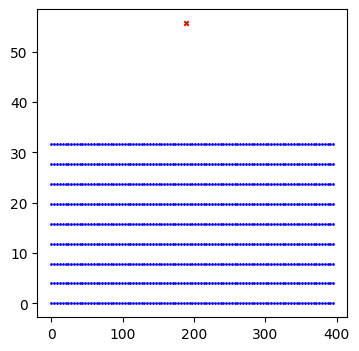

Epoch 393/500
Loss: 1.2391859292984009 MeanGrad: [8.1129246e-09 4.8826724e-08]


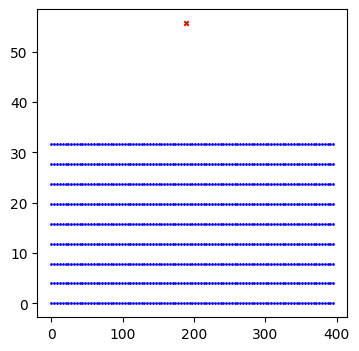

Epoch 394/500
Loss: 1.2391859292984009 MeanGrad: [1.9877406e-09 3.7875687e-08]


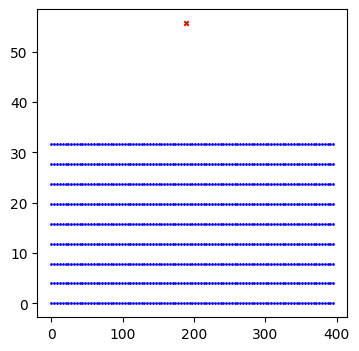

Epoch 395/500
Loss: 1.2391859292984009 MeanGrad: [1.2234106e-09 4.2706830e-08]


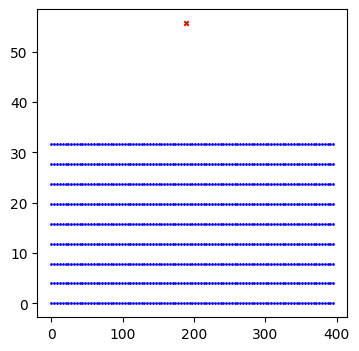

Epoch 396/500
Loss: 1.2391860485076904 MeanGrad: [3.9093071e-09 3.6988506e-08]


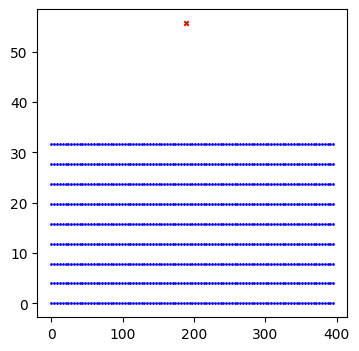

Epoch 397/500
Loss: 1.23918616771698 MeanGrad: [2.6449498e-09 1.1204490e-08]


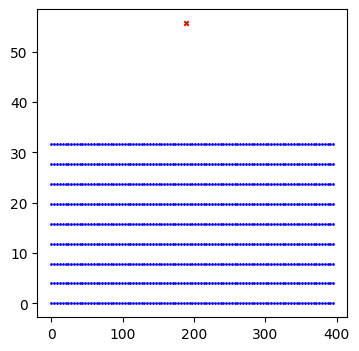

Epoch 398/500
Loss: 1.2391858100891113 MeanGrad: [-1.5074781e-09  8.1953424e-08]


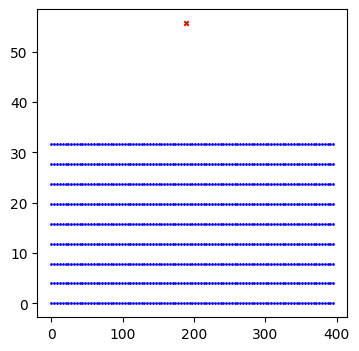

Epoch 399/500
Loss: 1.2391859292984009 MeanGrad: [-4.2837636e-09  3.2018676e-08]


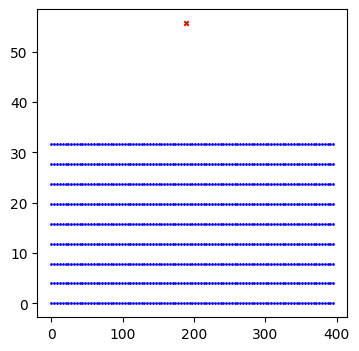

Epoch 400/500
Loss: 1.2391858100891113 MeanGrad: [1.4673653e-08 7.4999249e-08]


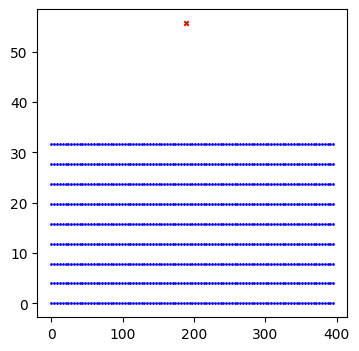

Epoch 401/500
Loss: 1.2391858100891113 MeanGrad: [-2.6257085e-09  5.4730524e-08]


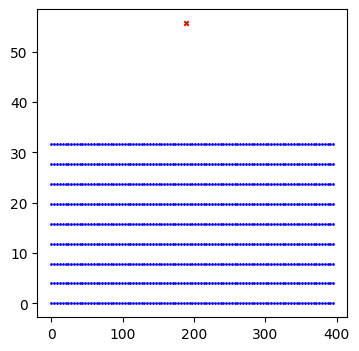

Epoch 402/500
Loss: 1.2391858100891113 MeanGrad: [7.762857e-09 5.431366e-08]


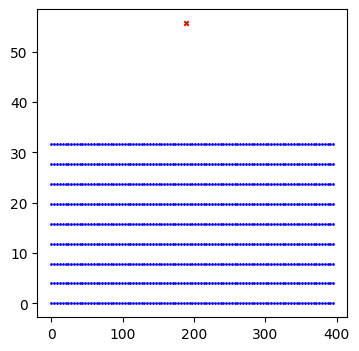

Epoch 403/500
Loss: 1.2391855716705322 MeanGrad: [-9.1269285e-09  1.2444760e-07]


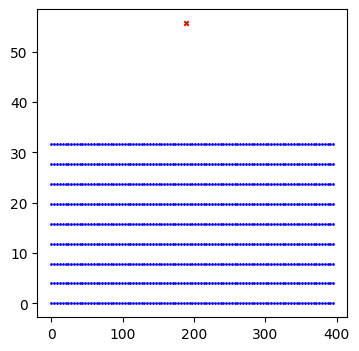

Epoch 404/500
Loss: 1.2391860485076904 MeanGrad: [-1.15935865e-08  2.66872711e-08]


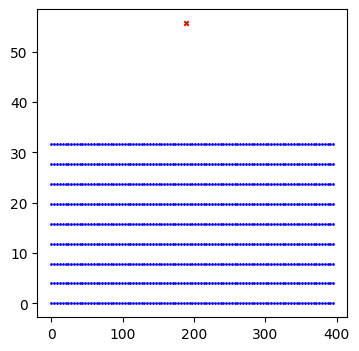

Epoch 405/500
Loss: 1.2391859292984009 MeanGrad: [-1.0631025e-08  7.6401818e-08]


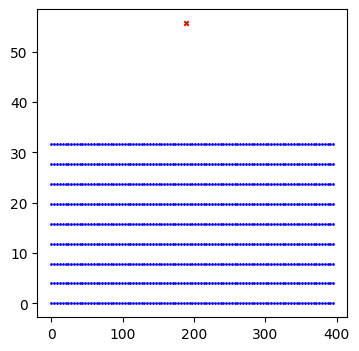

Epoch 406/500
Loss: 1.2391859292984009 MeanGrad: [-6.7963972e-09  5.4700674e-08]


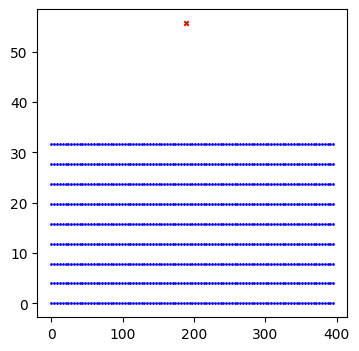

Epoch 407/500
Loss: 1.2391859292984009 MeanGrad: [1.7947319e-09 5.0676675e-08]


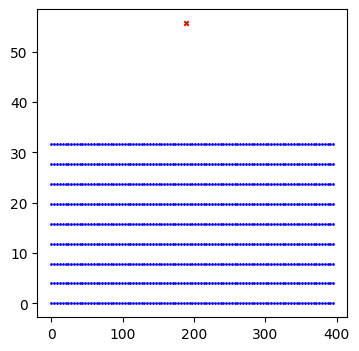

Epoch 408/500
Loss: 1.2391856908798218 MeanGrad: [-9.483996e-09  9.687865e-08]


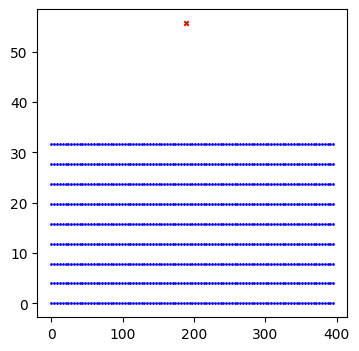

Epoch 409/500
Loss: 1.2391859292984009 MeanGrad: [1.2964581e-08 5.1036363e-08]


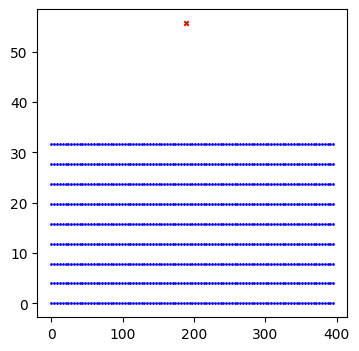

Epoch 410/500
Loss: 1.23918616771698 MeanGrad: [1.0766799e-09 1.8502698e-08]


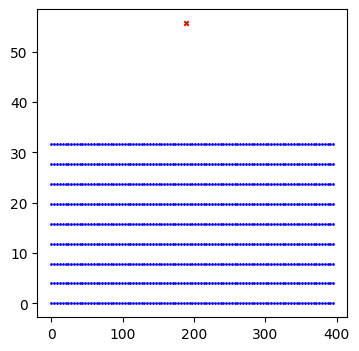

Epoch 411/500
Loss: 1.2391859292984009 MeanGrad: [6.7961503e-09 4.0611511e-08]


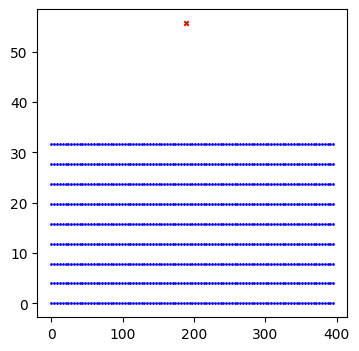

Epoch 412/500
Loss: 1.2391860485076904 MeanGrad: [2.6888674e-09 3.4773528e-08]


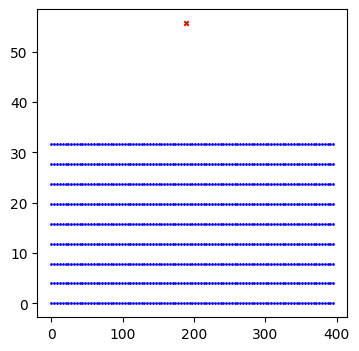

Epoch 413/500
Loss: 1.2391859292984009 MeanGrad: [-4.6857043e-09  4.2434635e-08]


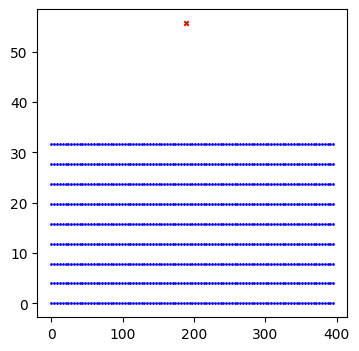

Epoch 414/500
Loss: 1.2391855716705322 MeanGrad: [-2.00344914e-08  1.18990926e-07]


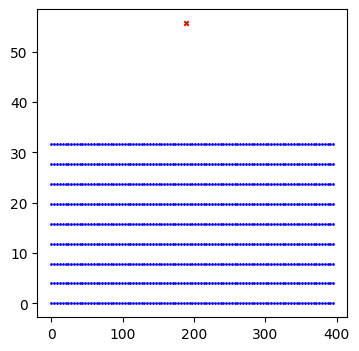

Epoch 415/500
Loss: 1.2391855716705322 MeanGrad: [2.1655087e-08 1.0552933e-07]


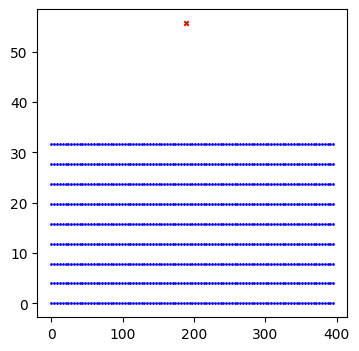

Epoch 416/500
Loss: 1.2391856908798218 MeanGrad: [7.0179791e-09 8.1753214e-08]


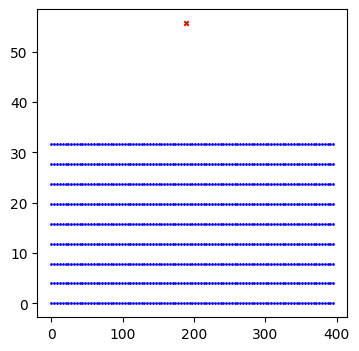

Epoch 417/500
Loss: 1.2391859292984009 MeanGrad: [-8.667643e-09  5.089606e-08]


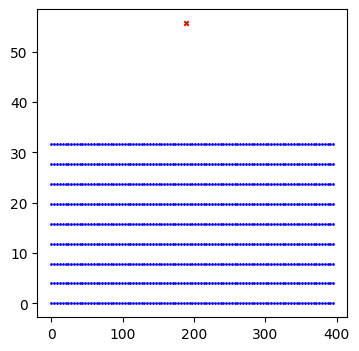

Epoch 418/500
Loss: 1.2391858100891113 MeanGrad: [1.2865339e-08 8.6734431e-08]


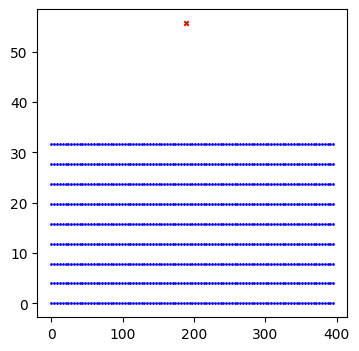

Epoch 419/500
Loss: 1.23918616771698 MeanGrad: [-3.0471905e-09  1.6269073e-08]


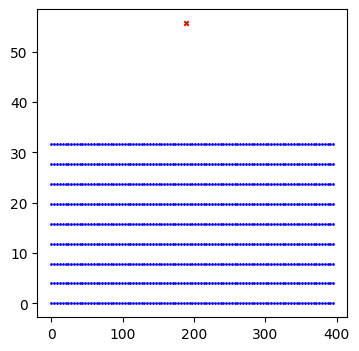

Epoch 420/500
Loss: 1.2391860485076904 MeanGrad: [5.2915574e-09 2.5176897e-08]


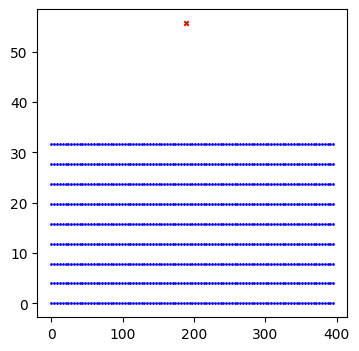

Epoch 421/500
Loss: 1.2391860485076904 MeanGrad: [8.5351493e-10 3.0002543e-08]


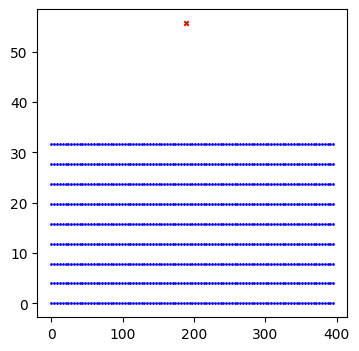

Epoch 422/500
Loss: 1.2391858100891113 MeanGrad: [-3.835730e-09  8.522363e-08]


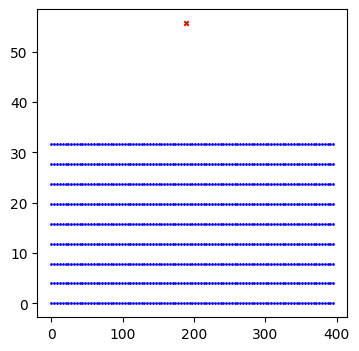

Epoch 423/500
Loss: 1.2391860485076904 MeanGrad: [1.6752628e-09 4.0746194e-08]


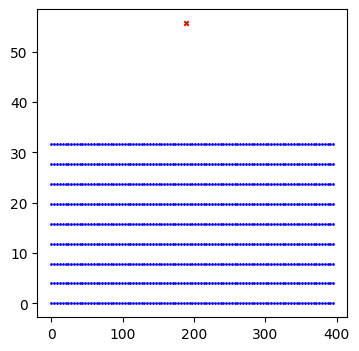

Epoch 424/500
Loss: 1.2391860485076904 MeanGrad: [-3.933717e-09  3.851164e-08]


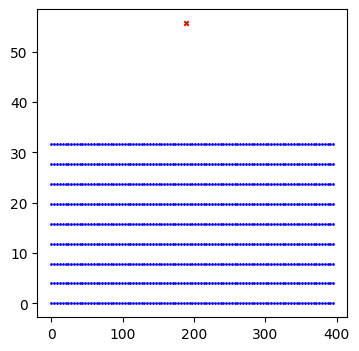

Epoch 425/500
Loss: 1.2391855716705322 MeanGrad: [-1.3292616e-08  1.3538596e-07]


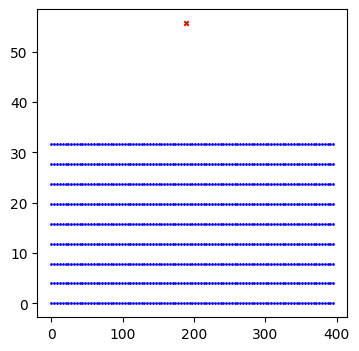

Epoch 426/500
Loss: 1.23918616771698 MeanGrad: [2.5249531e-09 2.8555512e-08]


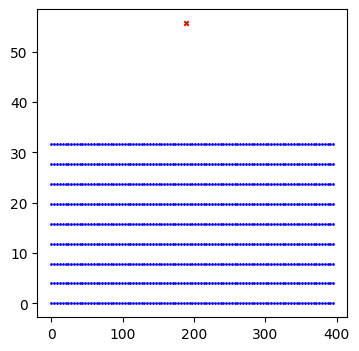

Epoch 427/500
Loss: 1.2391859292984009 MeanGrad: [8.0850757e-09 7.0607854e-08]


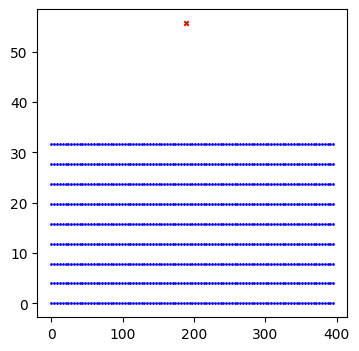

Epoch 428/500
Loss: 1.2391860485076904 MeanGrad: [-1.2119479e-08  4.1827164e-08]


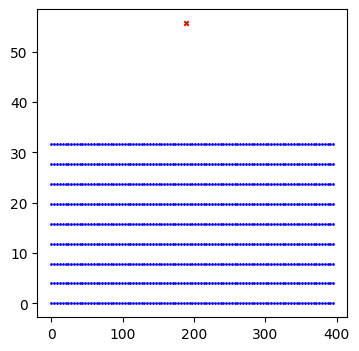

Epoch 429/500
Loss: 1.2391860485076904 MeanGrad: [4.2477986e-09 3.9076205e-08]


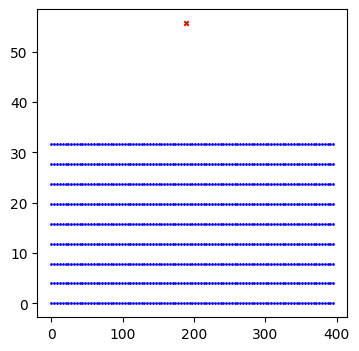

Epoch 430/500
Loss: 1.2391859292984009 MeanGrad: [9.5174091e-09 3.5938445e-08]


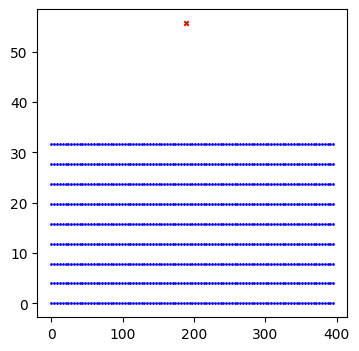

Epoch 431/500
Loss: 1.2391858100891113 MeanGrad: [1.9417556e-09 7.9865195e-08]


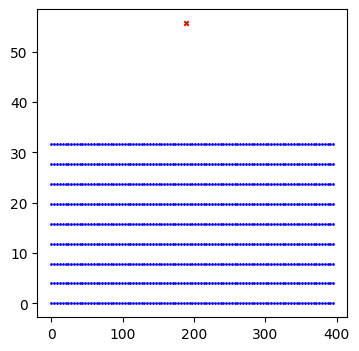

Epoch 432/500
Loss: 1.2391858100891113 MeanGrad: [-9.816995e-09  7.619426e-08]


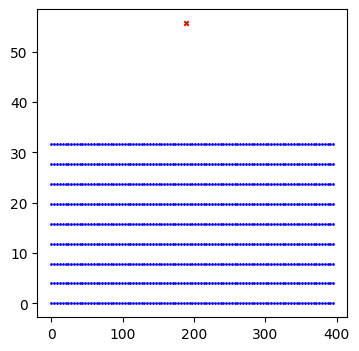

Epoch 433/500
Loss: 1.2391858100891113 MeanGrad: [8.3781311e-09 6.8599846e-08]


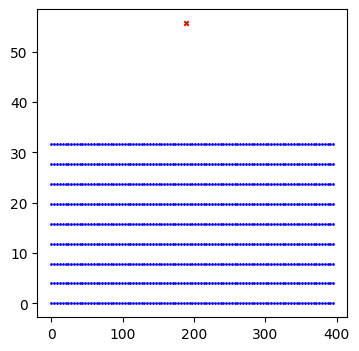

Epoch 434/500
Loss: 1.2391858100891113 MeanGrad: [2.3674415e-08 9.0305072e-08]


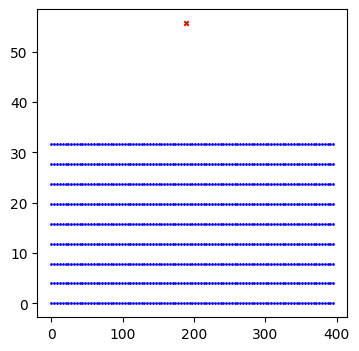

Epoch 435/500
Loss: 1.2391859292984009 MeanGrad: [2.2575022e-09 5.6264298e-08]


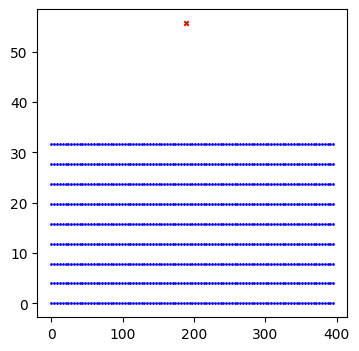

Epoch 436/500
Loss: 1.2391856908798218 MeanGrad: [-8.797511e-09  1.216067e-07]


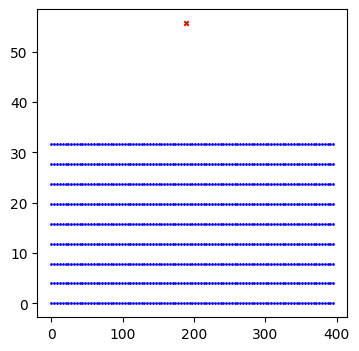

Epoch 437/500
Loss: 1.2391856908798218 MeanGrad: [1.9117010e-08 9.3868245e-08]


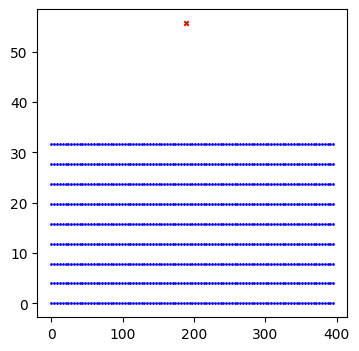

Epoch 438/500
Loss: 1.2391860485076904 MeanGrad: [8.470074e-09 3.593971e-08]


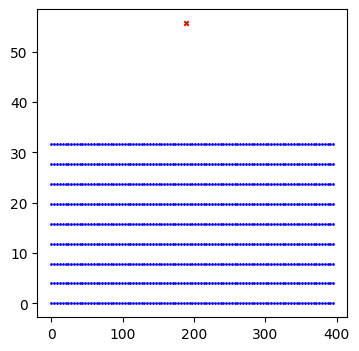

Epoch 439/500
Loss: 1.2391858100891113 MeanGrad: [-1.529957e-08  9.180047e-08]


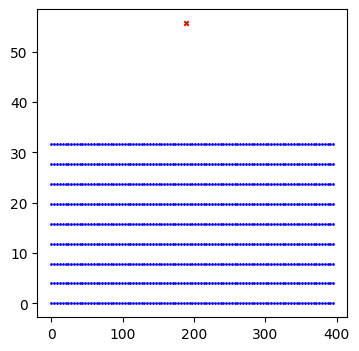

Epoch 440/500
Loss: 1.2391860485076904 MeanGrad: [6.341878e-09 3.025220e-08]


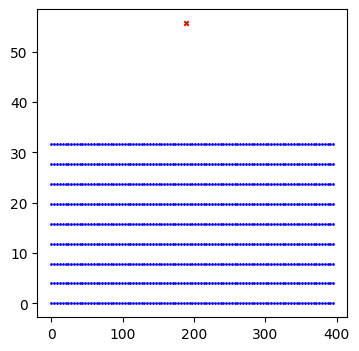

Epoch 441/500
Loss: 1.2391858100891113 MeanGrad: [-8.5368805e-09  7.4616793e-08]


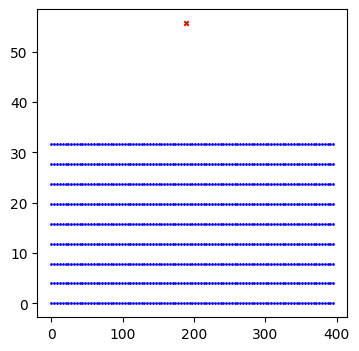

Epoch 442/500
Loss: 1.2391859292984009 MeanGrad: [7.1352955e-09 5.2832569e-08]


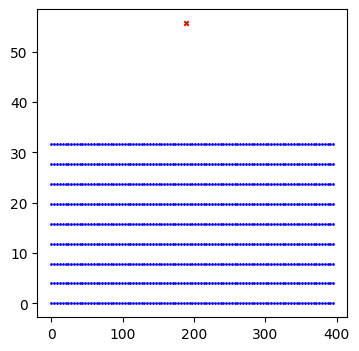

Epoch 443/500
Loss: 1.2391859292984009 MeanGrad: [2.038888e-08 6.663382e-08]


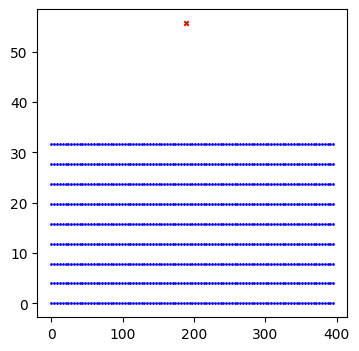

Epoch 444/500
Loss: 1.2391858100891113 MeanGrad: [-1.0860319e-09  8.3786276e-08]


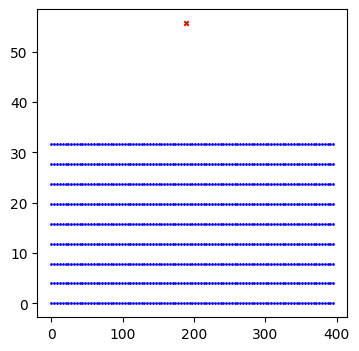

Epoch 445/500
Loss: 1.2391859292984009 MeanGrad: [-6.3430736e-09  5.8728677e-08]


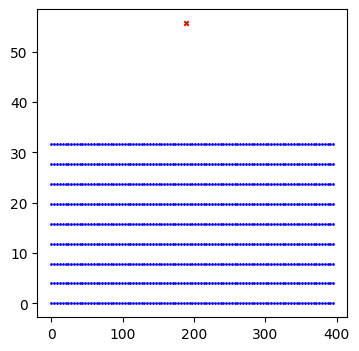

Epoch 446/500
Loss: 1.2391856908798218 MeanGrad: [-2.8949121e-09  1.0376968e-07]


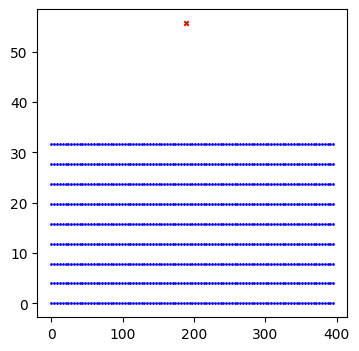

Epoch 447/500
Loss: 1.2391855716705322 MeanGrad: [-6.4683903e-09  1.2243169e-07]


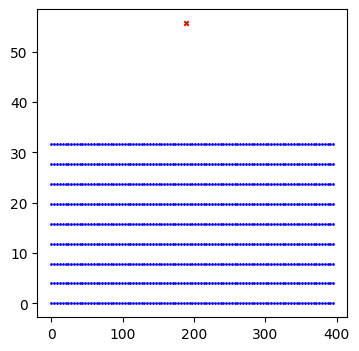

Epoch 448/500
Loss: 1.2391858100891113 MeanGrad: [1.06930464e-08 8.29733011e-08]


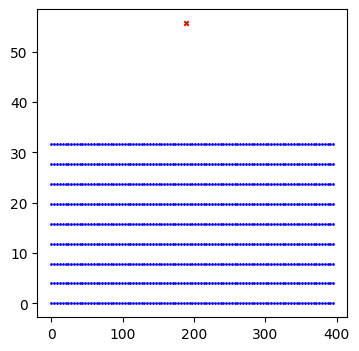

Epoch 449/500
Loss: 1.2391859292984009 MeanGrad: [1.2997358e-09 5.6891498e-08]


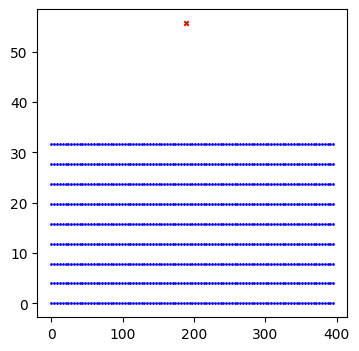

Epoch 450/500
Loss: 1.2391859292984009 MeanGrad: [4.0051598e-09 5.2804765e-08]


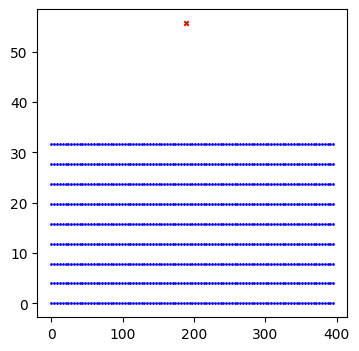

Epoch 451/500
Loss: 1.2391855716705322 MeanGrad: [4.8298743e-09 1.2014273e-07]


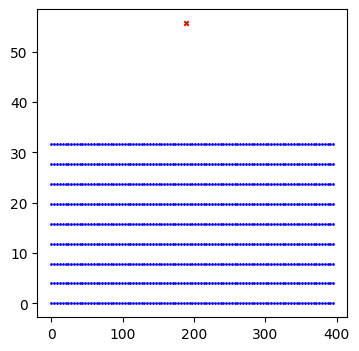

Epoch 452/500
Loss: 1.2391860485076904 MeanGrad: [-2.7718190e-09  4.5137348e-08]


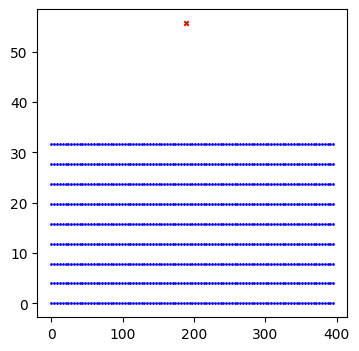

Epoch 453/500
Loss: 1.23918616771698 MeanGrad: [3.294494e-09 2.396215e-08]


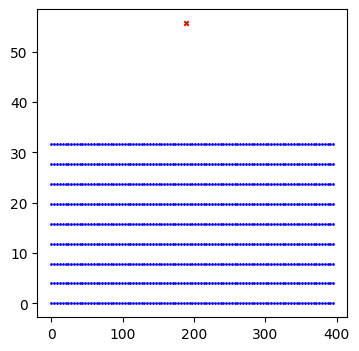

Epoch 454/500
Loss: 1.2391858100891113 MeanGrad: [-2.622818e-09  5.887759e-08]


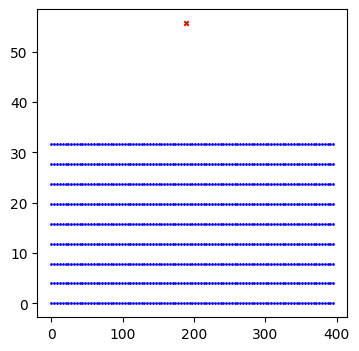

Epoch 455/500
Loss: 1.2391858100891113 MeanGrad: [7.9998035e-09 8.7462688e-08]


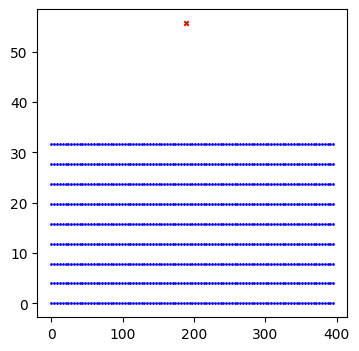

Epoch 456/500
Loss: 1.2391859292984009 MeanGrad: [6.350694e-09 4.841924e-08]


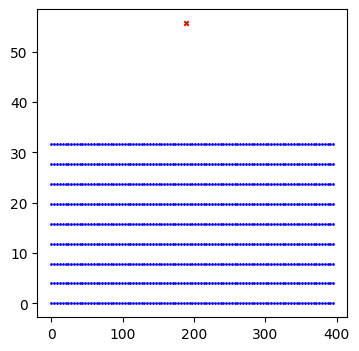

Epoch 457/500
Loss: 1.2391859292984009 MeanGrad: [8.3239965e-10 3.8495376e-08]


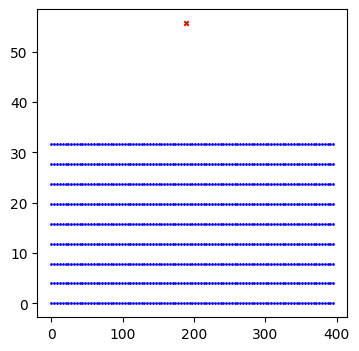

Epoch 458/500
Loss: 1.2391858100891113 MeanGrad: [7.3901196e-09 5.7655949e-08]


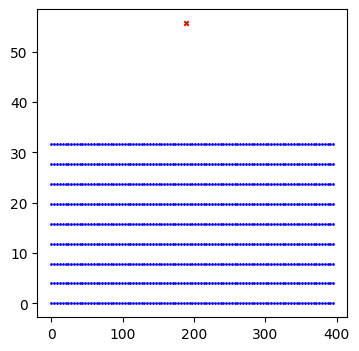

Epoch 459/500
Loss: 1.2391858100891113 MeanGrad: [-4.2592418e-09  4.8893533e-08]


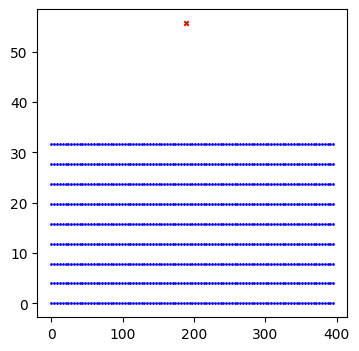

Epoch 460/500
Loss: 1.2391859292984009 MeanGrad: [-3.2377998e-09  4.5356817e-08]


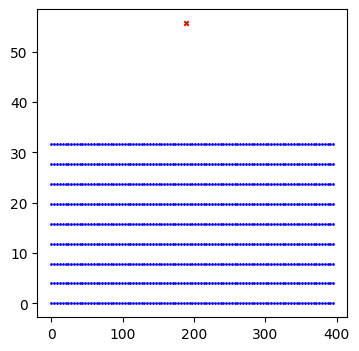

Epoch 461/500
Loss: 1.23918616771698 MeanGrad: [-3.4428713e-09  2.5389085e-08]


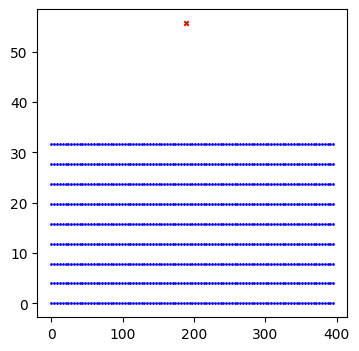

Epoch 462/500
Loss: 1.23918616771698 MeanGrad: [-7.6183371e-09  3.0428374e-08]


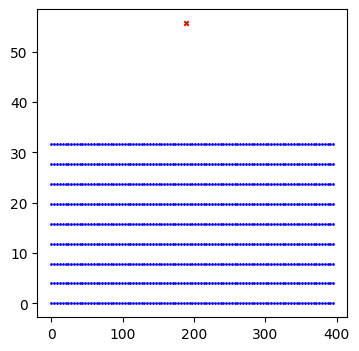

Epoch 463/500
Loss: 1.2391859292984009 MeanGrad: [-2.9245715e-09  6.3056710e-08]


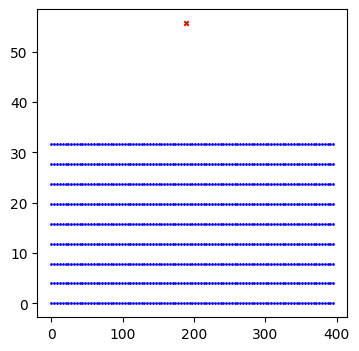

Epoch 464/500
Loss: 1.23918616771698 MeanGrad: [-5.2620894e-09  3.4453141e-08]


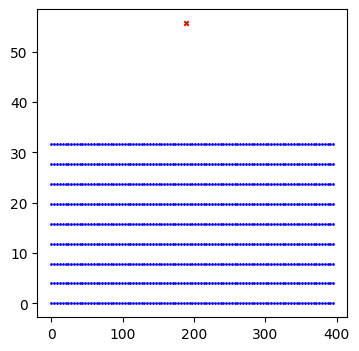

Epoch 465/500
Loss: 1.2391858100891113 MeanGrad: [4.5321347e-09 8.1567897e-08]


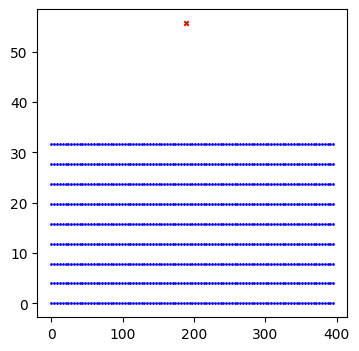

Epoch 466/500
Loss: 1.2391855716705322 MeanGrad: [-7.8136408e-10  1.1547618e-07]


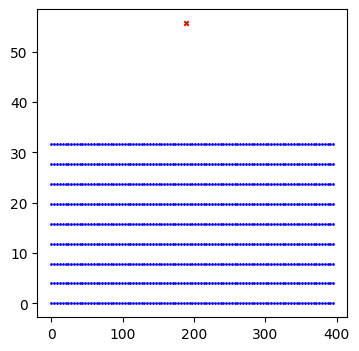

Epoch 467/500
Loss: 1.2391856908798218 MeanGrad: [1.7910960e-09 1.0470758e-07]


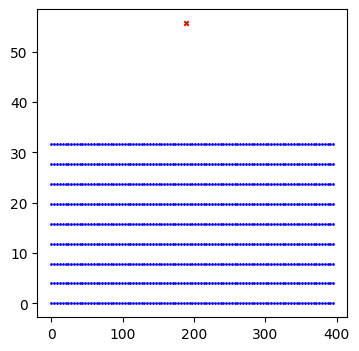

Epoch 468/500
Loss: 1.2391859292984009 MeanGrad: [1.9739979e-09 4.3926107e-08]


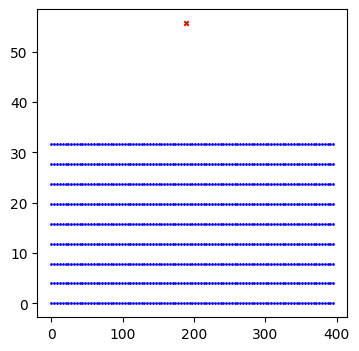

Epoch 469/500
Loss: 1.2391858100891113 MeanGrad: [4.4521533e-09 9.6442399e-08]


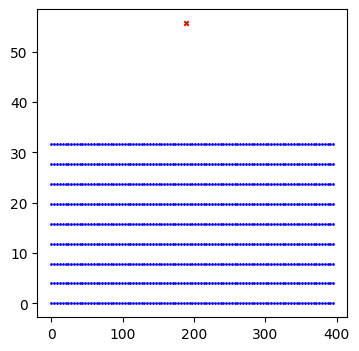

Epoch 470/500
Loss: 1.2391858100891113 MeanGrad: [-9.7758113e-09  4.0640924e-08]


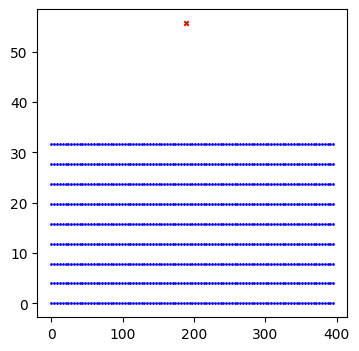

Epoch 471/500
Loss: 1.2391860485076904 MeanGrad: [1.1442908e-09 1.6999746e-08]


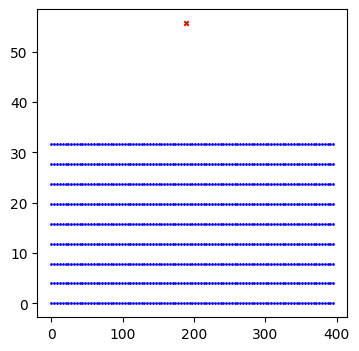

Epoch 472/500
Loss: 1.2391860485076904 MeanGrad: [2.7367475e-09 4.8688559e-08]


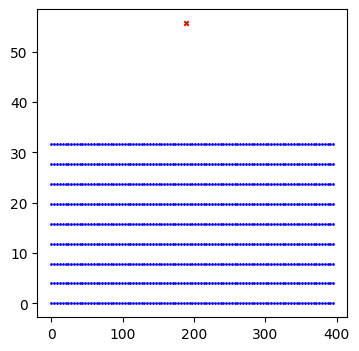

Epoch 473/500
Loss: 1.2391858100891113 MeanGrad: [-1.1601919e-09  5.8476061e-08]


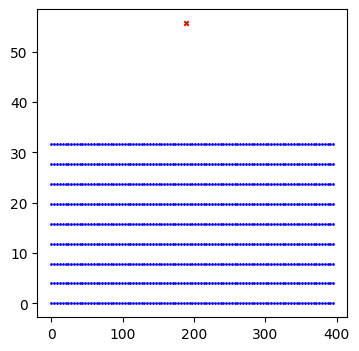

Epoch 474/500
Loss: 1.2391860485076904 MeanGrad: [4.7287205e-09 2.9124958e-08]


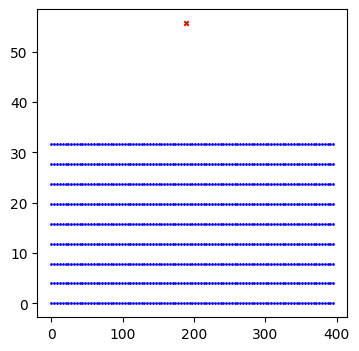

Epoch 475/500
Loss: 1.23918616771698 MeanGrad: [-2.0186910e-09  1.5451302e-08]


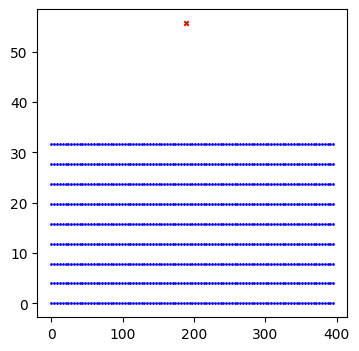

Epoch 476/500
Loss: 1.2391860485076904 MeanGrad: [4.4769024e-09 2.6939853e-08]


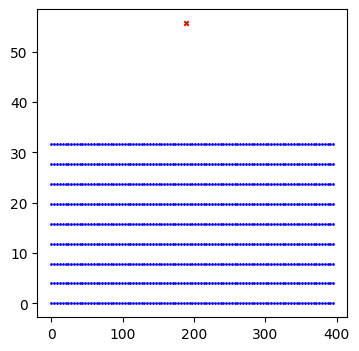

Epoch 477/500
Loss: 1.2391858100891113 MeanGrad: [-5.7372893e-09  5.7590391e-08]


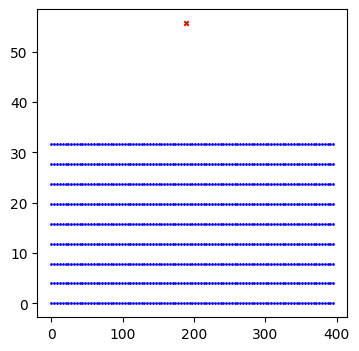

Epoch 478/500
Loss: 1.2391858100891113 MeanGrad: [3.0181382e-09 9.2441198e-08]


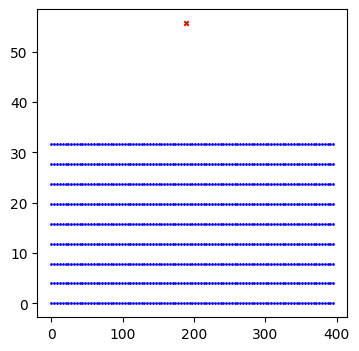

Epoch 479/500
Loss: 1.2391860485076904 MeanGrad: [-1.075930e-09  3.357687e-08]


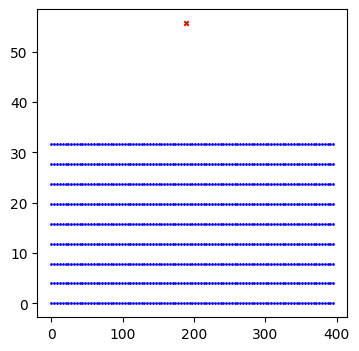

Epoch 480/500
Loss: 1.2391858100891113 MeanGrad: [1.1644213e-08 6.9108587e-08]


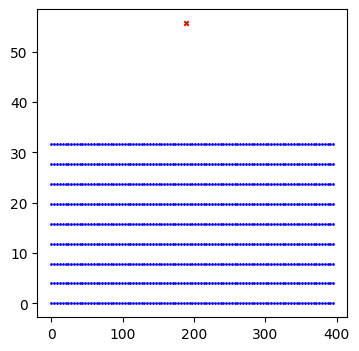

Epoch 481/500
Loss: 1.2391860485076904 MeanGrad: [-3.2083298e-09  4.8130911e-08]


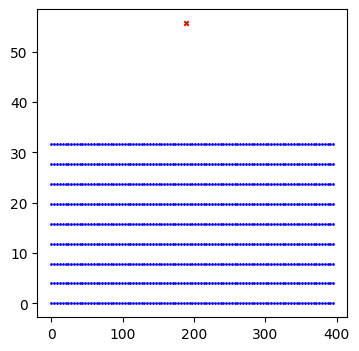

Epoch 482/500
Loss: 1.2391856908798218 MeanGrad: [2.0111889e-08 1.0921665e-07]


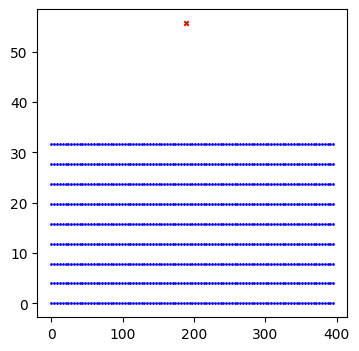

Epoch 483/500
Loss: 1.2391859292984009 MeanGrad: [1.8913231e-09 6.5564244e-08]


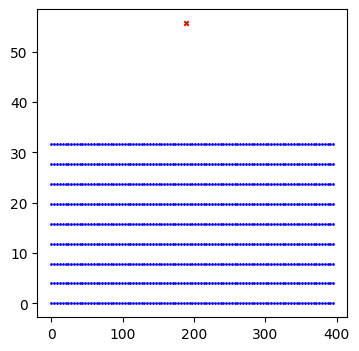

Epoch 484/500
Loss: 1.2391858100891113 MeanGrad: [4.65553773e-09 1.04425474e-07]


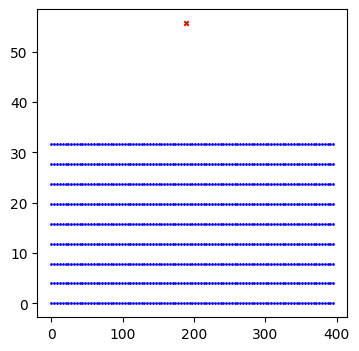

Epoch 485/500
Loss: 1.2391859292984009 MeanGrad: [1.916400e-09 6.902065e-08]


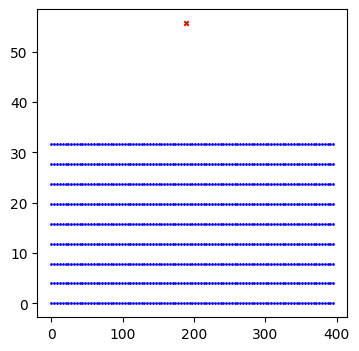

Epoch 486/500
Loss: 1.2391858100891113 MeanGrad: [6.399745e-10 4.085144e-08]


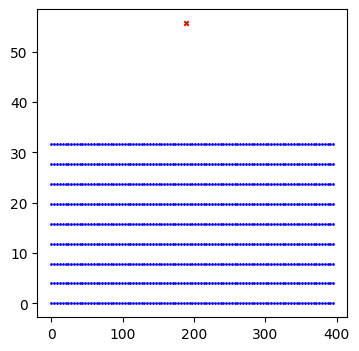

Epoch 487/500
Loss: 1.23918616771698 MeanGrad: [-6.1341341e-09  2.6720121e-08]


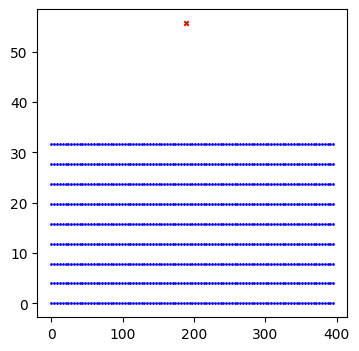

Epoch 488/500
Loss: 1.2391858100891113 MeanGrad: [1.3664321e-08 7.3886056e-08]


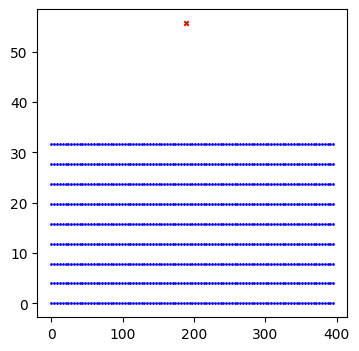

Epoch 489/500
Loss: 1.2391860485076904 MeanGrad: [7.5516322e-09 2.8232494e-08]


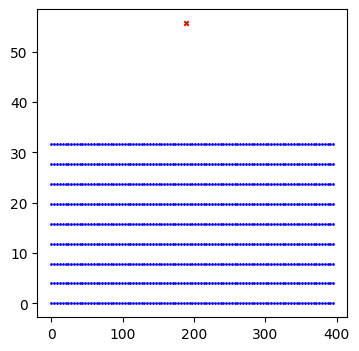

Epoch 490/500
Loss: 1.23918616771698 MeanGrad: [5.0086566e-09 1.7907173e-08]


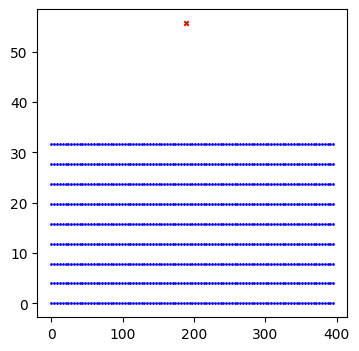

Epoch 491/500
Loss: 1.2391855716705322 MeanGrad: [-1.1053946e-08  1.2735609e-07]


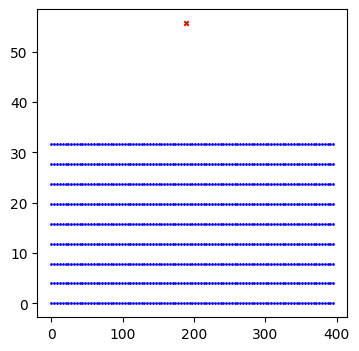

Epoch 492/500
Loss: 1.2391859292984009 MeanGrad: [6.9626833e-09 6.4246855e-08]


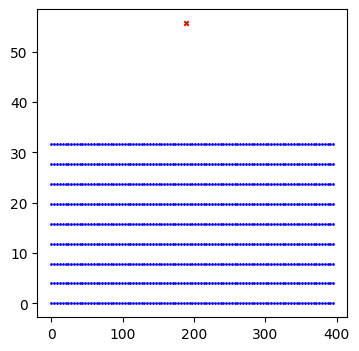

Epoch 493/500
Loss: 1.2391860485076904 MeanGrad: [2.4440354e-09 4.2672088e-08]


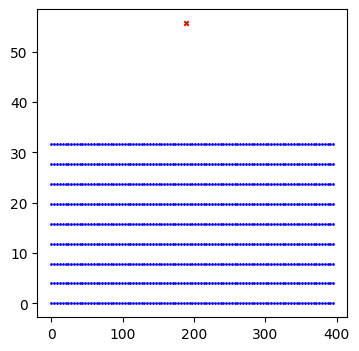

Epoch 494/500
Loss: 1.23918616771698 MeanGrad: [6.6106032e-09 2.1350465e-08]


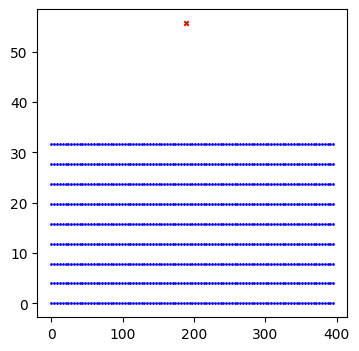

Epoch 495/500
Loss: 1.2391856908798218 MeanGrad: [-9.3269596e-09  1.3338504e-07]


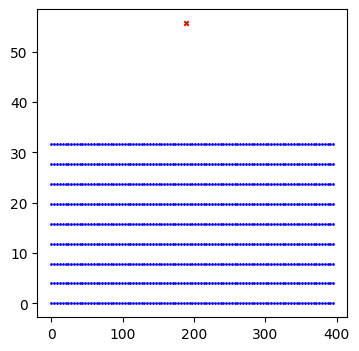

Epoch 496/500
Loss: 1.2391859292984009 MeanGrad: [-8.751540e-09  6.585611e-08]


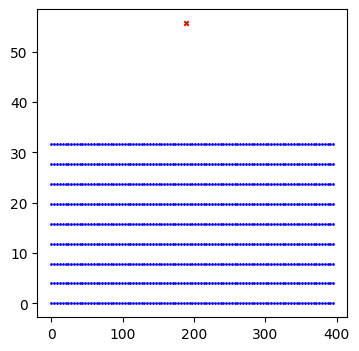

Epoch 497/500
Loss: 1.2391856908798218 MeanGrad: [1.2531574e-08 8.8119194e-08]


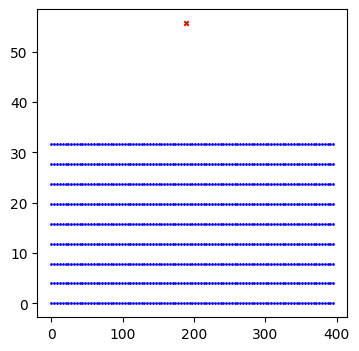

Epoch 498/500
Loss: 1.2391859292984009 MeanGrad: [-1.09939995e-08  6.48158078e-08]


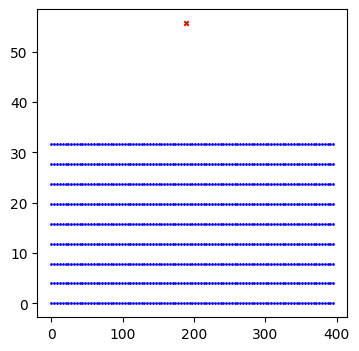

Epoch 499/500
Loss: 1.2391858100891113 MeanGrad: [6.3927317e-09 6.0474484e-08]


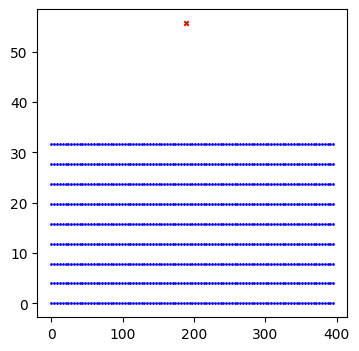

Epoch 500/500
Loss: 1.2391858100891113 MeanGrad: [-4.5243929e-09  4.5410186e-08]
System Energy: -6.749610737245162 Last Loss: 1.2391858100891113
final_position: [[188.9734    55.677624]] starting_position: [[188.97313   55.914433]]


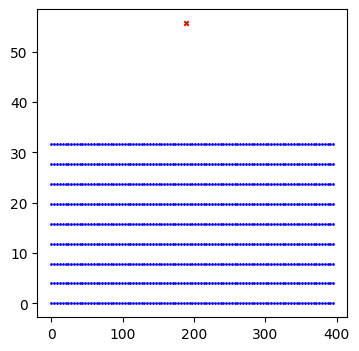

In [9]:
ion_ =  ion.numpy()
plt.figure(figsize=(4,4))
plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=30)
plt.scatter(ion_[:,0],ion_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 1.0
batch_size = 256
epochs = 500
decay_rate = 0.20
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    optimizer.learning_rate = eta
    for x_batch in tf.data.Dataset.from_tensor_slices(sample_atoms).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_ = H_loss(ion,x_batch)
      grad_ = g.gradient(H_loss_, ion)
      optimizer.apply_gradients(zip([grad_], [ion]))#El gradiente es muy peuqeño, quiza jugando con las unidades¿?
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    ion_ =  ion.numpy()
    gradN = -10*eta*grad_.numpy()
    if epoch+1==epochs:
      last_loss = H_loss_.numpy()
      system_energy = last_loss-(num_atoms*num_atomos_extra*Epsilon)
      print(f'System Energy: {system_energy}',f'Last Loss: {last_loss}')
      print(f'final_position: {ion_}',f'starting_position: {starting_pos}')

    plt.figure(figsize=(4,4))
    plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=1)
    plt.scatter(ion_[:,0],ion_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(ion_[:,0],ion_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

# Tareas Luker - Sofia y Juan Lugo


## Unsupervised Deep Embedding for Clustering Analysis

https://proceedings.mlr.press/v48/xieb16.pdf

https://github.com/HaebinShin/dec-tensorflow


## Tareas Sofia:

Revisar matemática PRI

Revisar Paper Unsupervised Deep Embedding for Clustering Analysis

Implementar DEC según github compartido y aplicar sobre experimento de goku y sobre Fashion Mnist

## Tareas Juan Lugo

Revisar modelo tabnet

https://paperswithcode.com/method/tabnet

Revisar implementaciones sobre keras

https://github.com/jeyabbalas/tabnet

Aplicar sobre base de datos fifa19 curso aprendizaje de máquina para luego aplicar a Luker

## Objetivo luker

- Unir DCE/PRI sofia con Tabnet Lugo, con modelo generativo para lidear con generación de propiedades físico químicas desde espacio latente anotadores

## Tareas sofia y lugo

Revisar focal loss para lidear con datos desbalanceados

https://paperswithcode.com/method/focal-loss